# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import chain, combinations, permutations
import urllib.request

%matplotlib inline

## Input data

In [27]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
Distance matrix:
 [[   0.          666.10809934  281.11385594 ...  217.08293346
   789.38267019 1220.46097848]
 [ 666.10809934    0.          649.32657423 ...  596.25917184
  1421.55724471 1716.04924172]
 [ 281.11385594  649.32657423    0.         ...  463.24939288
   995.3140208  1483.59361012]
 ...
 [ 217.08293346  596.25917184  463.24939288 ...    0.
   829.60834133 1150.76061803]
 [ 789.38267019 1421.55724471  995.3140208  ...  829.60834133
     0.          624.81997407]
 [1220.46097848 1716.04924172 1483.59361012 ... 1150.76061803
   624.81997407    0.        ]]
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


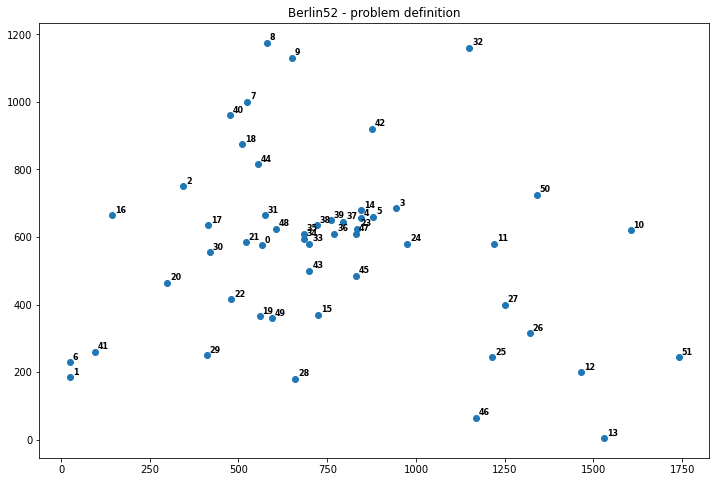

In [28]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

<Figure size 864x576 with 0 Axes>

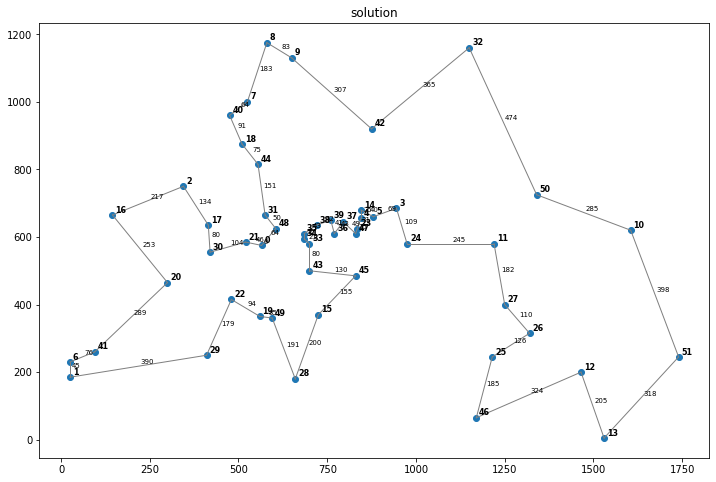

In [29]:
from matplotlib.lines import Line2D

def show_route(route):
    plt.figure(figsize=(12,8))
    fig, ax = plt.subplots(figsize=(12,8))

    plt.plot(coords[:, 0], coords[:, 1], 'o')

    for i in range(n):
        plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

    ax.add_line(Line2D(
        [coords[0, 0], coords[route[0], 0]],
        [coords[0, 1], coords[route[0], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
             (coords[0, 1] + coords[route[0], 1])/2 + 6,
             '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
    for i in range(1, len(route)):
        ax.add_line(Line2D(
            [coords[route[i-1], 0], coords[route[i], 0]],
            [coords[route[i-1], 1], coords[route[i], 1]],
            linewidth=1, color='gray'))
        plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
                 (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
                 '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
    ax.add_line(Line2D(
        [coords[route[-1], 0], coords[0, 0]],
        [coords[route[-1], 1], coords[0, 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
             (coords[route[-1], 1] + coords[0, 1])/2 + 6,
             '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

    plt.title('solution')

    plt.show()
show_route(p)

## Objective function

In [5]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [207]:
print(tsp_objective_function(p), p)

7544.365901904086 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## Random Sampling

In [283]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = tsp_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(tsp_objective_function(p), p)

122.16771626472473
285523.0887170799 [ 95  40 173 100  58  31 189 180 188  32  36 150   8 137  94 184  45  66
 113 198 147  29  55 164 174  15  17 146 123  91  10 179 171  48  18  68
  42 143 175 156 140  84 127  11 192 170 139  50  35 142 104  82  96 149
  59 118 108  83 122 183  57 136 181 130  65  77 187 117 155  72  51  22
 126 182 157 190   0   6 195   4 102 154  26  21  88  38 168 135 120  52
  14 193 148  56 145 116  16 197 107 159 199  98  27   7 152 124  74 121
  99   1  71 144  47 141  70  25 162   9 165  90  12 161  87  34  53 112
  86  49 128  28 153   2  62 169 114 105  19 196  13  80 191 110  60  79
 125 115 131  89 119 185  63  61 163 167  54 166 103  85  23  39 172 160
  67 133 134   5 132 151  24 194  46 106  64  73   3 178  43 109  78  75
  37  93 101  44  20 177 111 138  97 186  76  30  92  33  41  69 129 176
  81 158]


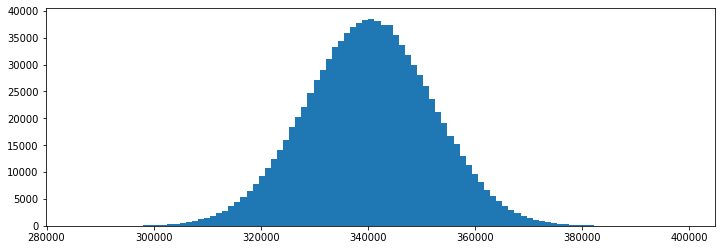

340233.2261250979 11778.54276105218


In [284]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [57]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [65]:
T = 1000000
radius = 1
alpha = 0.8

t0 = time.time()

p = np.random.permutation(n)
p_cost = tsp_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = tsp_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

60.31306529045105 8682.58013276501


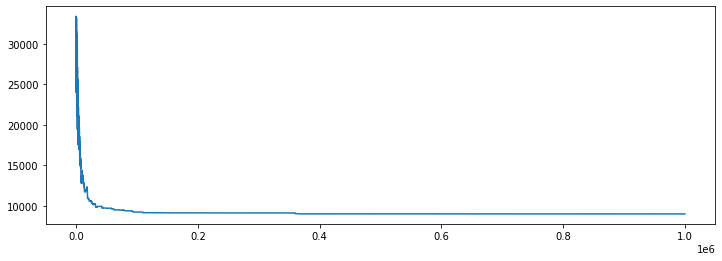

In [63]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

## SGA-PMX

In [6]:
def PMX(ind1, ind2):

    cut1 = np.random.choice(range(0, len(ind1)))
    cut2 = cut1
    while cut2 == cut1:
        cut2 = np.random.choice(range(0, len(ind1)))
    if cut1 > cut2:
        tmp = cut1
        cut1 = cut2
        cut2 = tmp

    off1 = np.zeros(len(ind1)) - 1
    off2 = np.zeros(len(ind2)) - 1
    off1[cut1:cut2] = ind2[cut1:cut2]
    off2[cut1:cut2] = ind1[cut1:cut2]
    
    for i, val in enumerate(ind1):
        if off1[i] == -1 and val not in off1:
            off1[i] = val
    for i, val in enumerate(ind2):
        if off2[i] == -1 and val not in off2:
            off2[i] = val
            
    for i, val in enumerate(ind1):
        if off1[i] == -1:
            current = val
            while True:
                pos = np.where(ind2 == current)
                if ind1[pos] not in off1:
                    off1[i] = ind1[pos]
                    break
                current = ind1[pos]

    for i, val in enumerate(ind2):
        if off2[i] == -1:
            current = val
            while True:
                pos = np.where(ind1 == current)
                if ind2[pos] not in off2:
                    off2[i] = ind2[pos]
                    break
                current = ind2[pos]
    return off1, off2

In [7]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [33]:
chromosome_length = n
hist = None
best_chromosome = None

def SGA(population_size=500, crossover_probability=0.95, mutation_probability=0.30, number_of_iterations=250, mutation_function=reverse_sequence_mutation, cross_operator=PMX):
    time0 = time.time()
    number_of_offspring = population_size
    global hist
    hist = np.zeros(number_of_iterations)
    global best_chromosome
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :])



    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = cross_operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation_function(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        hist[t] = best_objective_value

        # recording some statistics
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))

In [223]:
SGA(population_size=1000, crossover_probability=0.95, mutation_probability=0.50)

  0     0.38202596 24326.87255220 28427.97899969 29792.64350142 1093.75425844
  1     0.74556613 23544.52355379 27267.09799067 28506.99530988 933.11111256
  2     1.09854460 21893.73400714 26412.50426493 27471.60323308 858.69683554
  3     1.45038438 21719.29089968 25685.53617321 26668.70513805 819.23896206
  4     1.81194973 21719.29089968 25064.99673976 26042.59946163 821.52088806
  5     2.15754008 21350.38920873 24481.36864582 25461.21104142 775.16580450
  6     2.49936295 20719.91367652 23967.14198261 24865.20628934 730.52978520
  7     2.84975529 20556.18126506 23500.05907606 24367.01007804 709.20654499
  8     3.19053411 19936.75382908 23117.66443726 23929.15718420 675.09512726
  9     3.52760243 19936.75382908 22705.63250059 23539.14117137 679.17008875
 10     3.88099980 19755.84469641 22333.83842203 23177.02701586 657.70324890
 11     4.22409248 19676.03418515 21998.99070132 22803.38960007 625.00046140
 12     4.57561040 19127.63256964 21681.98558745 22440.40654816 602.4755233

108    33.17724061 8366.99695024 8512.33200393 8542.62125887  40.13758849
109    33.43229890 8348.44126446 8482.04011068 8542.62125887  40.35638430
110    33.70442033 8304.97040316 8452.55236654 8500.18290464  17.36469376
111    33.95700383 8304.97040316 8447.58891602 8456.83311552  19.98067239
112    34.23719811 8263.97462372 8434.78368577 8456.83311552  32.55379667
113    34.51510048 8246.98594346 8417.59658751 8456.83311552  42.47848584
114    34.80341172 8246.88390892 8398.98700898 8451.74855425  47.44198015
115    35.12905836 8242.77567146 8377.79657872 8437.10498996  46.99365844
116    35.75344729 8211.40930804 8360.99400451 8412.83178805  46.35456527
117    36.03001475 8211.40930804 8339.98804129 8409.56572118  41.88081976
118    36.30253625 8211.40930804 8319.07457072 8372.46310775  32.99824891
119    36.57304835 8180.13987515 8302.14568082 8348.44126446  29.99634819
120    36.83220482 8165.95540429 8285.09512041 8310.05496444  23.11989043
121    37.09623575 8165.95540429 8271.

219    64.71415973 7837.13226593 7837.13226593 7837.13226593   0.00000000
220    65.25640202 7837.13226593 7837.13226593 7837.13226593   0.00000000
221    65.51114941 7837.13226593 7837.13226593 7837.13226593   0.00000000
222    65.77390385 7837.13226593 7837.13226593 7837.13226593   0.00000000
223    66.00878668 7837.13226593 7837.13226593 7837.13226593   0.00000000
224    66.24213052 7837.13226593 7837.13226593 7837.13226593   0.00000000
225    66.47317433 7837.13226593 7837.13226593 7837.13226593   0.00000000
226    66.71640038 7837.13226593 7837.13226593 7837.13226593   0.00000000
227    66.95433092 7837.13226593 7837.13226593 7837.13226593   0.00000000
228    67.24304843 7837.13226593 7837.13226593 7837.13226593   0.00000000
229    67.62558293 7837.13226593 7837.13226593 7837.13226593   0.00000000
230    67.89246225 7837.13226593 7837.13226593 7837.13226593   0.00000000
231    68.14495850 7837.13226593 7837.13226593 7837.13226593   0.00000000
232    68.38866258 7837.13226593 7837.

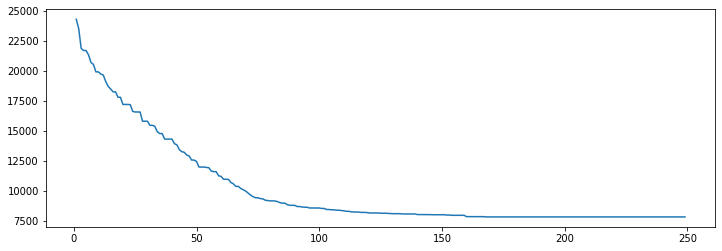

In [224]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [225]:
def transposition_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    tmp = q[i]
    q[i] = q[j]
    q[j] = tmp
    return q

In [303]:
SGA(population_size=2000, crossover_probability=0.95, mutation_probability=0.30, mutation_function=transposition_mutation)

  0     0.77744412 22848.05280206 28446.26422041 29744.25630623 1002.97921687
  1     1.48400021 22848.05280206 27394.05590071 28557.97727543 945.24412316
  2     2.16509891 21693.09419887 26504.83872158 27601.29841223 897.04610052
  3     2.85327649 21637.84119761 25742.77639037 26775.40361257 860.58962039
  4     3.55158305 21545.42090236 25069.56511405 26082.73979778 838.97738157
  5     4.23469377 19933.47556908 24456.53899791 25433.65523334 803.82392903
  6     4.91710687 19933.47556908 23914.89088983 24873.13947076 778.76129911
  7     5.61758494 19879.40922428 23413.54319342 24336.61037491 772.60475718
  8     6.30108261 19879.40922428 22927.86211170 23863.19442656 774.58978223
  9     6.96907949 19052.54562491 22421.40055091 23358.10179662 765.68914873
 10     7.65443826 19015.23139771 21948.24264617 22869.19731885 718.96058963
 11     8.32027221 18211.34189904 21490.69046617 22358.80829860 667.02621160
 12     8.97676659 18008.22546256 21065.51355147 21853.39147571 612.3871964

107    59.53813100 9955.91806752 9955.91806752 9955.91806752   0.00000000
108    60.00778556 9955.91806752 9955.91806752 9955.91806752   0.00000000
109    60.47170496 9955.91806752 9955.91806752 9955.91806752   0.00000000
110    60.93749714 9955.91806752 9955.91806752 9955.91806752   0.00000000
111    61.43778706 9955.91806752 9955.91806752 9955.91806752   0.00000000
112    61.89857554 9955.91806752 9955.91806752 9955.91806752   0.00000000
113    62.37008572 9955.91806752 9955.91806752 9955.91806752   0.00000000
114    62.82948589 9955.91806752 9955.91806752 9955.91806752   0.00000000
115    63.31238937 9955.91806752 9955.91806752 9955.91806752   0.00000000
116    63.77895713 9955.91806752 9955.91806752 9955.91806752   0.00000000
117    64.25228071 9955.91806752 9955.91806752 9955.91806752   0.00000000
118    64.71210694 9955.91806752 9955.91806752 9955.91806752   0.00000000
119    65.18083358 9955.91806752 9955.91806752 9955.91806752   0.00000000
120    65.63801003 9955.91806752 9955.

218   112.61172938 9955.91806752 9955.91806752 9955.91806752   0.00000000
219   113.08239603 9955.91806752 9955.91806752 9955.91806752   0.00000000
220   113.55687356 9955.91806752 9955.91806752 9955.91806752   0.00000000
221   114.00949693 9955.91806752 9955.91806752 9955.91806752   0.00000000
222   114.47819233 9955.91806752 9955.91806752 9955.91806752   0.00000000
223   114.93330789 9955.91806752 9955.91806752 9955.91806752   0.00000000
224   115.40807557 9955.91806752 9955.91806752 9955.91806752   0.00000000
225   115.87348938 9955.91806752 9955.91806752 9955.91806752   0.00000000
226   116.35158825 9955.91806752 9955.91806752 9955.91806752   0.00000000
227   116.81853390 9955.91806752 9955.91806752 9955.91806752   0.00000000
228   117.29089975 9955.91806752 9955.91806752 9955.91806752   0.00000000
229   117.76153731 9955.91806752 9955.91806752 9955.91806752   0.00000000
230   118.23819661 9955.91806752 9955.91806752 9955.91806752   0.00000000
231   118.69841003 9955.91806752 9955.

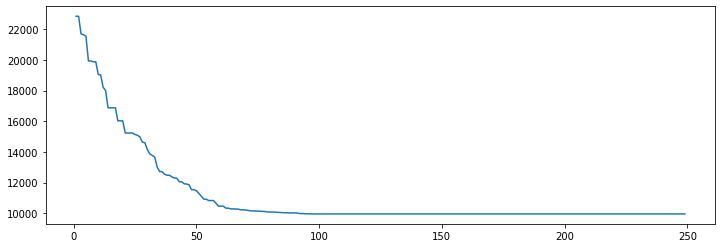

In [304]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [298]:
SGA(population_size=1000, crossover_probability=0.95, cross_operator=OX, mutation_probability=0.50)

  0     0.42124987 25017.28648732 28378.27445499 29620.05406855 914.81735919
  1     0.68350458 23593.04772419 27308.60051339 28373.56151304 857.07325270
  2     0.94571042 22706.79281017 26374.24250279 27404.00071276 835.56027436
  3     1.23246336 22050.40509789 25445.74578225 26488.38817458 826.19354867
  4     1.49858928 21039.20394782 24668.39381766 25643.22481799 782.05519076
  5     1.76006579 21039.20394782 23987.50766557 24903.76540663 758.20653288
  6     2.03186774 20231.52831008 23322.00483650 24224.81358365 747.25220101
  7     2.29170132 19696.03843033 22681.37966626 23557.02886249 753.23331889
  8     2.54996514 18400.79581237 22055.09061265 22940.70836806 699.68858501
  9     2.80931091 17933.46805676 21523.49708292 22358.57962841 675.31295062
 10     3.08261085 17735.31009208 21000.13387967 21754.36096099 629.23970906
 11     3.34666204 17735.31009208 20501.81362735 21253.48035706 625.30122161
 12     3.60493350 17316.67467240 20038.96622017 20785.53862522 621.37391615

108    33.44819856 8241.40653569 8521.29545762 8625.60997853  94.67222316
109    33.70616722 8215.19066235 8464.95701406 8588.17499937  89.05638542
110    33.98105502 8152.00506431 8418.01224946 8531.71174951  82.78291965
111    34.24842644 8107.50143031 8361.76346292 8468.64272853  61.42553290
112    34.50897264 8107.50143031 8329.40401337 8399.42400874  52.22147503
113    34.76421523 8088.93604333 8294.85205267 8369.50114422  44.11644966
114    35.35609436 8088.93604333 8266.95528451 8316.49326486  41.36419624
115    35.61887240 8062.72016999 8236.29786737 8292.81209422  36.41428106
116    35.87494802 7957.86517034 8210.77823396 8241.40653569  42.42212575
117    36.15712690 7934.48352939 8171.65042229 8223.57159929  59.66959365
118    36.42265034 7934.48352939 8120.30382939 8215.19066235  61.00695006
119    36.68418741 7931.64929699 8072.43378852 8128.62342336  40.44723188
120    36.94472766 7931.64929699 8054.44302712 8088.93604333  50.23756217
121    37.21558285 7922.00930728 8003.

219    65.72330880 7799.13816116 7799.13816116 7799.13816116   0.00000000
220    65.98865366 7799.13816116 7799.13816116 7799.13816116   0.00000000
221    66.30230689 7799.13816116 7799.13816116 7799.13816116   0.00000000
222    66.74101901 7799.13816116 7799.13816116 7799.13816116   0.00000000
223    67.01364350 7799.13816116 7799.13816116 7799.13816116   0.00000000
224    67.27754235 7799.13816116 7799.13816116 7799.13816116   0.00000000
225    67.53554869 7799.13816116 7799.13816116 7799.13816116   0.00000000
226    67.79390407 7799.13816116 7799.13816116 7799.13816116   0.00000000
227    68.06260800 7799.13816116 7799.13816116 7799.13816116   0.00000000
228    68.32488513 7799.13816116 7799.13816116 7799.13816116   0.00000000
229    68.58352971 7799.13816116 7799.13816116 7799.13816116   0.00000000
230    68.84256840 7799.13816116 7799.13816116 7799.13816116   0.00000000
231    69.12368298 7799.13816116 7799.13816116 7799.13816116   0.00000000
232    69.38317204 7799.13816116 7799.

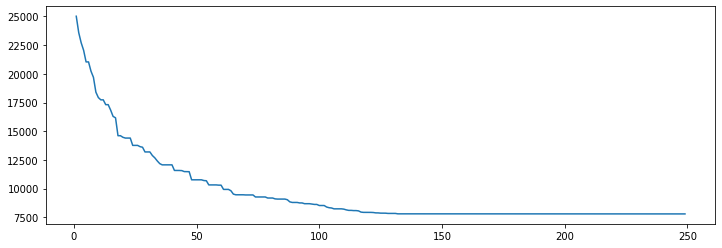

In [299]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [335]:
SGA(population_size=1000, crossover_probability=0.95, cross_operator=CX, mutation_probability=0.50)

  0     0.33613014 22765.67481686 28370.66030121 29705.90844814 1023.58973054
  1     0.61053610 22684.96957589 27355.39507452 28526.19831514 945.80936977
  2     0.88806129 22684.96957589 26459.37823158 27603.93816634 936.19753301
  3     1.24098349 21218.84280386 25700.36140646 26752.99698295 883.43326059
  4     1.56013012 21218.84280386 25010.31679636 26033.83578276 869.84610190
  5     1.82830405 21007.76608809 24430.30938882 25452.76720338 808.13381716
  6     2.07890129 21007.76608809 23886.17015705 24814.57074491 759.50341042
  7     2.33242822 20855.11566793 23408.39744232 24269.14901708 705.60475775
  8     2.57008886 19721.10120187 22973.34980566 23793.74975361 687.85275099
  9     2.81211972 19721.10120187 22578.33447967 23401.40006798 664.58142215
 10     3.12267804 19721.10120187 22106.56060768 22975.85567538 563.62396052
 11     3.36310530 19266.74820528 21767.66794285 22427.38150223 497.98269072
 12     3.59093404 19266.74820528 21494.46667311 22080.55347238 510.4558257

109    17.11545038 8585.14946938 8730.61269278 8733.20563225  16.55099242
110    17.25863266 8552.34875812 8676.60620236 8733.20563225  64.41714232
111    17.36458492 8509.68565011 8608.71058573 8712.04234222  37.97128182
112    17.63931990 8509.68565011 8584.88839450 8598.81228022   5.00577102
113    17.76858640 8509.68565011 8583.54678778 8585.14946938   9.81109074
114    17.88066554 8376.22015408 8551.73971931 8585.14946938  35.18226160
115    18.02298522 8376.22015408 8515.31357632 8561.00621698  19.21055053
116    18.28242326 8376.22015408 8505.72294567 8509.68565011  20.87763666
117    18.41807222 8295.44651611 8447.40243565 8509.68565011  61.97878409
118    18.52943850 8295.44651611 8385.68230363 8452.01643616  22.42552649
119    18.61769748 8295.44651611 8375.05882993 8376.22015408   8.23016512
120    18.70533442 8196.84805313 8345.23179933 8376.22015408  33.75341959
121    18.86826515 8196.84805313 8311.88371162 8368.56386680  21.57001587
122    18.99936867 8196.84805313 8297.

222    28.20080280 7911.67928204 7911.67928204 7911.67928204   0.00000000
223    28.29732037 7911.67928204 7911.67928204 7911.67928204   0.00000000
224    28.38558769 7911.67928204 7911.67928204 7911.67928204   0.00000000
225    28.47643399 7911.67928204 7911.67928204 7911.67928204   0.00000000
226    28.56449032 7911.67928204 7911.67928204 7911.67928204   0.00000000
227    28.65135622 7911.67928204 7911.67928204 7911.67928204   0.00000000
228    28.74133182 7911.67928204 7911.67928204 7911.67928204   0.00000000
229    28.82912564 7911.67928204 7911.67928204 7911.67928204   0.00000000
230    28.91685820 7911.67928204 7911.67928204 7911.67928204   0.00000000
231    29.00577021 7911.67928204 7911.67928204 7911.67928204   0.00000000
232    29.09229040 7911.67928204 7911.67928204 7911.67928204   0.00000000
233    29.17955875 7911.67928204 7911.67928204 7911.67928204   0.00000000
234    29.27785850 7911.67928204 7911.67928204 7911.67928204   0.00000000
235    29.39472818 7911.67928204 7911.

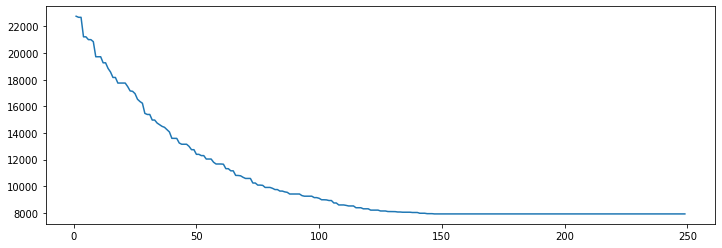

In [336]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [34]:
SGA(population_size=1000, crossover_probability=0.95, cross_operator=SWP, mutation_probability=0.50)

  0     0.36595845 24965.68652703 28450.73632455 29725.19923354 982.80728635
  1     0.52226853 23770.28194015 27239.28340836 28224.29909879 803.87150015
  2     0.68473768 23619.55770900 26167.89139864 27146.41215395 705.56923184
  3     0.84210658 22776.48729346 25351.38615309 26043.18013704 475.72822980
  4     1.00406098 22693.32726017 24830.45273497 25237.73255761 415.42965309
  5     1.16619802 21169.74569887 24240.43197674 24895.36765842 531.84226231
  6     1.41980910 21169.74569887 23580.01355102 24069.83997467 430.21161373
  7     1.57754993 20726.47433883 23021.85922566 23599.16769834 520.44836007
  8     1.73407888 20266.89836416 22335.09246335 22966.08359539 640.42892751
  9     1.90906191 20194.60590797 21411.07920343 22333.35023001 436.66002679
 10     2.18500519 19913.14530783 21040.37898489 21233.09592421 218.67943684
 11     2.33846951 19283.26196259 20727.16677525 21085.29500394 294.94834507
 12     2.49494123 19283.26196259 20379.61553574 20726.47433883 262.03037500

108    19.55314851 9201.96884293 9279.84495814 9308.69654660  26.44795254
109    19.70764089 9201.96884293 9254.11034547 9292.07947810  17.22855135
110    19.87131166 9178.39605352 9240.65177293 9268.17451043  10.19216164
111    20.03015947 9178.39605352 9235.08835201 9242.49087910   9.00269716
112    20.19142652 9134.51874381 9226.75156412 9236.54286410  15.93728901
113    20.34861326 9134.51874381 9207.12941076 9236.54286410  17.53717642
114    20.50682116 9075.61782782 9195.03493581 9207.26096756  13.17157319
115    20.66145158 9075.61782782 9184.47324135 9201.96884293  17.26479297
116    20.81365728 9075.61782782 9168.34131019 9184.34406852  18.83401431
117    20.99128151 9070.67503158 9150.52360032 9178.39605352  25.93692311
118    21.14616394 9070.67503158 9126.98850476 9161.98503518  23.42421615
119    21.30074453 8988.45123782 9112.81741084 9134.51874381  28.37563039
120    21.46011305 8988.45123782 9083.09900216 9134.51874381  20.93862455
121    21.61612558 8988.45123782 9073.

220    37.25908065 8511.54882136 8511.54882136 8511.54882136   0.00000000
221    37.41493678 8511.54882136 8511.54882136 8511.54882136   0.00000000
222    37.57214236 8511.54882136 8511.54882136 8511.54882136   0.00000000
223    37.72688723 8511.54882136 8511.54882136 8511.54882136   0.00000000
224    37.89061451 8511.54882136 8511.54882136 8511.54882136   0.00000000
225    38.04516220 8511.54882136 8511.54882136 8511.54882136   0.00000000
226    38.19964600 8511.54882136 8511.54882136 8511.54882136   0.00000000
227    38.35651660 8511.54882136 8511.54882136 8511.54882136   0.00000000
228    38.51165247 8511.54882136 8511.54882136 8511.54882136   0.00000000
229    38.66376281 8511.54882136 8511.54882136 8511.54882136   0.00000000
230    38.82047153 8511.54882136 8511.54882136 8511.54882136   0.00000000
231    38.97951436 8511.54882136 8511.54882136 8511.54882136   0.00000000
232    39.13436413 8511.54882136 8511.54882136 8511.54882136   0.00000000
233    39.28647971 8511.54882136 8511.

<Figure size 864x576 with 0 Axes>

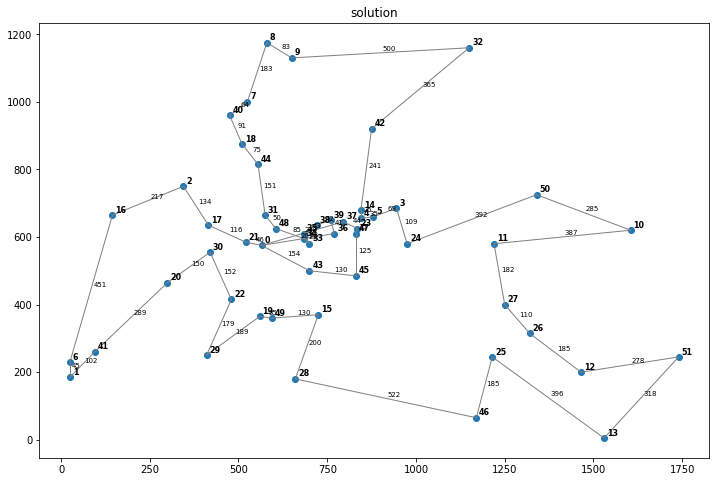

In [35]:
show_route(best_chromosome)

In [141]:
# BAYG29

n = 29
print('Problem size: %d' % n)

coords = np.array([1150.0, 1760.0, 630.0, 1660.0, 40.0, 2090.0, 750.0, 1100.0, 750.0, 2030.0, 1030.0, 2070.0, 1650.0, 650.0, 1490.0, 1630.0, 790.0, 2260.0, 840.0, 550.0, 1170.0, 2300.0, 970.0, 1340.0, 510.0, 700.0, 750.0, 900.0, 1280.0, 1200.0, 230.0, 590.0, 460.0, 860.0, 1040.0, 950.0, 590.0, 1390.0, 830.0, 1770.0, 490.0, 500.0, 1840.0, 1240.0, 1260.0, 1500.0, 1260.0, 1500.0, 1280.0, 790.0, 490.0, 2130.0, 1460.0, 1420.0, 1260.0, 1910.0, 360.0, 1980.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
X =["97 205 139  86  60 220  65 111 115 227  95  82 225 168 103 266 205 149 120  58 257 152  52 180 136  82  34 145",
"129 103  71 105 258 154 112  65 204 150  87 176 137 142 204 148 148  49  41 211 226 116 197  89 153 124  74",
"219 125 175 386 269 134 184 313 201 215 267 248 271 274 236 272 160 151 300 350 239 322  78 276 220  60",
"167 182 180 162 208  39 102 227  60  86  34  96 129  69  58  60 120 119 192 114 110 192 136 173 173",
"51 296 150  42 131 268  88 131 245 201 175 275 218 202 119  50 281 238 131 244  51 166  95  69",
"279 114  56 150 278  46 133 266 214 162 302 242 203 146  67 300 205 111 238  98 139  52 120",
"178 328 206 147 308 172 203 165 121 251 216 122 231 249 209 111 169  72 338 144 237 331",
"169 151 227 133 104 242 182  84 290 230 146 165 121 270  91  48 158 200  39  64 210",
"172 309  68 169 286 242 208 315 259 240 160  90 322 260 160 281  57 192 107  90",
"140 195  51 117  72 104 153  93  88  25  85 152 200 104 139 154 134 149 135",
"320 146  64  68 143 106  88  81 159 219  63 216 187  88 293 191 258 272",
"174 311 258 196 347 288 243 192 113 345 222 144 274 124 165  71 153",
"144  86  57 189 128  71  71  82 176 150  56 114 168  83 115 160",
"61 165  51  32 105 127 201  36 254 196 136 260 212 258 234",
"106 110  56  49  91 153  91 197 136  94 225 151 201 205",
"215 159  64 126 128 190  98  53  78 218  48 127 214",
"61 155 157 235  47 305 243 186 282 261 300 252",
"105 100 176  66 253 183 146 231 203 239 204",
"113 152 127 150 106  52 235 112 179 221",
"79 163 220 119 164 135 152 153 114",
"236 201  90 195  90 127  84  91",
"273 226 148 296 238 291 269",
"112 130 286  74 155 291",
"130 178  38  75 180",
"281 120 205 270",
"213 145  36",
"94 217",
"162"]

X = [[int(k) for k in x.split(' ') if k] for x in X]
for i, l in enumerate(X):
    print(l)
    for j, v in enumerate(l):
        if v != 0:
            A[i, j + i + 1] = v
            A[j + i + 1, i] = v


print('Distance matrix:\n', A)

p = [x-1 for x in [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13, 24]]
print('Optimal solution:\n', p)
print(tsp_objective_function(p))

Problem size: 29
[97, 205, 139, 86, 60, 220, 65, 111, 115, 227, 95, 82, 225, 168, 103, 266, 205, 149, 120, 58, 257, 152, 52, 180, 136, 82, 34, 145]
[129, 103, 71, 105, 258, 154, 112, 65, 204, 150, 87, 176, 137, 142, 204, 148, 148, 49, 41, 211, 226, 116, 197, 89, 153, 124, 74]
[219, 125, 175, 386, 269, 134, 184, 313, 201, 215, 267, 248, 271, 274, 236, 272, 160, 151, 300, 350, 239, 322, 78, 276, 220, 60]
[167, 182, 180, 162, 208, 39, 102, 227, 60, 86, 34, 96, 129, 69, 58, 60, 120, 119, 192, 114, 110, 192, 136, 173, 173]
[51, 296, 150, 42, 131, 268, 88, 131, 245, 201, 175, 275, 218, 202, 119, 50, 281, 238, 131, 244, 51, 166, 95, 69]
[279, 114, 56, 150, 278, 46, 133, 266, 214, 162, 302, 242, 203, 146, 67, 300, 205, 111, 238, 98, 139, 52, 120]
[178, 328, 206, 147, 308, 172, 203, 165, 121, 251, 216, 122, 231, 249, 209, 111, 169, 72, 338, 144, 237, 331]
[169, 151, 227, 133, 104, 242, 182, 84, 290, 230, 146, 165, 121, 270, 91, 48, 158, 200, 39, 64, 210]
[172, 309, 68, 169, 286, 242, 208, 315, 

<Figure size 864x576 with 0 Axes>

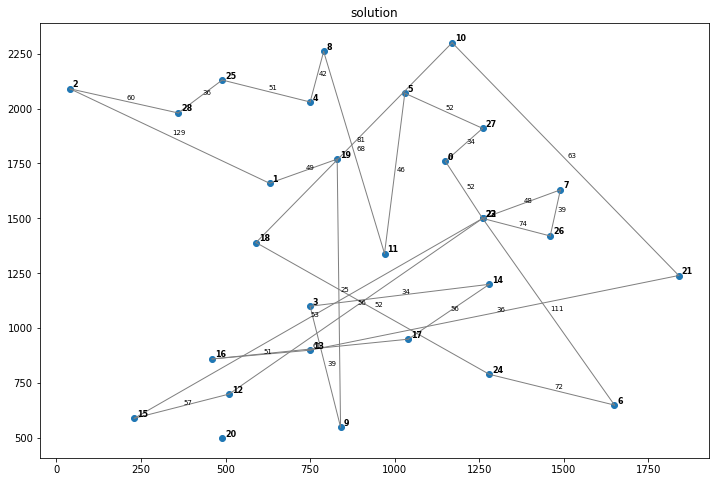

In [144]:
show_route(p)

In [142]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, mutation_probability=0.50)

  0     0.38669753 3554.00000000 4436.29100000 4723.00000000 217.18756023
  1     0.60374975 3544.00000000 4207.06400000 4443.00000000 183.36744505
  2     0.81819963 3290.00000000 4036.72700000 4251.00000000 166.56753126
  3     1.03172445 2998.00000000 3906.24200000 4103.00000000 158.08040813
  4     1.24612093 2998.00000000 3793.96000000 3985.00000000 160.08658407
  5     1.46780276 2850.00000000 3682.37500000 3873.00000000 163.94269845
  6     1.67943859 2842.00000000 3576.32300000 3766.00000000 162.60784320
  7     1.88541794 2658.00000000 3478.62600000 3675.00000000 163.98626200
  8     2.09095836 2658.00000000 3383.48200000 3575.00000000 159.07449097
  9     2.30144811 2658.00000000 3299.07500000 3480.00000000 149.90141886
 10     2.51599741 2620.00000000 3214.28300000 3395.00000000 146.21040630
 11     2.72569537 2492.00000000 3127.25700000 3304.00000000 141.07467154
 12     2.93525839 2492.00000000 3041.99500000 3215.00000000 139.51534315
 13     3.13734365 2340.00000000 2945.

111    22.20113397 1630.00000000 1630.00000000 1630.00000000   0.00000000
112    22.35490394 1630.00000000 1630.00000000 1630.00000000   0.00000000
113    22.51521707 1630.00000000 1630.00000000 1630.00000000   0.00000000
114    22.66829252 1630.00000000 1630.00000000 1630.00000000   0.00000000
115    22.81937790 1630.00000000 1630.00000000 1630.00000000   0.00000000
116    22.97730422 1630.00000000 1630.00000000 1630.00000000   0.00000000
117    23.13335371 1630.00000000 1630.00000000 1630.00000000   0.00000000
118    23.28538036 1630.00000000 1630.00000000 1630.00000000   0.00000000
119    23.44834614 1630.00000000 1630.00000000 1630.00000000   0.00000000
120    23.60934472 1630.00000000 1630.00000000 1630.00000000   0.00000000
121    23.76619697 1630.00000000 1630.00000000 1630.00000000   0.00000000
122    23.91598082 1630.00000000 1630.00000000 1630.00000000   0.00000000
123    24.06891990 1630.00000000 1630.00000000 1630.00000000   0.00000000
124    24.22217155 1630.00000000 1630.

222    42.21694207 1630.00000000 1630.00000000 1630.00000000   0.00000000
223    42.47212172 1630.00000000 1630.00000000 1630.00000000   0.00000000
224    42.67007422 1630.00000000 1630.00000000 1630.00000000   0.00000000
225    42.83232832 1630.00000000 1630.00000000 1630.00000000   0.00000000
226    42.98597765 1630.00000000 1630.00000000 1630.00000000   0.00000000
227    43.14169240 1630.00000000 1630.00000000 1630.00000000   0.00000000
228    43.29595304 1630.00000000 1630.00000000 1630.00000000   0.00000000
229    43.45881820 1630.00000000 1630.00000000 1630.00000000   0.00000000
230    43.60885334 1630.00000000 1630.00000000 1630.00000000   0.00000000
231    43.76373553 1630.00000000 1630.00000000 1630.00000000   0.00000000
232    43.91960287 1630.00000000 1630.00000000 1630.00000000   0.00000000
233    44.07870531 1630.00000000 1630.00000000 1630.00000000   0.00000000
234    44.22714162 1630.00000000 1630.00000000 1630.00000000   0.00000000
235    44.38205099 1630.00000000 1630.

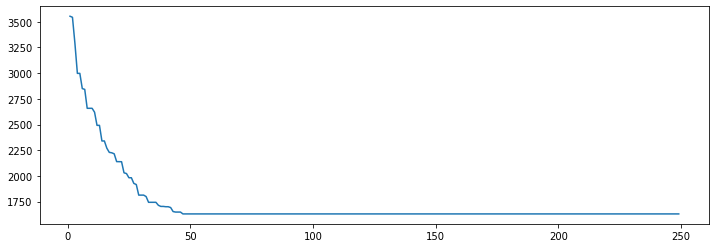

In [145]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [146]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, cross_operator=OX, mutation_probability=0.50)

  0     0.27331185 3530.00000000 4425.55800000 4706.00000000 211.22169073
  1     0.43533301 3420.00000000 4188.90300000 4426.00000000 183.75683822
  2     0.60442805 3153.00000000 3999.79300000 4214.00000000 173.60658441
  3     0.77524757 3153.00000000 3839.91600000 4044.00000000 159.33943939
  4     0.94055891 3129.00000000 3698.77900000 3883.00000000 143.90110548
  5     1.10149741 3030.00000000 3582.15500000 3755.00000000 140.38350678
  6     1.26872468 2873.00000000 3477.11100000 3640.00000000 131.39969056
  7     1.43254948 2873.00000000 3381.92200000 3542.00000000 127.01875419
  8     1.59689927 2583.00000000 3291.24500000 3443.00000000 120.55706937
  9     1.76621914 2574.00000000 3209.30400000 3354.00000000 124.65982346
 10     1.93255329 2549.00000000 3123.61900000 3272.00000000 133.47554023
 11     2.09239602 2535.00000000 3030.18000000 3189.00000000 136.18938138
 12     2.25700045 2526.00000000 2940.00400000 3091.00000000 127.78339479
 13     2.41864014 2468.00000000 2867.

111    19.15424418 1622.00000000 1622.00000000 1622.00000000   0.00000000
112    19.31684494 1622.00000000 1622.00000000 1622.00000000   0.00000000
113    19.47880197 1622.00000000 1622.00000000 1622.00000000   0.00000000
114    19.65234447 1622.00000000 1622.00000000 1622.00000000   0.00000000
115    19.81501961 1622.00000000 1622.00000000 1622.00000000   0.00000000
116    19.97952986 1622.00000000 1622.00000000 1622.00000000   0.00000000
117    20.14704347 1622.00000000 1622.00000000 1622.00000000   0.00000000
118    20.30975318 1622.00000000 1622.00000000 1622.00000000   0.00000000
119    20.47328305 1622.00000000 1622.00000000 1622.00000000   0.00000000
120    20.64590454 1622.00000000 1622.00000000 1622.00000000   0.00000000
121    20.81349325 1622.00000000 1622.00000000 1622.00000000   0.00000000
122    20.97463608 1622.00000000 1622.00000000 1622.00000000   0.00000000
123    21.14200664 1622.00000000 1622.00000000 1622.00000000   0.00000000
124    21.30445743 1622.00000000 1622.

222    37.64429164 1622.00000000 1622.00000000 1622.00000000   0.00000000
223    37.80995679 1622.00000000 1622.00000000 1622.00000000   0.00000000
224    37.97711563 1622.00000000 1622.00000000 1622.00000000   0.00000000
225    38.13933825 1622.00000000 1622.00000000 1622.00000000   0.00000000
226    38.30236292 1622.00000000 1622.00000000 1622.00000000   0.00000000
227    38.46158528 1622.00000000 1622.00000000 1622.00000000   0.00000000
228    38.62788010 1622.00000000 1622.00000000 1622.00000000   0.00000000
229    38.80717826 1622.00000000 1622.00000000 1622.00000000   0.00000000
230    38.97273183 1622.00000000 1622.00000000 1622.00000000   0.00000000
231    39.13353014 1622.00000000 1622.00000000 1622.00000000   0.00000000
232    39.29820013 1622.00000000 1622.00000000 1622.00000000   0.00000000
233    39.45810223 1622.00000000 1622.00000000 1622.00000000   0.00000000
234    39.62601113 1622.00000000 1622.00000000 1622.00000000   0.00000000
235    39.80417514 1622.00000000 1622.

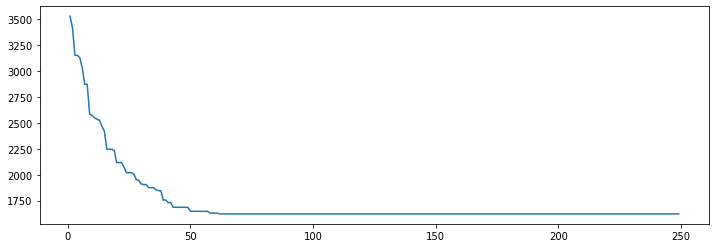

In [147]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [148]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, cross_operator=CX, mutation_probability=0.50)

  0     0.27466249 3507.00000000 4425.12100000 4683.00000000 197.24245577
  1     0.44111490 3408.00000000 4230.43200000 4469.00000000 189.01448986
  2     0.73740244 3203.00000000 4070.46700000 4283.00000000 183.22247927
  3     0.89855337 3203.00000000 3922.44600000 4129.00000000 169.27229272
  4     1.12374711 3173.00000000 3799.46600000 3999.00000000 159.39408660
  5     1.34750509 3025.00000000 3687.11400000 3875.00000000 141.47393754
  6     1.50963092 3025.00000000 3596.74000000 3759.00000000 133.14258673
  7     1.66053700 3003.00000000 3512.17300000 3683.00000000 131.31160296
  8     1.80778694 3003.00000000 3434.33000000 3590.00000000 123.01332082
  9     1.95337963 2866.00000000 3345.71000000 3497.00000000 114.95084993
 10     2.08850360 2866.00000000 3268.73000000 3408.00000000 110.45758960
 11     2.20349360 2761.00000000 3177.07700000 3309.00000000 104.29822180
 12     2.30658102 2652.00000000 3080.84000000 3213.00000000  96.14285413
 13     2.39790082 2652.00000000 2995.

113     9.08887744 1638.00000000 1638.00000000 1638.00000000   0.00000000
114     9.15139461 1638.00000000 1638.00000000 1638.00000000   0.00000000
115     9.21327686 1638.00000000 1638.00000000 1638.00000000   0.00000000
116     9.27690554 1638.00000000 1638.00000000 1638.00000000   0.00000000
117     9.34102345 1638.00000000 1638.00000000 1638.00000000   0.00000000
118     9.40785074 1638.00000000 1638.00000000 1638.00000000   0.00000000
119     9.48337579 1638.00000000 1638.00000000 1638.00000000   0.00000000
120     9.55201077 1638.00000000 1638.00000000 1638.00000000   0.00000000
121     9.69743276 1638.00000000 1638.00000000 1638.00000000   0.00000000
122     9.91023540 1638.00000000 1638.00000000 1638.00000000   0.00000000
123    10.10223842 1638.00000000 1638.00000000 1638.00000000   0.00000000
124    10.19676423 1638.00000000 1638.00000000 1638.00000000   0.00000000
125    10.39514589 1638.00000000 1638.00000000 1638.00000000   0.00000000
126    10.48624754 1638.00000000 1638.

225    23.34163547 1638.00000000 1638.00000000 1638.00000000   0.00000000
226    23.44695187 1638.00000000 1638.00000000 1638.00000000   0.00000000
227    23.51157880 1638.00000000 1638.00000000 1638.00000000   0.00000000
228    23.57574153 1638.00000000 1638.00000000 1638.00000000   0.00000000
229    23.64024544 1638.00000000 1638.00000000 1638.00000000   0.00000000
230    23.70424414 1638.00000000 1638.00000000 1638.00000000   0.00000000
231    23.76752973 1638.00000000 1638.00000000 1638.00000000   0.00000000
232    23.83127809 1638.00000000 1638.00000000 1638.00000000   0.00000000
233    23.89327145 1638.00000000 1638.00000000 1638.00000000   0.00000000
234    23.95743060 1638.00000000 1638.00000000 1638.00000000   0.00000000
235    24.02039981 1638.00000000 1638.00000000 1638.00000000   0.00000000
236    24.08467221 1638.00000000 1638.00000000 1638.00000000   0.00000000
237    24.14715576 1638.00000000 1638.00000000 1638.00000000   0.00000000
238    24.20883799 1638.00000000 1638.

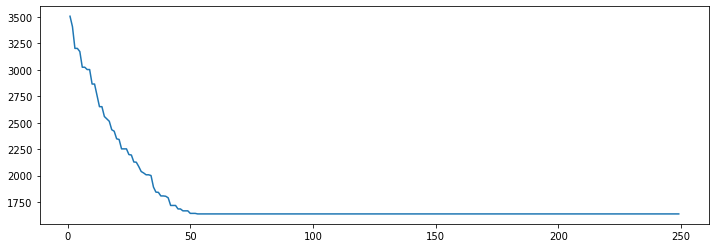

In [149]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [150]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, cross_operator=SWP, mutation_probability=0.35)

  0     0.26179075 3654.00000000 4414.91400000 4703.00000000 216.52327959
  1     0.35460353 3654.00000000 4166.12200000 4377.00000000 166.01257517
  2     0.44680929 3317.00000000 3955.59300000 4137.00000000 137.33895060
  3     0.54204702 3290.00000000 3784.06200000 3941.00000000 100.81758853
  4     0.69788766 3245.00000000 3670.30300000 3771.00000000  92.68010138
  5     0.84869075 3195.00000000 3548.68000000 3657.00000000 104.95938071
  6     0.93853760 3067.00000000 3403.33200000 3527.00000000  82.19083754
  7     1.02725387 2983.00000000 3317.49400000 3415.00000000  71.29192075
  8     1.12317920 2983.00000000 3241.01700000 3317.00000000  65.46989164
  9     1.21812105 2892.00000000 3158.51700000 3245.00000000  61.97925226
 10     1.32922196 2841.00000000 3087.80400000 3167.00000000  55.38925513
 11     1.42474914 2797.00000000 3029.31500000 3091.00000000  51.18155698
 12     1.51830530 2765.00000000 2969.71500000 3024.00000000  43.19907146
 13     1.61319160 2650.00000000 2922.

113    14.86698508 1729.00000000 1729.00000000 1729.00000000   0.00000000
114    14.95775199 1729.00000000 1729.00000000 1729.00000000   0.00000000
115    15.04882073 1729.00000000 1729.00000000 1729.00000000   0.00000000
116    15.14075065 1729.00000000 1729.00000000 1729.00000000   0.00000000
117    15.24090815 1729.00000000 1729.00000000 1729.00000000   0.00000000
118    15.34528708 1729.00000000 1729.00000000 1729.00000000   0.00000000
119    15.43800807 1729.00000000 1729.00000000 1729.00000000   0.00000000
120    15.53175616 1729.00000000 1729.00000000 1729.00000000   0.00000000
121    15.62529922 1729.00000000 1729.00000000 1729.00000000   0.00000000
122    15.71840143 1729.00000000 1729.00000000 1729.00000000   0.00000000
123    15.81125331 1729.00000000 1729.00000000 1729.00000000   0.00000000
124    15.90636635 1729.00000000 1729.00000000 1729.00000000   0.00000000
125    15.99708867 1729.00000000 1729.00000000 1729.00000000   0.00000000
126    16.08971024 1729.00000000 1729.

224    27.53132582 1729.00000000 1729.00000000 1729.00000000   0.00000000
225    27.62221503 1729.00000000 1729.00000000 1729.00000000   0.00000000
226    27.71707988 1729.00000000 1729.00000000 1729.00000000   0.00000000
227    27.81111670 1729.00000000 1729.00000000 1729.00000000   0.00000000
228    27.90320396 1729.00000000 1729.00000000 1729.00000000   0.00000000
229    27.99636531 1729.00000000 1729.00000000 1729.00000000   0.00000000
230    28.08919191 1729.00000000 1729.00000000 1729.00000000   0.00000000
231    28.18044305 1729.00000000 1729.00000000 1729.00000000   0.00000000
232    28.27575803 1729.00000000 1729.00000000 1729.00000000   0.00000000
233    28.36921144 1729.00000000 1729.00000000 1729.00000000   0.00000000
234    28.46070480 1729.00000000 1729.00000000 1729.00000000   0.00000000
235    28.55387211 1729.00000000 1729.00000000 1729.00000000   0.00000000
236    28.64894795 1729.00000000 1729.00000000 1729.00000000   0.00000000
237    28.74341798 1729.00000000 1729.

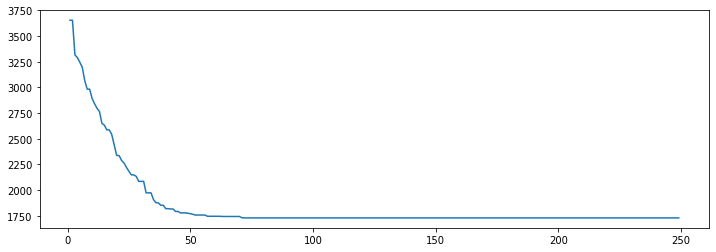

In [151]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [36]:
# BAYS29

n = 29
print('Problem size: %d' % n)

coords = np.array([1150.0, 1760.0, 630.0, 1660.0, 40.0, 2090.0, 750.0, 1100.0, 750.0, 2030.0, 1030.0, 2070.0, 1650.0, 650.0, 1490.0, 1630.0, 790.0, 2260.0, 840.0, 550.0, 1170.0, 2300.0, 970.0, 1340.0, 510.0, 700.0, 750.0, 900.0, 1280.0, 1200.0, 230.0, 590.0, 460.0, 860.0, 1040.0, 950.0, 590.0, 1390.0, 830.0, 1770.0, 490.0, 500.0, 1840.0, 1240.0, 1260.0, 1500.0, 1260.0, 1500.0, 1280.0, 790.0, 490.0, 2130.0, 1460.0, 1420.0, 1260.0, 1910.0, 360.0, 1980.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
x ="0 107 241 190 124  80 316  76 152 157 283 133 113 297 228 129 348 276 188 150  65 341 184  67 221 169 108  45 167-\
 107   0 148 137  88 127 336 183 134  95 254 180 101 234 175 176 265 199 182  67  42 278 271 146 251 105 191 139  79-\
 241 148   0 374 171 259 509 317 217 232 491 312 280 391 412 349 422 356 355 204 182 435 417 292 424 116 337 273  77-\
 190 137 374   0 202 234 222 192 248  42 117 287  79 107  38 121 152  86  68  70 137 151 239 135 137 242 165 228 205-\
 124  88 171 202   0  61 392 202  46 160 319 112 163 322 240 232 314 287 238 155  65 366 300 175 307  57 220 121  97-\
  80 127 259 234  61   0 386 141  72 167 351  55 157 331 272 226 362 296 232 164  85 375 249 147 301 118 188  60 185-\
 316 336 509 222 392 386   0 233 438 254 202 439 235 254 210 187 313 266 154 282 321 298 168 249  95 437 190 314 435-\
  76 183 317 192 202 141 233   0 213 188 272 193 131 302 233  98 344 289 177 216 141 346 108  57 190 245  43  81 243-\
 152 134 217 248  46  72 438 213   0 206 365  89 209 368 286 278 360 333 284 201 111 412 321 221 353  72 266 132 111-\
 157  95 232  42 160 167 254 188 206   0 159 220  57 149  80 132 193 127 100  28  95 193 241 131 169 200 161 189 163-\
 283 254 491 117 319 351 202 272 365 159   0 404 176 106  79 161 165 141  95 187 254 103 279 215 117 359 216 308 322-\
 133 180 312 287 112  55 439 193  89 220 404   0 210 384 325 279 415 349 285 217 138 428 310 200 354 169 241 112 238-\
 113 101 280  79 163 157 235 131 209  57 176 210   0 186 117  75 231 165  81  85  92 230 184  74 150 208 104 158 206-\
 297 234 391 107 322 331 254 302 368 149 106 384 186   0  69 191  59  35 125 167 255  44 309 245 169 327 246 335 288-\
 228 175 412  38 240 272 210 233 286  80  79 325 117  69   0 122 122  56  56 108 175 113 240 176 125 280 177 266 243-\
 129 176 349 121 232 226 187  98 278 132 161 279  75 191 122   0 244 178  66 160 161 235 118  62  92 277  55 155 275-\
 348 265 422 152 314 362 313 344 360 193 165 415 231  59 122 244   0  66 178 198 286  77 362 287 228 358 299 380 319-\
 276 199 356  86 287 296 266 289 333 127 141 349 165  35  56 178  66   0 112 132 220  79 296 232 181 292 233 314 253-\
 188 182 355  68 238 232 154 177 284 100  95 285  81 125  56  66 178 112   0 128 167 169 179 120  69 283 121 213 281-\
 150  67 204  70 155 164 282 216 201  28 187 217  85 167 108 160 198 132 128   0  88 211 269 159 197 172 189 182 135-\
  65  42 182 137  65  85 321 141 111  95 254 138  92 255 175 161 286 220 167  88   0 299 229 104 236 110 149  97 108-\
 341 278 435 151 366 375 298 346 412 193 103 428 230  44 113 235  77  79 169 211 299   0 353 289 213 371 290 379 332-\
 184 271 417 239 300 249 168 108 321 241 279 310 184 309 240 118 362 296 179 269 229 353   0 121 162 345  80 189 342-\
  67 146 292 135 175 147 249  57 221 131 215 200  74 245 176  62 287 232 120 159 104 289 121   0 154 220  41  93 218-\
 221 251 424 137 307 301  95 190 353 169 117 354 150 169 125  92 228 181  69 197 236 213 162 154   0 352 147 247 350-\
 169 105 116 242  57 118 437 245  72 200 359 169 208 327 280 277 358 292 283 172 110 371 345 220 352   0 265 178  39-\
 108 191 337 165 220 188 190  43 266 161 216 241 104 246 177  55 299 233 121 189 149 290  80  41 147 265   0 124 263-\
  45 139 273 228 121  60 314  81 132 189 308 112 158 335 266 155 380 314 213 182  97 379 189  93 247 178 124   0 199-\
 167  79  77 205  97 185 435 243 111 163 322 238 206 288 243 275 319 253 281 135 108 332 342 218 350  39 263 199   0"

for j, row in enumerate(x.split('-')):
    i = 0
    for c in row.strip().split(' '):
        if c != '':
            A[j][i] = int(c)
            i += 1
            if i == 29:
                i = 0
                j += 1

print('Distance matrix:\n', A)

p = [x-1 for x in [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13, 21]]
print('Optimal solution:\n', p)

Problem size: 29
Distance matrix:
 [[  0. 107. 241. 190. 124.  80. 316.  76. 152. 157. 283. 133. 113. 297.
  228. 129. 348. 276. 188. 150.  65. 341. 184.  67. 221. 169. 108.  45.
  167.]
 [107.   0. 148. 137.  88. 127. 336. 183. 134.  95. 254. 180. 101. 234.
  175. 176. 265. 199. 182.  67.  42. 278. 271. 146. 251. 105. 191. 139.
   79.]
 [241. 148.   0. 374. 171. 259. 509. 317. 217. 232. 491. 312. 280. 391.
  412. 349. 422. 356. 355. 204. 182. 435. 417. 292. 424. 116. 337. 273.
   77.]
 [190. 137. 374.   0. 202. 234. 222. 192. 248.  42. 117. 287.  79. 107.
   38. 121. 152.  86.  68.  70. 137. 151. 239. 135. 137. 242. 165. 228.
  205.]
 [124.  88. 171. 202.   0.  61. 392. 202.  46. 160. 319. 112. 163. 322.
  240. 232. 314. 287. 238. 155.  65. 366. 300. 175. 307.  57. 220. 121.
   97.]
 [ 80. 127. 259. 234.  61.   0. 386. 141.  72. 167. 351.  55. 157. 331.
  272. 226. 362. 296. 232. 164.  85. 375. 249. 147. 301. 118. 188.  60.
  185.]
 [316. 336. 509. 222. 392. 386.   0. 233. 438. 254. 2

<Figure size 864x576 with 0 Axes>

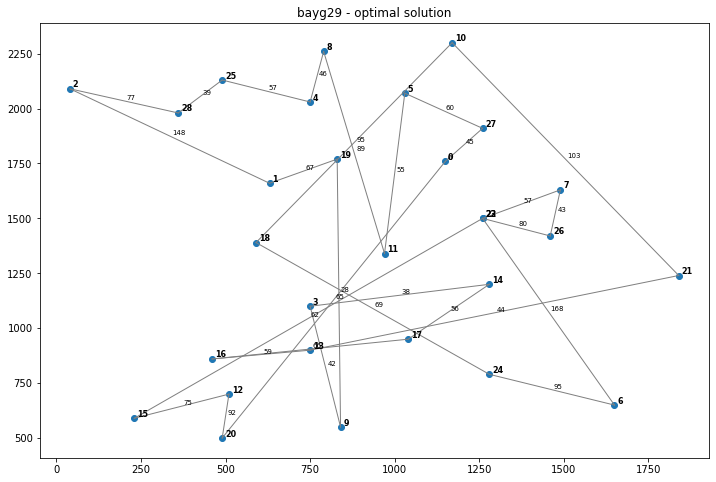

In [231]:
show_route(p)

In [232]:
print(tsp_objective_function(p), p)

2020.0 [0, 27, 5, 11, 8, 4, 25, 28, 2, 1, 19, 9, 3, 14, 17, 16, 13, 21, 10, 18, 24, 6, 22, 26, 7, 23, 15, 12, 20]


In [233]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, mutation_probability=0.50)

  0     0.25421381 4358.00000000 5599.09900000 5946.00000000 260.64386661
  1     0.53535700 4240.00000000 5339.24100000 5626.00000000 237.32374706
  2     0.74150896 3978.00000000 5111.28900000 5391.00000000 230.47767241
  3     0.95975804 3944.00000000 4914.26800000 5184.00000000 225.06214292
  4     1.16809106 3793.00000000 4756.35900000 5009.00000000 211.29402291
  5     1.37386298 3792.00000000 4615.26300000 4858.00000000 195.39006073
  6     1.57564211 3792.00000000 4487.07600000 4708.00000000 184.08819143
  7     1.78408933 3761.00000000 4380.29600000 4597.00000000 176.14621876
  8     1.99958968 3534.00000000 4277.91300000 4487.00000000 169.33956842
  9     2.20397353 3534.00000000 4189.13900000 4390.00000000 163.31836908
 10     2.40517044 3484.00000000 4101.35100000 4304.00000000 150.94117331
 11     2.60693312 3378.00000000 4020.97100000 4215.00000000 141.63844873
 12     2.80705714 3378.00000000 3956.29000000 4126.00000000 131.62128969
 13     3.01261282 3378.00000000 3891.

112    19.65537357 2103.00000000 2103.00000000 2103.00000000   0.00000000
113    19.80139995 2103.00000000 2103.00000000 2103.00000000   0.00000000
114    19.96060157 2103.00000000 2103.00000000 2103.00000000   0.00000000
115    20.10641241 2103.00000000 2103.00000000 2103.00000000   0.00000000
116    20.25706244 2103.00000000 2103.00000000 2103.00000000   0.00000000
117    20.40237379 2103.00000000 2103.00000000 2103.00000000   0.00000000
118    20.55084443 2103.00000000 2103.00000000 2103.00000000   0.00000000
119    20.69738412 2103.00000000 2103.00000000 2103.00000000   0.00000000
120    20.84845042 2103.00000000 2103.00000000 2103.00000000   0.00000000
121    21.01592398 2103.00000000 2103.00000000 2103.00000000   0.00000000
122    21.17692924 2103.00000000 2103.00000000 2103.00000000   0.00000000
123    21.32501340 2103.00000000 2103.00000000 2103.00000000   0.00000000
124    21.47474694 2103.00000000 2103.00000000 2103.00000000   0.00000000
125    21.62512732 2103.00000000 2103.

223    36.68997622 2103.00000000 2103.00000000 2103.00000000   0.00000000
224    36.83611584 2103.00000000 2103.00000000 2103.00000000   0.00000000
225    37.09192753 2103.00000000 2103.00000000 2103.00000000   0.00000000
226    37.37703276 2103.00000000 2103.00000000 2103.00000000   0.00000000
227    37.95268345 2103.00000000 2103.00000000 2103.00000000   0.00000000
228    38.10242987 2103.00000000 2103.00000000 2103.00000000   0.00000000
229    38.25751567 2103.00000000 2103.00000000 2103.00000000   0.00000000
230    38.40358257 2103.00000000 2103.00000000 2103.00000000   0.00000000
231    38.55213356 2103.00000000 2103.00000000 2103.00000000   0.00000000
232    38.70083976 2103.00000000 2103.00000000 2103.00000000   0.00000000
233    38.84874916 2103.00000000 2103.00000000 2103.00000000   0.00000000
234    39.00667214 2103.00000000 2103.00000000 2103.00000000   0.00000000
235    39.15722322 2103.00000000 2103.00000000 2103.00000000   0.00000000
236    39.30318785 2103.00000000 2103.

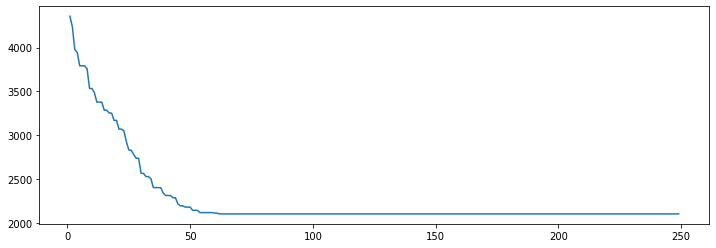

In [234]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [306]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, cross_operator=OX, mutation_probability=0.50)

  0     0.34197021 4348.00000000 5567.29400000 5910.00000000 261.02263420
  1     0.50537086 4333.00000000 5286.35000000 5570.00000000 227.72211465
  2     0.66845083 3958.00000000 5057.34100000 5319.00000000 214.85548799
  3     0.83746529 3896.00000000 4857.35500000 5110.00000000 207.14028332
  4     1.00232649 3867.00000000 4681.87000000 4925.00000000 203.59460970
  5     1.16795444 3761.00000000 4505.19300000 4749.00000000 189.89329570
  6     1.33137751 3693.00000000 4365.73900000 4584.00000000 170.80605048
  7     1.49461174 3446.00000000 4243.18500000 4448.00000000 166.32395731
  8     1.66130471 3446.00000000 4129.23000000 4323.00000000 154.84249772
  9     1.84132695 3397.00000000 4025.04500000 4206.00000000 149.99491650
 10     2.00684190 3307.00000000 3923.34900000 4096.00000000 147.85686051
 11     2.16548324 2905.00000000 3822.68200000 4002.00000000 151.61506810
 12     2.33035827 2905.00000000 3719.23500000 3903.00000000 151.28865052
 13     2.49240899 2905.00000000 3623.

112    21.11375475 2068.00000000 2068.00000000 2068.00000000   0.00000000
113    21.27717614 2068.00000000 2068.00000000 2068.00000000   0.00000000
114    21.43969154 2068.00000000 2068.00000000 2068.00000000   0.00000000
115    21.60253215 2068.00000000 2068.00000000 2068.00000000   0.00000000
116    21.76972318 2068.00000000 2068.00000000 2068.00000000   0.00000000
117    21.94650340 2068.00000000 2068.00000000 2068.00000000   0.00000000
118    22.10931683 2068.00000000 2068.00000000 2068.00000000   0.00000000
119    22.27343464 2068.00000000 2068.00000000 2068.00000000   0.00000000
120    22.43591189 2068.00000000 2068.00000000 2068.00000000   0.00000000
121    22.60004902 2068.00000000 2068.00000000 2068.00000000   0.00000000
122    22.76319313 2068.00000000 2068.00000000 2068.00000000   0.00000000
123    22.93559718 2068.00000000 2068.00000000 2068.00000000   0.00000000
124    23.09862113 2068.00000000 2068.00000000 2068.00000000   0.00000000
125    23.25696850 2068.00000000 2068.

224    41.50989771 2068.00000000 2068.00000000 2068.00000000   0.00000000
225    41.67215681 2068.00000000 2068.00000000 2068.00000000   0.00000000
226    41.84783864 2068.00000000 2068.00000000 2068.00000000   0.00000000
227    42.01108479 2068.00000000 2068.00000000 2068.00000000   0.00000000
228    42.17261982 2068.00000000 2068.00000000 2068.00000000   0.00000000
229    42.33212996 2068.00000000 2068.00000000 2068.00000000   0.00000000
230    42.49425745 2068.00000000 2068.00000000 2068.00000000   0.00000000
231    42.65594411 2068.00000000 2068.00000000 2068.00000000   0.00000000
232    42.82873750 2068.00000000 2068.00000000 2068.00000000   0.00000000
233    42.99319816 2068.00000000 2068.00000000 2068.00000000   0.00000000
234    43.15876341 2068.00000000 2068.00000000 2068.00000000   0.00000000
235    43.32130909 2068.00000000 2068.00000000 2068.00000000   0.00000000
236    43.48638129 2068.00000000 2068.00000000 2068.00000000   0.00000000
237    43.64555645 2068.00000000 2068.

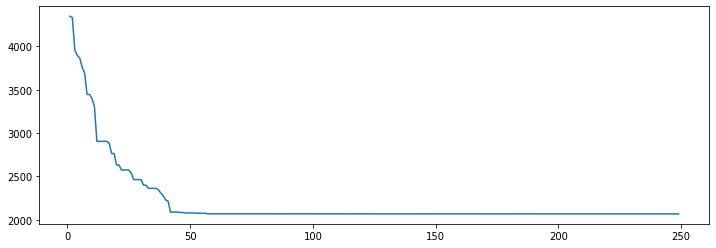

In [307]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [338]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, cross_operator=CX, mutation_probability=0.50)

  0     0.31251192 4525.00000000 5609.55300000 5948.00000000 252.04212979
  1     0.48036718 4340.00000000 5358.95000000 5639.00000000 221.95161522
  2     0.71048260 4282.00000000 5163.41800000 5424.00000000 221.31955014
  3     0.95749021 4114.00000000 4976.53800000 5247.00000000 223.08580537
  4     1.31831956 4114.00000000 4814.21400000 5075.00000000 205.27534242
  5     1.47463012 3913.00000000 4657.01200000 4906.00000000 190.22960825
  6     1.61986947 3751.00000000 4519.70300000 4754.00000000 180.16973883
  7     1.76406789 3719.00000000 4397.48600000 4603.00000000 166.82557899
  8     1.91093206 3632.00000000 4271.08800000 4486.00000000 166.41082373
  9     2.05232596 3632.00000000 4161.67000000 4348.00000000 149.28430962
 10     2.17970610 3522.00000000 4048.42800000 4225.00000000 143.51534000
 11     2.30743933 3522.00000000 3936.65600000 4114.00000000 130.32467788
 12     2.42437387 3405.00000000 3832.28500000 3993.00000000  99.24063570
 13     2.52717018 3405.00000000 3759.

111    11.00643396 2045.00000000 2045.00000000 2045.00000000   0.00000000
112    11.17095017 2045.00000000 2045.00000000 2045.00000000   0.00000000
113    11.32334232 2045.00000000 2045.00000000 2045.00000000   0.00000000
114    11.39103150 2045.00000000 2045.00000000 2045.00000000   0.00000000
115    11.45743370 2045.00000000 2045.00000000 2045.00000000   0.00000000
116    11.52196455 2045.00000000 2045.00000000 2045.00000000   0.00000000
117    11.58851433 2045.00000000 2045.00000000 2045.00000000   0.00000000
118    11.65480399 2045.00000000 2045.00000000 2045.00000000   0.00000000
119    11.72182941 2045.00000000 2045.00000000 2045.00000000   0.00000000
120    11.78967285 2045.00000000 2045.00000000 2045.00000000   0.00000000
121    11.86084390 2045.00000000 2045.00000000 2045.00000000   0.00000000
122    11.93548751 2045.00000000 2045.00000000 2045.00000000   0.00000000
123    12.00453234 2045.00000000 2045.00000000 2045.00000000   0.00000000
124    12.07350969 2045.00000000 2045.

224    22.96346855 2045.00000000 2045.00000000 2045.00000000   0.00000000
225    23.02763510 2045.00000000 2045.00000000 2045.00000000   0.00000000
226    23.09046865 2045.00000000 2045.00000000 2045.00000000   0.00000000
227    23.15379691 2045.00000000 2045.00000000 2045.00000000   0.00000000
228    23.21876764 2045.00000000 2045.00000000 2045.00000000   0.00000000
229    23.29735279 2045.00000000 2045.00000000 2045.00000000   0.00000000
230    23.36240554 2045.00000000 2045.00000000 2045.00000000   0.00000000
231    23.42742467 2045.00000000 2045.00000000 2045.00000000   0.00000000
232    23.49113321 2045.00000000 2045.00000000 2045.00000000   0.00000000
233    23.55435634 2045.00000000 2045.00000000 2045.00000000   0.00000000
234    23.61790347 2045.00000000 2045.00000000 2045.00000000   0.00000000
235    23.68519616 2045.00000000 2045.00000000 2045.00000000   0.00000000
236    23.74925852 2045.00000000 2045.00000000 2045.00000000   0.00000000
237    23.81403565 2045.00000000 2045.

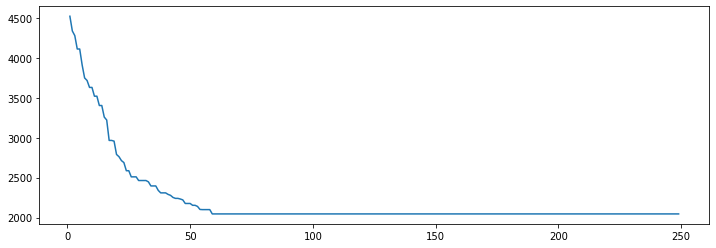

In [339]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [37]:
chromosome_length = 29
SGA(population_size=1000, crossover_probability=0.95, cross_operator=SWP, mutation_probability=0.35)

  0     0.14307928 4477.00000000 5550.73500000 5898.00000000 273.63994002
  1     0.23494935 4207.00000000 5202.88800000 5494.00000000 223.56103296
  2     0.32524419 4084.00000000 4922.26000000 5144.00000000 187.13543865
  3     0.41869688 4084.00000000 4682.96500000 4881.00000000 149.88817090
  4     0.50859356 3883.00000000 4505.56300000 4666.00000000 159.59418545
  5     0.60311699 3833.00000000 4293.23400000 4477.00000000 141.13003665
  6     0.69783854 3823.00000000 4136.10000000 4210.00000000  87.57632100
  7     0.78968167 3648.00000000 4012.85500000 4107.00000000  84.50319506
  8     0.88186765 3648.00000000 3908.47800000 4013.00000000  70.95585611
  9     0.97516179 3592.00000000 3838.09400000 3895.00000000  58.58859244
 10     1.06703949 3534.00000000 3763.41300000 3848.00000000  68.81026399
 11     1.16024160 3371.00000000 3684.02000000 3744.00000000  43.88944748
 12     1.25496697 3354.00000000 3632.16300000 3691.00000000  48.53772173
 13     1.34744692 3247.00000000 3578.

112    11.10409737 2065.00000000 2065.00000000 2065.00000000   0.00000000
113    11.19524455 2065.00000000 2065.00000000 2065.00000000   0.00000000
114    11.28665781 2065.00000000 2065.00000000 2065.00000000   0.00000000
115    11.37994599 2065.00000000 2065.00000000 2065.00000000   0.00000000
116    11.47103238 2065.00000000 2065.00000000 2065.00000000   0.00000000
117    11.64769697 2065.00000000 2065.00000000 2065.00000000   0.00000000
118    11.80785847 2065.00000000 2065.00000000 2065.00000000   0.00000000
119    11.97611117 2065.00000000 2065.00000000 2065.00000000   0.00000000
120    12.14754248 2065.00000000 2065.00000000 2065.00000000   0.00000000
121    12.31772947 2065.00000000 2065.00000000 2065.00000000   0.00000000
122    12.48017359 2065.00000000 2065.00000000 2065.00000000   0.00000000
123    12.63308525 2065.00000000 2065.00000000 2065.00000000   0.00000000
124    12.77314305 2065.00000000 2065.00000000 2065.00000000   0.00000000
125    12.90916109 2065.00000000 2065.

225    24.73123074 2065.00000000 2065.00000000 2065.00000000   0.00000000
226    24.82234883 2065.00000000 2065.00000000 2065.00000000   0.00000000
227    24.91452050 2065.00000000 2065.00000000 2065.00000000   0.00000000
228    25.00745583 2065.00000000 2065.00000000 2065.00000000   0.00000000
229    25.10155559 2065.00000000 2065.00000000 2065.00000000   0.00000000
230    25.19325614 2065.00000000 2065.00000000 2065.00000000   0.00000000
231    25.28523540 2065.00000000 2065.00000000 2065.00000000   0.00000000
232    25.37743235 2065.00000000 2065.00000000 2065.00000000   0.00000000
233    25.46766472 2065.00000000 2065.00000000 2065.00000000   0.00000000
234    25.55965614 2065.00000000 2065.00000000 2065.00000000   0.00000000
235    25.66400671 2065.00000000 2065.00000000 2065.00000000   0.00000000
236    25.75476265 2065.00000000 2065.00000000 2065.00000000   0.00000000
237    25.84579539 2065.00000000 2065.00000000 2065.00000000   0.00000000
238    25.93811464 2065.00000000 2065.

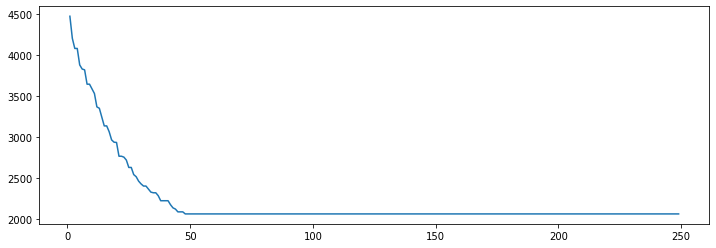

In [38]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [24]:
# KROA100

n = 100
print('Problem size: %d' % n)

coords = np.array([1380, 939, 2848, 96, 3510, 1671, 457, 334, 3888, 666, 984, 965, 2721, 1482, 1286, 525, 2716, 1432, 738, 1325, 1251, 1832, 2728, 1698, 3815, 169, 3683, 1533, 1247, 1945, 123, 862, 1234, 1946, 252, 1240, 611, 673, 2576, 1676, 928, 1700, 53, 857, 1807, 1711, 274, 1420, 2574, 946, 178, 24, 2678, 1825, 1795, 962, 3384, 1498, 3520, 1079, 1256, 61, 1424, 1728, 3913, 192, 3085, 1528, 2573, 1969, 463, 1670, 3875, 598, 298, 1513, 3479, 821, 2542, 236, 3955, 1743, 1323, 280, 3447, 1830, 2936, 337, 1621, 1830, 3373, 1646, 1393, 1368, 3874, 1318, 938, 955, 3022, 474, 2482, 1183, 3854, 923, 376, 825, 2519, 135, 2945, 1622, 953, 268, 2628, 1479, 2097, 981, 890, 1846, 2139, 1806, 2421, 1007, 2290, 1810, 1115, 1052, 2588, 302, 327, 265, 241, 341, 1917, 687, 2991, 792, 2573, 599, 19, 674, 3911, 1673, 872, 1559, 2863, 558, 929, 1766, 839, 620, 3893, 102, 2178, 1619, 3822, 899, 378, 1048, 1178, 100, 2599, 901, 3416, 143, 2961, 1605, 611, 1384, 3113, 885, 2597, 1830, 2586, 1286, 161, 906, 1429, 134, 742, 1025, 1625, 1651, 1187, 706, 1787, 1009, 22, 987, 3640, 43, 3756, 882, 776, 392, 1724, 1642, 198, 1810, 3950, 1558])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)
                  
p = [x-1 for x in [1, 47, 93, 28, 67, 58, 61, 51, 87, 25, 81, 69, 64, 40, 54, 2, 44, 50, 73, 68, 85, 82, 95, 13, 76, 33, 37, 5, 52, 78, 96, 39, 30, 48, 100, 41, 71, 14, 3, 43, 46, 29, 34, 83, 55, 7, 9, 57, 20, 12, 27, 86, 35, 62, 60, 77, 23, 98, 91, 45, 32, 11, 15, 17, 59, 74, 21, 72, 10, 84, 36, 99, 38, 24, 18, 79, 53, 88, 16, 94, 22, 70, 66, 26, 65, 4, 97, 56, 80, 31, 89, 42, 8, 92, 75, 19, 90, 49, 6, 63]]
print('Optimal solution:\n', p)

Problem size: 100
Distance matrix:
 [[   0.         1692.82987923 2252.27085405 ...  782.65254104
  1468.2523625  2643.49408927]
 [1692.82987923    0.         1708.46978317 ... 1911.41099714
  3155.99366286 1830.8052873 ]
 [2252.27085405 1708.46978317    0.         ... 1786.23542681
  3314.91553437  454.27854891]
 ...
 [ 782.65254104 1911.41099714 1786.23542681 ...    0.
  1535.21985396 2227.58434184]
 [1468.2523625  3155.99366286 3314.91553437 ... 1535.21985396
     0.         3760.45316418]
 [2643.49408927 1830.8052873   454.27854891 ... 2227.58434184
  3760.45316418    0.        ]]
Optimal solution:
 [0, 46, 92, 27, 66, 57, 60, 50, 86, 24, 80, 68, 63, 39, 53, 1, 43, 49, 72, 67, 84, 81, 94, 12, 75, 32, 36, 4, 51, 77, 95, 38, 29, 47, 99, 40, 70, 13, 2, 42, 45, 28, 33, 82, 54, 6, 8, 56, 19, 11, 26, 85, 34, 61, 59, 76, 22, 97, 90, 44, 31, 10, 14, 16, 58, 73, 20, 71, 9, 83, 35, 98, 37, 23, 17, 78, 52, 87, 15, 93, 21, 69, 65, 25, 64, 3, 96, 55, 79, 30, 88, 41, 7, 91, 74, 18, 89, 48, 5, 62

<Figure size 864x576 with 0 Axes>

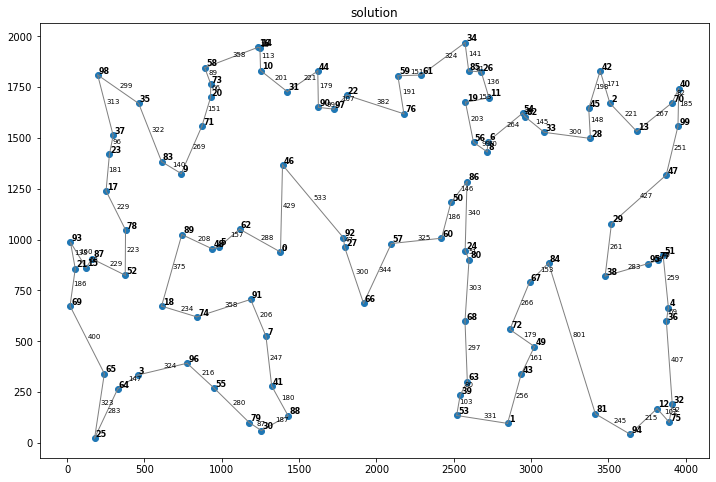

In [246]:
show_route(p)

In [237]:
print(tsp_objective_function(p), p)

21285.44318157108 [0, 46, 92, 27, 66, 57, 60, 50, 86, 24, 80, 68, 63, 39, 53, 1, 43, 49, 72, 67, 84, 81, 94, 12, 75, 32, 36, 4, 51, 77, 95, 38, 29, 47, 99, 40, 70, 13, 2, 42, 45, 28, 33, 82, 54, 6, 8, 56, 19, 11, 26, 85, 34, 61, 59, 76, 22, 97, 90, 44, 31, 10, 14, 16, 58, 73, 20, 71, 9, 83, 35, 98, 37, 23, 17, 78, 52, 87, 15, 93, 21, 69, 65, 25, 64, 3, 96, 55, 79, 30, 88, 41, 7, 91, 74, 18, 89, 48, 5, 62]


In [254]:
chromosome_length = 100
SGA(population_size=1000, crossover_probability=0.90, mutation_probability=0.45, number_of_iterations=500)

  0     0.74862790 143270.74510480 163543.24680976 170198.00973769 5023.59327322
  1     1.34225845 139631.98484785 158237.82718803 163781.55071875 4285.92433215
  2     1.95078874 134497.00845073 153967.23687735 158914.63439597 4020.44872345
  3     2.53580809 131742.06914984 150190.08627259 155088.10624556 3982.87641626
  4     3.13634992 130512.55450700 147043.85938401 151676.21905544 3894.68987954
  5     3.72912645 127942.46058016 144083.40189744 148688.48512976 3753.19671871
  6     4.34644318 127387.50562033 141655.58794279 145922.91436824 3536.46985446
  7     4.94831085 124808.15199397 139219.36417216 143431.17575748 3485.72823741
  8     5.52537704 116630.77180832 137053.15793465 141147.35927261 3421.75182679
  9     6.11845112 116630.77180832 134987.95620204 138972.79124905 3294.00624410
 10     6.69017863 116630.77180832 132946.59950498 136859.52030125 3267.67782810
 11     7.27747893 115406.70614620 131043.27076048 135091.74576899 3197.09984033
 12     7.86411572 114376.53

104    56.19791341 52247.59453707 55357.96740069 56227.70517348 772.81735906
105    56.65932393 52092.21780901 54857.74934362 55823.05007995 812.37604401
106    57.13529325 51395.90302305 54299.44308627 55315.32679752 794.37208699
107    57.59293532 51327.05833620 53850.99735248 54831.25708897 739.66555515
108    58.07841134 50938.71448913 53355.20957145 54267.43630320 681.50737005
109    58.52959561 49743.94796237 52928.08596832 53793.73695071 669.05137089
110    58.99043202 49743.94796237 52487.77821196 53377.71059113 657.49887811
111    59.43869495 48835.90134501 52025.91461806 52809.73329386 642.44736767
112    59.91518259 48717.57568060 51592.54434490 52379.66856185 673.02384275
113    60.35881543 48014.32765087 51101.07562123 51942.12004845 694.84376887
114    60.80673671 46410.77399595 50633.37915778 51442.65740833 672.54409825
115    61.26737571 45798.72438055 50203.34262925 51055.63003631 635.61839395
116    61.71743035 45091.78716705 49806.56331385 50612.13161407 665.69421969

211   102.36911011 26542.24968885 27009.94664270 27232.57933817 160.18271304
212   102.82956648 26322.49995417 26924.41678000 27132.56657449 144.54052697
213   103.27136016 26322.49995417 26849.05536457 27019.52956498 159.95616304
214   103.71343327 26322.49995417 26726.94167722 26990.99130649 125.02639970
215   104.16255403 26322.49995417 26643.92163143 26798.80351244 104.75469873
216   104.56119251 26319.53464635 26550.29823745 26616.56136080  65.48158051
217   104.97741032 26242.26817098 26488.07041002 26575.16754993  77.60406498
218   105.36550522 26242.26817098 26417.01425101 26542.24968885  71.86737195
219   105.75439239 26242.26817098 26365.56371414 26391.08916549  26.68159110
220   106.17072153 26193.40259373 26344.35360820 26379.07305415  35.31073583
221   106.55366826 26056.46129089 26309.22438126 26336.35229831  28.93135811
222   106.95597911 26056.46129089 26285.73315148 26322.49995417  40.62788852
223   107.35369992 25932.68617929 26246.28472096 26298.84127096  39.02983707

318   146.13123846 22615.25610946 22615.25610946 22615.25610946   0.00000000
319   146.52519989 22615.25610946 22615.25610946 22615.25610946   0.00000000
320   146.93309712 22615.25610946 22615.25610946 22615.25610946   0.00000000
321   147.31502748 22615.25610946 22615.25610946 22615.25610946   0.00000000
322   147.72738099 22615.25610946 22615.25610946 22615.25610946   0.00000000
323   148.12931538 22615.25610946 22615.25610946 22615.25610946   0.00000000
324   148.51917124 22615.25610946 22615.25610946 22615.25610946   0.00000000
325   148.92205572 22615.25610946 22615.25610946 22615.25610946   0.00000000
326   149.31909776 22615.25610946 22615.25610946 22615.25610946   0.00000000
327   149.72060609 22615.25610946 22615.25610946 22615.25610946   0.00000000
328   150.12350488 22615.25610946 22615.25610946 22615.25610946   0.00000000
329   150.84843326 22615.25610946 22615.25610946 22615.25610946   0.00000000
330   151.23831725 22615.25610946 22615.25610946 22615.25610946   0.00000000

425   189.65013337 22615.25610946 22615.25610946 22615.25610946   0.00000000
426   190.06232119 22615.25610946 22615.25610946 22615.25610946   0.00000000
427   190.46008635 22615.25610946 22615.25610946 22615.25610946   0.00000000
428   190.86583066 22615.25610946 22615.25610946 22615.25610946   0.00000000
429   191.25781059 22615.25610946 22615.25610946 22615.25610946   0.00000000
430   191.65458250 22615.25610946 22615.25610946 22615.25610946   0.00000000
431   192.06244874 22615.25610946 22615.25610946 22615.25610946   0.00000000
432   192.45416689 22615.25610946 22615.25610946 22615.25610946   0.00000000
433   192.85978961 22615.25610946 22615.25610946 22615.25610946   0.00000000
434   193.26067996 22615.25610946 22615.25610946 22615.25610946   0.00000000
435   193.65363789 22615.25610946 22615.25610946 22615.25610946   0.00000000
436   194.05576682 22615.25610946 22615.25610946 22615.25610946   0.00000000
437   194.44371390 22615.25610946 22615.25610946 22615.25610946   0.00000000

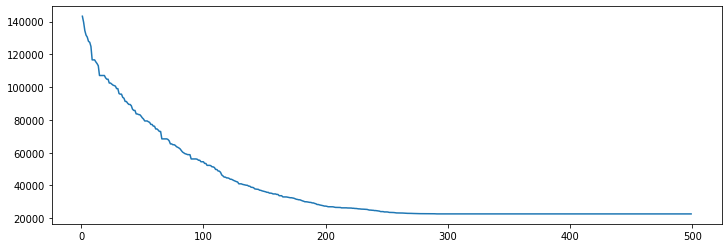

In [255]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [313]:
chromosome_length = 100
SGA(population_size=1000, crossover_probability=0.90, mutation_probability=0.45, number_of_iterations=500, cross_operator=OX)

  0     0.64060473 141273.95623542 162896.67816424 169937.82644008 5287.59152145
  1     1.08975530 140811.35845186 156774.44712569 162619.67310772 4407.59673650
  2     1.58323956 136001.56386666 152225.31943441 157128.16520605 3816.78991816
  3     2.03442502 134970.51225679 148231.25521890 152899.60562916 3606.87852389
  4     2.49414968 131156.96497880 144804.10460206 148973.42073816 3256.68827269
  5     2.94076109 128336.01713040 141824.22830875 145608.83537548 3008.17403662
  6     3.42791319 125436.20171791 139232.15007637 142917.24820341 2941.57208396
  7     3.88396859 118520.74937369 136756.30409060 140347.99124716 2981.82483899
  8     4.34137654 114913.42884466 134292.99450394 137878.55930974 3070.29726367
  9     4.79080439 114913.42884466 131788.29199051 135528.08697153 3087.17556574
 10     5.27715588 114913.42884466 129427.31752039 132985.98327108 3005.65203644
 11     5.72914028 113954.14512331 127145.00699736 130927.16194222 3112.19946277
 12     6.19545746 112251.77

105    48.52619982 50998.81433529 54943.24177580 55883.71858289 818.65188277
106    48.96454573 50683.81578960 54597.85502298 55597.77127849 895.07426710
107    49.41520715 50683.81578960 54256.20396518 55261.45649823 950.31880975
108    49.86622596 50396.60304580 53874.82688348 54876.62259771 1011.42422085
109    50.31906629 50213.43601444 53459.02505686 54719.15679954 1024.44240847
110    50.75823498 49314.51225057 52993.28961878 54270.42949988 985.58820804
111    51.22918510 48606.29956629 52588.22487956 53823.33515446 909.18667199
112    51.67086124 48606.29956629 52193.40876876 53337.10051855 807.80268197
113    52.37007403 47788.44075326 51852.20309227 52939.31247719 751.82111355
114    52.81480598 47788.44075326 51562.36754916 52482.18829006 683.14527290
115    53.28870201 47788.44075326 51288.13935446 52081.72140043 652.09929215
116    53.74430704 47788.44075326 51075.77176052 51844.44986153 658.52188310
117    54.21369338 47788.44075326 50854.86878807 51690.62445042 658.442536

212    97.42024422 31521.80228269 32744.11042844 33077.77820892 324.78564895
213    97.85182977 31521.80228269 32587.46338240 33009.38810855 334.33413216
214    98.30201507 31521.80228269 32452.03775105 32913.29014896 304.63124844
215    98.74814534 31499.13022260 32318.15848200 32729.43844486 275.27769979
216    99.21230841 31453.77728480 32180.26789299 32535.63876044 253.13634384
217    99.65332055 31047.68237554 32053.19129254 32367.67620021 252.78032602
218   100.09937334 31047.68237554 31907.70387341 32228.07680376 224.81181124
219   100.55435014 31047.68237554 31774.88117054 32129.18983874 201.07589444
220   100.99636555 30942.09921169 31658.46025364 31892.94230111 165.07060689
221   101.44736218 30933.48093812 31557.58471529 31799.31105424 135.36303743
222   101.88042092 30624.54951007 31483.97200142 31616.88167777 151.11698792
223   102.33226681 30624.54951007 31382.88356743 31587.02649294 184.70274197
224   102.77223182 30485.26784051 31241.15913594 31488.27419445 177.19207978

319   146.15364838 23438.07816039 23467.22237046 23519.28268688  38.90418379
320   146.59822178 23438.07816039 23438.07816039 23438.07816039   0.00000000
321   147.05074596 23321.15647827 23437.96123871 23438.07816039   3.69553908
322   147.51043797 23242.06357216 23374.35139775 23438.07816039  58.33046654
323   147.96272969 23242.06357216 23320.91678122 23321.15647827   4.32579852
324   148.41784286 23242.06357216 23276.89606856 23321.15647827  39.18113864
325   148.86406851 23204.32349530 23242.02583208 23242.06357216   1.19284915
326   149.31277633 23183.31882569 23221.88936645 23242.06357216  18.85766189
327   149.75669193 23183.31882569 23204.30249063 23204.32349530   0.66389378
328   150.21065307 23183.31882569 23192.31271404 23204.32349530  10.38318799
329   150.65667272 23121.86353953 23183.25737040 23183.31882569   1.94241485
330   151.10817361 23121.86353953 23150.50170288 23183.31882569  30.65651845
331   151.55539107 23121.86353953 23121.86353953 23121.86353953   0.00000000

426   194.95878768 23121.86353953 23121.86353953 23121.86353953   0.00000000
427   195.41458917 23121.86353953 23121.86353953 23121.86353953   0.00000000
428   195.85090399 23121.86353953 23121.86353953 23121.86353953   0.00000000
429   196.31229520 23121.86353953 23121.86353953 23121.86353953   0.00000000
430   196.75076556 23121.86353953 23121.86353953 23121.86353953   0.00000000
431   197.21548820 23121.86353953 23121.86353953 23121.86353953   0.00000000
432   197.66566896 23121.86353953 23121.86353953 23121.86353953   0.00000000
433   198.11503315 23121.86353953 23121.86353953 23121.86353953   0.00000000
434   198.56464958 23121.86353953 23121.86353953 23121.86353953   0.00000000
435   199.00083947 23121.86353953 23121.86353953 23121.86353953   0.00000000
436   199.45670176 23121.86353953 23121.86353953 23121.86353953   0.00000000
437   199.90178394 23121.86353953 23121.86353953 23121.86353953   0.00000000
438   200.36791635 23121.86353953 23121.86353953 23121.86353953   0.00000000

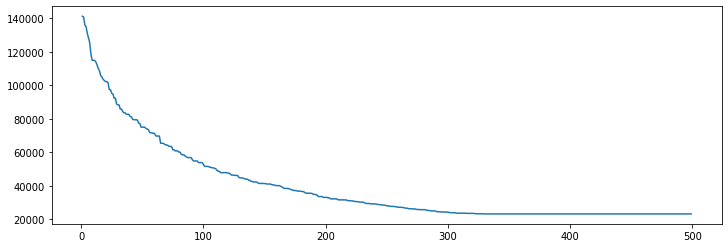

In [314]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

<Figure size 864x576 with 0 Axes>

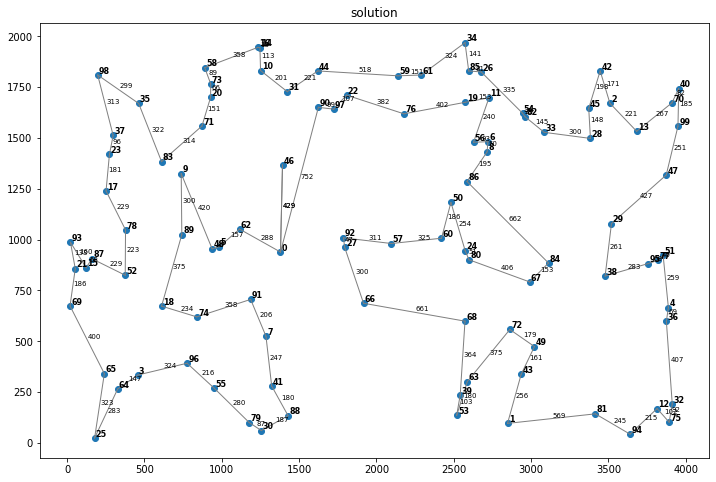

In [315]:
show_route(best_chromosome)

In [341]:
chromosome_length = 100
SGA(population_size=1000, crossover_probability=0.90, mutation_probability=0.45, number_of_iterations=500, cross_operator=CX)

  0     0.61850405 144039.80999704 163703.89018993 170479.78916701 5169.98852619
  1     1.13932467 139112.52597083 158465.70292005 164071.59392785 4423.06095359
  2     1.60992408 138661.66593796 154596.91945536 159616.23771421 4283.35834115
  3     2.07299161 135534.35740666 151160.74395623 156153.92819296 4068.78277331
  4     2.55289149 134919.43125214 148226.55587868 152793.61792802 3790.07787050
  5     3.24369597 129921.13645746 145492.28881486 150174.38460273 3796.67864764
  6     3.71243405 129921.13645746 142925.84414327 147388.34185903 3422.26869132
  7     4.13183427 128906.44210664 140457.21975846 144587.24334860 3037.35068200
  8     4.57146597 125029.90027857 138222.67997493 141898.84828720 2813.07737866
  9     4.97106504 125029.90027857 136122.42830169 139660.20898262 2852.82425251
 10     5.32706094 121817.07721288 133797.63410272 137274.38293408 2825.93335658
 11     5.64706969 121344.73715707 131338.34652548 134717.10162583 2453.17208633
 12     5.90792561 121027.21

106    22.57543921 56257.17003861 57514.32036044 57754.86721225 310.04305809
107    22.71716285 55969.98532517 57171.70009205 57529.78852196 407.89258944
108    22.85847545 55760.96647509 56718.09375724 57308.83325058 395.97044823
109    22.99340081 54943.86276212 56342.28740752 56681.57818699 191.57843145
110    23.27263308 54943.86276212 56212.35690336 56257.17003861 144.08371561
111    23.56893730 53969.17347112 55922.18614319 56257.17003861 357.13557876
112    23.70542097 53969.17347112 55545.44987625 55969.98532517 369.92257291
113    23.87618017 53245.46231235 55188.44942500 55575.70014184 354.33472338
114    24.14810348 53245.46231235 54806.56870858 55137.23065554 311.96381043
115    24.39334249 52873.32801571 54524.96189950 54943.86276212 454.50304167
116    24.61714959 52753.96286087 54002.55527563 54593.00289681 313.01207004
117    24.76666021 52392.23985725 53793.36899656 53969.17347112 321.40655423
118    24.91873431 51688.57449625 53327.52340676 53969.17347112 358.10799887

213    39.49879909 33436.60617051 33856.10564921 34103.33773388 208.90744745
214    39.63424373 32965.57057514 33652.52188183 34002.37956439 186.58979297
215    39.77179027 32965.57057514 33516.83953372 33560.58925037  52.20627847
216    39.90902400 32965.57057514 33464.26156323 33490.14535286  97.25538872
217    40.15879416 32717.06708259 33247.95346748 33490.14535286 233.31578805
218    40.53935552 32458.00022792 33007.62500438 33280.53757588 104.85573725
219    40.98079848 32458.00022792 32958.21534046 32965.57057514  45.24839153
220    41.30426288 32438.13212059 32792.41838186 32965.57057514 192.51069070
221    41.63178968 32273.61437913 32587.35076496 32847.86334543 146.52517840
222    41.94260955 32273.61437913 32458.30922706 32468.47429145  13.79588837
223    42.24646831 32069.39558158 32445.84883948 32458.00022792  42.83460524
224    42.44868016 31765.55200533 32351.97565883 32458.00022792  98.79440666
225    42.59386826 31765.55200533 32250.45915035 32370.03194512  94.08352665

321    57.42800951 23993.00997424 24095.35536843 24166.09106712  71.52701052
322    57.56997013 23823.13024648 24023.05627063 24086.78933721  38.05194567
323    57.70770049 23823.13024648 23992.13244731 23993.00997424  10.11590606
324    57.84103489 23769.67583579 23926.30059918 23993.00997424  66.85870363
325    57.98338199 23730.22078512 23861.41450982 23920.59653930  40.79377910
326    58.11838603 23730.22078512 23823.26201492 23887.57157172   8.03297740
327    58.25512171 23692.70556940 23822.05096832 23823.13024648   8.97588211
328    58.38982582 23525.86992695 23781.28739656 23823.13024648  44.05110892
329    58.54190660 23525.86992695 23736.74333982 23769.67583579  28.60657909
330    58.68220854 23525.86992695 23709.87771326 23730.22078512  38.11388420
331    58.82016373 23525.86992695 23661.01738869 23730.22078512  69.00966694
332    58.95884061 23446.56819704 23599.24946314 23692.70556940  82.40270026
333    59.09606671 23446.56819704 23525.77767154 23525.86992695   2.53930130

429    73.03191566 22127.00324555 22127.00324555 22127.00324555   0.00000000
430    73.16753054 22127.00324555 22127.00324555 22127.00324555   0.00000000
431    73.34997082 22127.00324555 22127.00324555 22127.00324555   0.00000000
432    73.56398129 22127.00324555 22127.00324555 22127.00324555   0.00000000
433    73.70270538 22127.00324555 22127.00324555 22127.00324555   0.00000000
434    73.84094930 22127.00324555 22127.00324555 22127.00324555   0.00000000
435    73.97449732 22127.00324555 22127.00324555 22127.00324555   0.00000000
436    74.13763571 22127.00324555 22127.00324555 22127.00324555   0.00000000
437    74.27529836 22127.00324555 22127.00324555 22127.00324555   0.00000000
438    74.41284585 22127.00324555 22127.00324555 22127.00324555   0.00000000
439    74.55964637 22127.00324555 22127.00324555 22127.00324555   0.00000000
440    74.69758463 22127.00324555 22127.00324555 22127.00324555   0.00000000
441    74.83184791 22127.00324555 22127.00324555 22127.00324555   0.00000000

<Figure size 864x576 with 0 Axes>

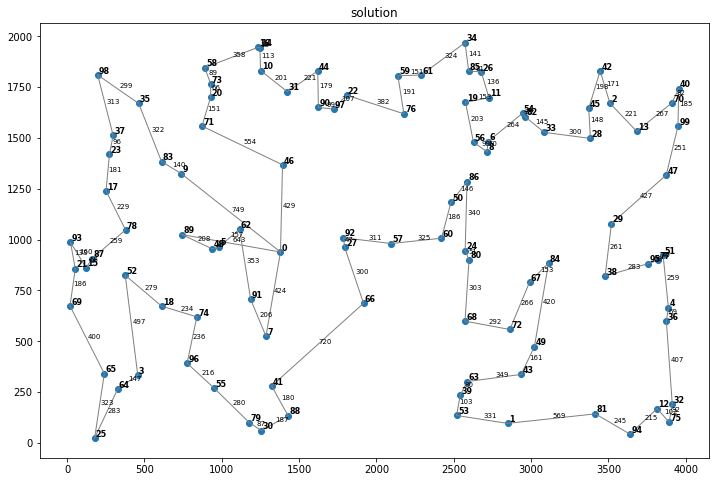

In [342]:
show_route(best_chromosome)

In [25]:
chromosome_length = 100
SGA(population_size=1000, crossover_probability=0.95, mutation_probability=0.35, number_of_iterations=500, cross_operator=SWP)

  0     0.46801829 140372.12531710 162822.07962756 169719.42490250 5316.15131019
  1     0.75027442 140372.12531710 156252.91914937 161574.03339636 4224.78308453
  2     1.06694746 136467.40467072 151012.55365780 155561.00030157 3939.54722237
  3     1.42733335 135234.24140014 145497.31825796 150945.02781519 3973.49487779
  4     1.71367192 134662.14420454 140789.39667957 142982.72836046 1308.31368789
  5     1.99920654 134177.17435276 139481.38226844 140372.12531710 1384.67094257
  6     2.28734827 130160.19556242 136840.21237747 139048.84398215 1348.18937080
  7     2.59851050 126292.19934045 135426.58621361 136467.40467072 998.65137192
  8     3.24639940 124621.47955927 134059.31838619 135234.24140014 1565.11416911
  9     3.54109240 123075.50186653 131378.23917140 134154.30537913 2407.29787078
 10     3.88808393 122560.19582532 128190.46047818 130663.05683713 2033.88568614
 11     4.32947516 121263.00687003 125679.45134350 126943.34561841 930.92364315
 12     4.71664834 119671.3460

105    32.88704872 59830.32386146 61778.05811362 62291.47267384 484.98377103
106    33.17324352 59826.11248077 61240.23081106 61658.63387823 399.52410627
107    33.44980049 58925.49959860 60795.22056920 61377.47588966 448.97734723
108    33.72840309 58925.49959860 60337.20713743 60461.61436746 264.99280255
109    34.00637126 58469.63676843 59833.22699742 60461.61436746 418.47481618
110    34.28412151 58090.01270793 59422.34438528 59830.32386146 406.80889389
111    34.56466627 57171.09390052 58946.58747153 59311.48256631 181.77595414
112    34.84559441 57019.50357951 58817.23824004 58966.04499763 257.19473425
113    35.13214636 55942.99160696 58415.39703654 58925.49959860 441.20474695
114    35.41316652 55879.41850662 57952.49649117 58469.63676843 484.00750068
115    35.69313979 55879.41850662 57380.44079403 58090.01270793 449.93614317
116    36.01111674 55879.41850662 57009.10356126 57171.09390052 350.70997425
117    36.34165025 55158.53897773 56357.43306042 57019.50357951 477.54387505

212    65.72663498 32328.84897257 32779.43081097 32938.58841971  54.30815492
213    66.25103855 32328.84897257 32760.85523127 32769.20315098  55.27769353
214    66.52608585 32147.47901924 32511.24307134 32769.20315098 189.11611518
215    66.79472089 32117.40381144 32342.09184385 32423.83933850  37.32415337
216    67.07910490 32009.69711397 32325.02012413 32328.84897257  25.15395663
217    67.35382676 31830.52808710 32210.76221949 32328.84897257  94.17882871
218    67.63210130 31239.10029924 32116.49317122 32147.47901924  65.37442904
219    68.01972365 31239.10029924 32003.47358858 32147.47901924 133.84288829
220    68.56178951 31107.29935252 31895.92665071 32009.69711397 234.84231412
221    68.83397603 31107.29935252 31483.71548480 31968.23942292 280.74492555
222    69.11530519 30922.14936710 31234.20573223 31239.10029924  24.33441004
223    69.39062381 30771.94245818 31147.58926629 31239.10029924  81.44506477
224    69.67451811 30638.66526954 31073.07800249 31148.74483779  83.23746827

319    99.73831582 23157.59685983 23221.07279077 23345.65543639  88.61956834
320   100.27245212 23157.59685983 23157.59685983 23157.59685983   0.00000000
321   100.54959083 23157.59685983 23157.59685983 23157.59685983   0.00000000
322   100.82469082 23157.59685983 23157.59685983 23157.59685983   0.00000000
323   101.11677241 23157.59685983 23157.59685983 23157.59685983   0.00000000
324   101.39250016 23157.59685983 23157.59685983 23157.59685983   0.00000000
325   101.67192030 23157.59685983 23157.59685983 23157.59685983   0.00000000
326   101.94984007 23157.59685983 23157.59685983 23157.59685983   0.00000000
327   102.23873138 23157.59685983 23157.59685983 23157.59685983   0.00000000
328   102.51244426 23157.59685983 23157.59685983 23157.59685983   0.00000000
329   102.78595924 23157.59685983 23157.59685983 23157.59685983   0.00000000
330   103.07905865 23157.59685983 23157.59685983 23157.59685983   0.00000000
331   103.35436583 23157.59685983 23157.59685983 23157.59685983   0.00000000

426   131.99326253 22451.55227622 22451.55227622 22451.55227622   0.00000000
427   132.27147007 22451.55227622 22451.55227622 22451.55227622   0.00000000
428   132.54875422 22451.55227622 22451.55227622 22451.55227622   0.00000000
429   132.83081317 22451.55227622 22451.55227622 22451.55227622   0.00000000
430   133.11111617 22451.55227622 22451.55227622 22451.55227622   0.00000000
431   133.39692473 22451.55227622 22451.55227622 22451.55227622   0.00000000
432   133.67502141 22451.55227622 22451.55227622 22451.55227622   0.00000000
433   133.95116544 22451.55227622 22451.55227622 22451.55227622   0.00000000
434   134.23556328 22451.55227622 22451.55227622 22451.55227622   0.00000000
435   134.71494555 22451.55227622 22451.55227622 22451.55227622   0.00000000
436   135.21560144 22451.55227622 22451.55227622 22451.55227622   0.00000000
437   135.48966527 22451.55227622 22451.55227622 22451.55227622   0.00000000
438   135.83938241 22451.55227622 22451.55227622 22451.55227622   0.00000000

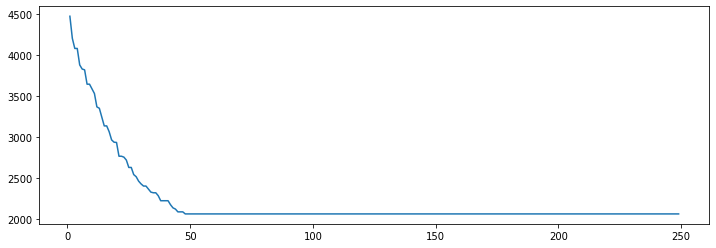

In [39]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [48]:
# KROA150

n = 150
print('Problem size: %d' % n)

coords = np.array([1380, 939, 2848, 96, 3510, 1671, 457, 334, 3888, 666, 984, 965, 2721, 1482, 1286, 525, 2716, 1432, 738, 1325, 1251, 1832, 2728, 1698, 3815, 169, 3683, 1533, 1247, 1945, 123, 862, 1234, 1946, 252, 1240, 611, 673, 2576, 1676, 928, 1700, 53, 857, 1807, 1711, 274, 1420, 2574, 946, 178, 24, 2678, 1825, 1795, 962, 3384, 1498, 3520, 1079, 1256, 61, 1424, 1728, 3913, 192, 3085, 1528, 2573, 1969, 463, 1670, 3875, 598, 298, 1513, 3479, 821, 2542, 236, 3955, 1743, 1323, 280, 3447, 1830, 2936, 337, 1621, 1830, 3373, 1646, 1393, 1368, 3874, 1318, 938, 955, 3022, 474, 2482, 1183, 3854, 923, 376, 825, 2519, 135, 2945, 1622, 953, 268, 2628, 1479, 2097, 981, 890, 1846, 2139, 1806, 2421, 1007, 2290, 1810, 1115, 1052, 2588, 302, 327, 265, 241, 341, 1917, 687, 2991, 792, 2573, 599, 19, 674, 3911, 1673, 872, 1559, 2863, 558, 929, 1766, 839, 620, 3893, 102, 2178, 1619, 3822, 899, 378, 1048, 1178, 100, 2599, 901, 3416, 143, 2961, 1605, 611, 1384, 3113, 885, 2597, 1830, 2586, 1286, 161, 906, 1429, 134, 742, 1025, 1625, 1651, 1187, 706, 1787, 1009, 22, 987, 3640, 43, 3756, 882, 776, 392, 1724, 1642, 198, 1810, 3950, 1558, 3477, 949, 91, 1732, 3972, 329, 198, 1632, 1806, 733, 538, 1023, 3430, 1088, 2186, 766, 1513, 1646, 2143, 1611, 53, 1657, 3404, 1307, 1034, 1344, 2823, 376, 3104, 1931, 3232, 324, 2790, 1457, 374, 9, 741, 146, 3083, 1938, 3502, 1067, 1280, 237, 3326, 1846, 217, 38, 2503, 1172, 3527, 41, 739, 1850, 3548, 1999, 48, 154, 1419, 872, 1689, 1223, 3468, 1404, 1628, 253, 382, 872, 3029, 1242, 3646, 1758, 285, 1029, 1782, 93, 1067, 371, 2849, 1214, 920, 1835, 1741, 712, 876, 220, 2753, 283, 2609, 1286, 3941, 258, 3613, 523, 1754, 559, 2916, 1724, 2445, 1820])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)
                  
p = 26524
print('Optimal solution:\n', p)

Problem size: 150
Distance matrix:
 [[   0.         1692.82987923 2252.27085405 ...  533.17539328
  1724.96985481 1382.16713895]
 [1692.82987923    0.         1708.46978317 ... 1187.94149688
  1629.41952854 1770.47592472]
 [2252.27085405 1708.46978317    0.         ... 2078.480214
   596.35979073 1075.3724936 ]
 ...
 [ 533.17539328 1187.94149688 2078.480214   ...    0.
  1645.43884724 1437.91585289]
 [1724.96985481 1629.41952854  596.35979073 ... 1645.43884724
     0.          480.68388781]
 [1382.16713895 1770.47592472 1075.3724936  ... 1437.91585289
   480.68388781    0.        ]]
Optimal solution:
 26524


In [49]:
chromosome_length = 150
SGA(population_size=1500, crossover_probability=0.95, mutation_probability=0.35, number_of_iterations=800)

  0     1.67794991 216656.57931632 248336.53646819 256407.74675023 6282.41722817
  1     3.08166718 213783.19901746 241494.95539877 248607.07614323 5482.88794225
  2     4.51454401 212477.04745013 236441.68616390 242594.18519748 4915.64396662
  3     5.92175221 207889.10259016 232116.64360296 237834.83452227 4719.75443665
  4     7.36845112 202317.83287640 228329.27322099 233899.07495847 4836.92173605
  5     8.78152490 202317.83287640 224667.95893811 230318.67500751 5015.69962456
  6    10.20646214 200857.50029633 220957.52568006 226870.79359972 4931.90842692
  7    11.62239480 192175.03051530 217398.51176076 223182.70451246 4695.90687645
  8    13.03187895 189525.62258722 214386.89076378 219925.03375682 4409.72174119
  9    14.35982013 189525.62258722 211507.39781439 216666.12512015 4127.65490571
 10    15.78639531 189525.62258722 209052.99059515 213971.15145457 4018.51990542
 11    17.16460276 189030.11494377 206485.52703132 211289.73764428 4063.66945008
 12    18.58914232 184638.46

102   126.25573921 92277.48299696 95949.28946043 97120.54069683 859.10322838
103   127.35653090 92183.39448971 95398.67237312 96435.30737219 768.75961484
104   128.43400359 92183.39448971 94837.69653590 95782.70227668 683.25834877
105   129.51388597 91391.67314542 94379.77987948 95198.29716016 629.98357809
106   130.59577823 90531.12173999 93944.21637441 94717.74013722 648.84675161
107   131.66903973 89664.35244303 93479.94233749 94311.69194376 682.64041002
108   132.74923253 89664.35244303 93069.99199087 93840.55539829 718.63283776
109   133.82761383 88516.91242714 92586.59509386 93499.14643569 792.31345123
110   134.88074780 87493.22836115 91972.77568758 93015.11854523 871.02364986
111   135.94923234 87436.31944265 91247.34724052 92331.45311229 918.85086968
112   136.99487805 86409.36540912 90445.32781663 91627.25979625 917.56599182
113   138.01973176 86409.36540912 89630.06298017 90781.59313662 850.12018182
114   139.06866050 85283.75659044 88911.07864355 89960.56857807 766.73761330

209   236.47924805 52255.94258453 53573.00853606 53825.57483743 234.58419681
210   237.49577236 51821.93529498 53382.47770529 53642.92184903 258.26930323
211   238.51727509 51443.04547484 53164.88405298 53518.59658164 271.08485806
212   239.52913427 51443.04547484 52946.98392715 53259.39181147 239.05384158
213   240.69145250 51443.04547484 52744.47987396 53037.43074771 211.53203220
214   241.68658853 51279.86857915 52590.78187904 52792.94651098 249.05409184
215   242.69583702 51206.02261342 52347.32618033 52705.36271286 277.78960821
216   243.72006774 50954.68932639 52116.40354260 52437.64819849 271.04999626
217   244.74950480 50868.70154060 51888.99763400 52255.94258453 255.26276689
218   245.77306056 50718.80171704 51680.81336854 51938.04675382 215.55674012
219   246.78054905 50388.88509498 51498.15780450 51771.88483970 200.75165893
220   247.79525185 50388.88509498 51324.76653734 51557.78293019 213.41290414
221   248.81637001 50023.29956253 51116.88037732 51424.60196433 230.18533167

316   344.47705150 36119.37676918 36456.66006661 36498.46784489  64.72784386
317   345.46850896 36085.88651816 36374.35740619 36498.46784489  76.50428568
318   346.45224142 35859.80368460 36308.77256521 36401.77010023  58.16530599
319   347.46852779 35811.56021439 36260.46450121 36310.14637662  52.36881298
320   348.44878387 35811.56021439 36211.25498101 36261.69210217  45.47716752
321   349.65910053 35777.89480166 36178.09965401 36213.44863196  55.66423386
322   350.66999054 35687.67815569 36122.15319087 36213.44863196  72.27270670
323   351.72753119 35647.26151153 36083.10782973 36116.92308749  78.96294951
324   352.87273192 35572.11252324 36002.12643531 36116.92308749 140.11437721
325   353.95083046 35544.92820920 35873.21485909 36089.73877345 136.97157768
326   354.95029593 35422.97288203 35759.27399991 35859.80368460  66.71211913
327   355.93532801 35280.22293554 35699.56291971 35766.15825578  60.13448226
328   356.90726924 35181.32099692 35636.13584864 35714.86246973  73.31738551

423   450.19853020 30449.63384819 30451.29499729 30451.29610546   0.04290499
424   451.16452956 30323.68631340 30450.14010713 30451.29610546   3.36245573
425   452.11698556 30323.68631340 30443.07995751 30449.63384819  27.96286507
426   453.07704902 30323.68631340 30360.96280693 30449.63384819  57.47567102
427   454.02142644 30323.68631340 30323.68631340 30323.68631340   0.00000000
428   454.98419833 30323.68631340 30323.68631340 30323.68631340   0.00000000
429   455.92230153 30323.68631340 30323.68631340 30323.68631340   0.00000000
430   456.85865355 30323.68631340 30323.68631340 30323.68631340   0.00000000
431   457.84287024 30323.68631340 30323.68631340 30323.68631340   0.00000000
432   458.78494096 30323.68631340 30323.68631340 30323.68631340   0.00000000
433   459.76682997 30323.68631340 30323.68631340 30323.68631340   0.00000000
434   460.73119974 30323.68631340 30323.68631340 30323.68631340   0.00000000
435   461.67615056 30323.68631340 30323.68631340 30323.68631340   0.00000000

530   553.16879678 30241.18865412 30241.18865412 30241.18865412   0.00000000
531   554.13125205 30241.18865412 30241.18865412 30241.18865412   0.00000000
532   555.07643652 30241.18865412 30241.18865412 30241.18865412   0.00000000
533   556.03747916 30241.18865412 30241.18865412 30241.18865412   0.00000000
534   556.98047400 30241.18865412 30241.18865412 30241.18865412   0.00000000
535   557.92770958 30241.18865412 30241.18865412 30241.18865412   0.00000000
536   558.89252210 30241.18865412 30241.18865412 30241.18865412   0.00000000
537   559.85624027 30241.18865412 30241.18865412 30241.18865412   0.00000000
538   560.81631899 30241.18865412 30241.18865412 30241.18865412   0.00000000
539   561.77324152 30241.18865412 30241.18865412 30241.18865412   0.00000000
540   562.73224664 30241.18865412 30241.18865412 30241.18865412   0.00000000
541   563.67846894 30241.18865412 30241.18865412 30241.18865412   0.00000000
542   564.63299656 30241.18865412 30241.18865412 30241.18865412   0.00000000

637   655.85874629 30241.18865412 30241.18865412 30241.18865412   0.00000000
638   656.80201626 30241.18865412 30241.18865412 30241.18865412   0.00000000
639   657.75793481 30241.18865412 30241.18865412 30241.18865412   0.00000000
640   658.70995784 30241.18865412 30241.18865412 30241.18865412   0.00000000
641   659.66461658 30241.18865412 30241.18865412 30241.18865412   0.00000000
642   660.64658117 30241.18865412 30241.18865412 30241.18865412   0.00000000
643   661.59446144 30241.18865412 30241.18865412 30241.18865412   0.00000000
644   662.59290504 30241.18865412 30241.18865412 30241.18865412   0.00000000
645   663.55928874 30241.18865412 30241.18865412 30241.18865412   0.00000000
646   664.49612117 30241.18865412 30241.18865412 30241.18865412   0.00000000
647   665.42738032 30241.18865412 30241.18865412 30241.18865412   0.00000000
648   666.38579726 30241.18865412 30241.18865412 30241.18865412   0.00000000
649   667.35204411 30241.18865412 30241.18865412 30241.18865412   0.00000000

744   758.10875535 30241.18865412 30241.18865412 30241.18865412   0.00000000
745   759.05335593 30241.18865412 30241.18865412 30241.18865412   0.00000000
746   759.97777224 30241.18865412 30241.18865412 30241.18865412   0.00000000
747   760.95191002 30241.18865412 30241.18865412 30241.18865412   0.00000000
748   761.91825366 30241.18865412 30241.18865412 30241.18865412   0.00000000
749   762.89226413 30241.18865412 30241.18865412 30241.18865412   0.00000000
750   763.83964872 30241.18865412 30241.18865412 30241.18865412   0.00000000
751   764.81588936 30241.18865412 30241.18865412 30241.18865412   0.00000000
752   765.74780178 30241.18865412 30241.18865412 30241.18865412   0.00000000
753   766.71371222 30241.18865412 30241.18865412 30241.18865412   0.00000000
754   767.69863915 30241.18865412 30241.18865412 30241.18865412   0.00000000
755   768.63741899 30241.18865412 30241.18865412 30241.18865412   0.00000000
756   769.58537912 30241.18865412 30241.18865412 30241.18865412   0.00000000

<Figure size 864x576 with 0 Axes>

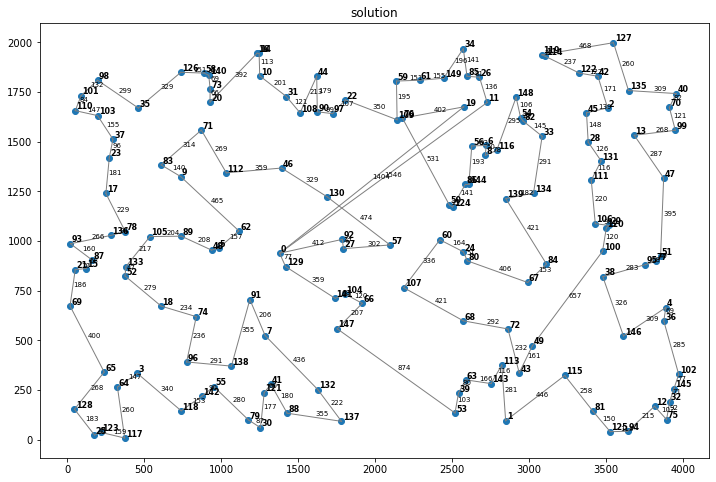

In [50]:
show_route(best_chromosome)

In [51]:
chromosome_length = 150
SGA(population_size=1500, crossover_probability=0.95, mutation_probability=0.35, number_of_iterations=800, cross_operator=OX)

  0     1.20470667 218997.86025788 248089.71150534 256515.62016100 6224.59369546
  1     2.26242948 218668.20217867 240934.37805286 247557.12651730 5167.47090477
  2     3.30860925 211441.75462185 235417.08898004 241511.93181041 4892.16556677
  3     4.35174704 208927.13415634 230368.63691380 236145.06162623 4724.12698349
  4     5.38528109 204504.07139978 225734.97562329 231216.36464353 4608.55004679
  5     6.41706324 202291.82370064 221542.73410239 226978.94111332 4447.97521036
  6     7.48783827 200202.33780676 217720.67602959 222856.52015806 4138.32819860
  7     8.53732920 189306.02209402 214337.31395632 219261.72978975 4212.43954160
  8     9.58849311 188858.85015651 211170.46129960 216097.68270188 4220.52047229
  9    10.64883232 185695.73926981 207947.00259533 213023.97789435 4201.50863080
 10    11.69022059 181599.50327930 204748.18840318 209739.78528020 4342.00649700
 11    12.74637842 178579.01033370 201072.78930531 206281.98934688 4572.76293289
 12    13.78450370 177514.75

102   108.61276650 84512.66117975 89453.28553869 90837.88179211 1142.83045469
103   109.66531658 84137.91485263 89049.69030443 90422.33021993 1128.25835634
104   110.71732879 83340.25331999 88667.99912022 90023.68079647 1131.61819945
105   111.78548455 83340.25331999 88287.58831707 89620.23885339 1106.67121626
106   112.83130145 82965.92116507 87899.73352706 89214.04482800 1116.94959894
107   113.87233973 82641.83957610 87457.00030698 88735.33283372 1158.61090491
108   114.91609550 82626.59485137 87000.08006434 88387.63442985 1166.23736052
109   115.96779561 82444.20554519 86555.33326917 87994.88086367 1141.80210742
110   117.04224110 81887.72267328 86200.71767769 87549.90869501 1081.29616404
111   118.09405327 79195.91104633 85818.96139513 87139.93947665 1051.27502764
112   119.14085031 79195.91104633 85418.26428015 86767.10311860 1025.56716392
113   120.20728421 79117.59394341 85054.12926778 86303.22810538 999.35940627
114   121.24266028 79066.81231437 84676.26931849 85881.34162357 9

209   220.98150277 53195.91638288 55940.61159880 56617.80197517 570.48759701
210   222.01543260 53094.38783596 55591.23930140 56305.29998367 592.52838511
211   223.05935359 52443.61807215 55221.30659779 55982.60376504 619.43415450
212   224.09951282 52443.61807215 54843.83324076 55626.86898135 603.94535824
213   225.14419174 52182.61826152 54462.43402067 55219.74743456 600.67396978
214   226.22406077 51869.63545185 54083.05005282 54843.91586495 576.49836776
215   227.26206136 51869.63545185 53679.58762862 54409.16445112 527.98196790
216   228.28087568 51617.44554504 53284.99425433 53959.88697563 462.04267440
217   229.31750917 51355.71986919 52971.88388577 53511.60843379 398.85137545
218   230.35289907 50983.54931764 52664.11448586 53158.60785311 361.19688784
219   231.40521550 50726.63120689 52402.78282695 52862.16852527 305.66218558
220   232.43472028 50436.15634440 52178.54232681 52541.68638726 287.91060721
221   233.48296952 49954.94271996 51974.59790390 52325.71895002 315.41554323

316   332.66149664 36779.16502766 37312.28915060 37448.37917478 111.94637192
317   333.69342065 36716.49468616 37240.86885829 37376.45029422 133.21605205
318   334.72796154 36597.05455957 37137.03333237 37355.36471751 123.26143200
319   335.76873517 36597.05455957 37057.18773773 37167.66388105  92.74973555
320   336.79802203 36360.60803151 36982.65364461 37107.62958125  96.66592912
321   337.84348416 36352.79183454 36922.04074622 37031.59570372 112.51857390
322   338.88627219 36352.79183454 36842.79140670 36958.53406664 140.49842758
323   339.91751003 36191.39429023 36729.47158899 36953.09858141 143.56863016
324   340.96285415 36015.41527192 36629.32690152 36799.29453717  97.37604750
325   342.01145053 36015.41527192 36567.62948153 36680.75985074  88.83885966
326   343.05573702 36015.41527192 36518.35861324 36612.70465106 111.11813151
327   344.09678864 35519.05592735 36416.97859331 36597.05455957 133.13137356
328   345.12786508 35481.54444688 36321.46733190 36465.35229876 133.84165470

423   444.29713678 30272.80231732 30427.14244511 30475.20753593  35.09130614
424   445.33937526 30212.94557591 30395.06544183 30427.58639400  35.49394030
425   446.37624145 30144.76048842 30353.85408291 30402.54020324  37.71620859
426   447.42644382 30103.96057255 30322.79861821 30372.32849314  47.87210790
427   448.47099900 29959.75237486 30278.00591071 30336.68716499  56.64473624
428   449.50698280 29959.75237486 30217.03890671 30310.96463171  60.56436752
429   450.55803108 29898.38851343 30161.95333899 30237.82340857  49.93893468
430   451.59140539 29863.58678467 30119.51492241 30165.32443398  56.98549311
431   452.60810494 29860.22619905 30054.77028124 30144.76048842  70.69691129
432   453.63265920 29860.22619905 29982.05940016 30070.30493422  50.86314061
433   454.67125964 29824.58487090 29941.20060384 29959.75237486  25.34792181
434   455.74168277 29824.58487090 29907.00978026 29924.95064610  24.39592596
435   456.77552986 29797.99764345 29876.10041275 29921.59006048  24.07321107

530   556.06816959 29294.49409650 29294.49409650 29294.49409650   0.00000000
531   557.10182595 29294.49409650 29294.49409650 29294.49409650   0.00000000
532   558.15134835 29294.49409650 29294.49409650 29294.49409650   0.00000000
533   559.21076632 29294.49409650 29294.49409650 29294.49409650   0.00000000
534   560.27457094 29294.49409650 29294.49409650 29294.49409650   0.00000000
535   561.30701637 29294.49409650 29294.49409650 29294.49409650   0.00000000
536   562.33452845 29294.49409650 29294.49409650 29294.49409650   0.00000000
537   563.36912727 29294.49409650 29294.49409650 29294.49409650   0.00000000
538   564.41687846 29294.49409650 29294.49409650 29294.49409650   0.00000000
539   565.45046401 29294.49409650 29294.49409650 29294.49409650   0.00000000
540   566.50316596 29294.49409650 29294.49409650 29294.49409650   0.00000000
541   567.53260899 29294.49409650 29294.49409650 29294.49409650   0.00000000
542   568.58514905 29294.49409650 29294.49409650 29294.49409650   0.00000000

637   667.40909863 29294.49409650 29294.49409650 29294.49409650   0.00000000
638   668.45783639 29294.49409650 29294.49409650 29294.49409650   0.00000000
639   669.50100493 29294.49409650 29294.49409650 29294.49409650   0.00000000
640   670.53062510 29294.49409650 29294.49409650 29294.49409650   0.00000000
641   671.57057333 29294.49409650 29294.49409650 29294.49409650   0.00000000
642   672.60992527 29294.49409650 29294.49409650 29294.49409650   0.00000000
643   673.63549376 29294.49409650 29294.49409650 29294.49409650   0.00000000
644   674.67467856 29294.49409650 29294.49409650 29294.49409650   0.00000000
645   675.72416759 29294.49409650 29294.49409650 29294.49409650   0.00000000
646   676.75784779 29294.49409650 29294.49409650 29294.49409650   0.00000000
647   677.78605390 29294.49409650 29294.49409650 29294.49409650   0.00000000
648   678.81267047 29294.49409650 29294.49409650 29294.49409650   0.00000000
649   679.86950088 29294.49409650 29294.49409650 29294.49409650   0.00000000

744   779.32969809 29294.49409650 29294.49409650 29294.49409650   0.00000000
745   780.37310982 29294.49409650 29294.49409650 29294.49409650   0.00000000
746   781.42324829 29294.49409650 29294.49409650 29294.49409650   0.00000000
747   782.48281837 29294.49409650 29294.49409650 29294.49409650   0.00000000
748   783.53227067 29294.49409650 29294.49409650 29294.49409650   0.00000000
749   784.58100367 29294.49409650 29294.49409650 29294.49409650   0.00000000
750   785.63780546 29294.49409650 29294.49409650 29294.49409650   0.00000000
751   786.69069600 29294.49409650 29294.49409650 29294.49409650   0.00000000
752   787.73111296 29294.49409650 29294.49409650 29294.49409650   0.00000000
753   788.76633263 29294.49409650 29294.49409650 29294.49409650   0.00000000
754   789.79678297 29294.49409650 29294.49409650 29294.49409650   0.00000000
755   790.82739210 29294.49409650 29294.49409650 29294.49409650   0.00000000
756   791.86128449 29294.49409650 29294.49409650 29294.49409650   0.00000000

<Figure size 864x576 with 0 Axes>

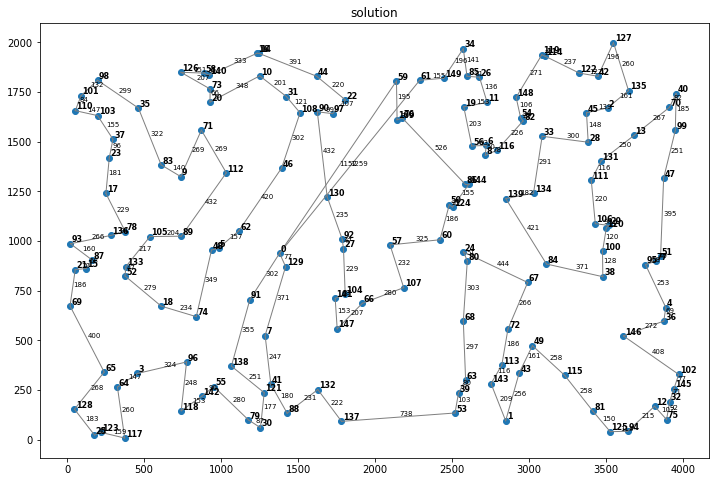

In [52]:
show_route(best_chromosome)

In [53]:
chromosome_length = 150
SGA(population_size=1500, crossover_probability=0.95, mutation_probability=0.35, number_of_iterations=800, cross_operator=CX)

  0     1.24934959 214383.01524947 248396.74216778 256561.20185506 6345.63916783
  1     2.33277440 214383.01524947 241795.59768267 248806.35600204 5499.31299866
  2     3.42785215 214383.01524947 237279.37331389 243316.48794740 4842.54024284
  3     4.49874234 214383.01524947 233524.47654215 239093.68032202 4547.77116312
  4     5.60229921 209263.78003193 230002.14907497 235715.28110498 4467.36351844
  5     6.68772531 207905.15975365 226992.15365326 232231.76819051 4255.20875592
  6     7.74474573 197577.75162440 224252.45965458 229289.29996721 4145.19646273
  7     8.76807690 197577.75162440 221762.26889135 226618.23549878 3932.02285997
  8     9.76654911 196288.55957383 219271.80506566 223900.66862164 3823.94356679
  9    10.74251962 196288.55957383 217080.92079667 221386.23908189 3827.26065368
 10    11.74444175 196288.55957383 214978.75717065 219270.37258583 4021.57606802
 11    12.67825437 195649.04219804 212343.88823055 217403.10219181 4049.12735123
 12    13.61155748 193923.50

103    44.33563757 111309.42898372 115278.86531049 116169.88958556 563.30599097
104    44.63730907 110881.57710060 114739.30928536 115155.58414584 724.51910201
105    44.93198466 110421.76113022 113488.15057270 114804.18516836 1107.10839886
106    45.23349929 110212.44613691 112173.28083810 113726.79050743 684.59588909
107    45.56646919 110212.44613691 111686.62001105 111860.74657125 316.68224980
108    46.07398653 108497.00385746 111102.49411116 111754.14228936 416.02924279
109    46.42919660 108396.12791422 110671.78522411 111058.46646196 344.65530991
110    46.92601919 107063.77850899 110246.67853115 110724.84774132 567.35612373
111    47.22966528 106740.48088950 109448.91075198 110412.96061092 826.56683082
112    47.54301786 105206.56412671 108437.29282042 109203.41587150 463.89373123
113    47.84733081 105206.56412671 108003.56722197 108497.00385746 501.47746585
114    48.14595318 104068.66072410 107379.10037932 108201.13750802 658.42669193
115    48.44660020 103669.75241342 1066

209    77.24182034 69905.43985071 71203.39122829 71624.35840536 394.27178148
210    77.89945054 69528.09105526 70772.34440837 71123.12419075 380.11452300
211    78.19061184 69528.09105526 70345.49360962 70906.79326313 419.91818264
212    78.48800254 69412.15224225 69909.73553809 70186.01061280  79.54984463
213    78.78851080 69078.15652457 69875.99837832 69905.43985071  89.15274789
214    79.08872247 68278.91370512 69667.80020880 69905.43985071 182.57287486
215    79.38143539 68278.91370512 69492.51110663 69642.07959406 163.25299415
216    79.67963481 67952.48539226 69320.76423041 69528.09105526 265.35597231
217    79.97419047 67936.96019609 68959.05022501 69412.15224225 320.08615408
218    80.26692867 67936.96019609 68686.52240586 69078.15652457 369.83304566
219    80.57501340 67507.57140096 68267.36468869 68582.52225346 148.56220536
220    80.94554710 67507.57140096 68172.98204517 68278.91370512 146.51493267
221    81.52477598 67251.57940394 67971.55493330 68116.53436264  86.29845312

316   110.26186323 49851.25435286 50336.52383675 50343.28380204  43.18912940
317   110.56262922 49720.80486102 50151.72146652 50343.28380204 174.54458703
318   110.85719824 49720.80486102 49962.50769047 50138.94307241 106.56794994
319   111.39986706 49586.08744913 49861.35440190 49907.95084888  27.89985293
320   111.70217872 49415.92139971 49843.29447168 49851.25435286  35.06067391
321   111.99582958 48937.31488143 49735.47834711 49851.25435286 110.51018946
322   112.28975844 48937.31488143 49622.50715936 49720.80486102 122.14125458
323   112.58515096 48683.61622505 49476.15944195 49586.08744913 142.68385009
324   112.87527466 48683.61622505 49304.79652192 49438.54909604 189.85579586
325   113.17022181 48671.75182069 49037.36296922 49415.92139971 148.23630777
326   113.46622252 48566.90933710 48934.89585349 49057.64311347  76.33141033
327   113.87066412 48531.40220988 48888.42995838 48937.31488143  96.12456545
328   114.33204889 48099.88171165 48728.75074514 48937.31488143  98.63929000

423   144.04490256 38899.68188975 39181.64234317 39250.23225387  51.89908168
424   144.47952819 38795.31769627 39126.71834269 39216.28430300  28.74671612
425   144.77663374 38795.31769627 39113.12924250 39125.06739806  35.68779335
426   145.07632565 38728.90329077 39042.11216867 39125.06739806  83.41831109
427   145.37054777 38705.50506127 38955.14191159 39069.01432430  95.40029513
428   145.67449951 38569.93218796 38858.02995928 38925.02789217  51.41647180
429   145.96989799 38559.02223928 38804.85044335 38899.68188975  38.67348696
430   146.26328421 38559.02223928 38782.35926984 38795.31769627  41.87458393
431   146.56515932 38121.65675155 38686.14282938 38795.31769627  93.16551877
432   146.86981702 38121.65675155 38587.72398467 38705.50506127  58.81555090
433   147.16731620 38121.65675155 38549.18539297 38569.93218796  68.90673865
434   147.47150922 38086.95786696 38384.92115738 38559.02223928 207.78308444
435   147.76380157 37936.92656617 38121.40769252 38121.65675155   5.48086063

530   176.63141608 31268.68999334 31584.79834731 31669.52296234  79.22420041
531   176.92418933 31268.68999334 31501.59977380 31570.63455138  33.73527886
532   177.21818972 31268.68999334 31484.73129553 31488.96588674  30.00047871
533   177.51676536 30935.13604051 31343.16077215 31488.96588674 103.70028532
534   177.80901647 30935.13604051 31267.03889367 31268.68999334  21.64588919
535   178.09996200 30935.13604051 31084.82773060 31268.68999334 156.64729150
536   178.39141083 30819.09855631 30935.03901052 30935.13604051   3.08990486
537   178.69052625 30782.74220735 30871.03240571 30935.13604051  54.82732768
538   178.99317360 30720.21014535 30818.92594292 30819.09855631   3.09982316
539   179.28455186 30695.63017096 30781.22740335 30819.09855631  39.45963541
540   179.58322096 30644.48486906 30736.90876462 30782.74220735  25.91130617
541   179.87500191 30644.48486906 30719.89152861 30720.21014535   4.21991409
542   180.16725326 30644.48486906 30682.59100407 30720.21014535  33.99056726

637   209.25675654 28488.08009448 28488.08009448 28488.08009448   0.00000000
638   209.55783725 28488.08009448 28488.08009448 28488.08009448   0.00000000
639   209.85418820 28488.08009448 28488.08009448 28488.08009448   0.00000000
640   210.15056205 28488.08009448 28488.08009448 28488.08009448   0.00000000
641   210.44253254 28282.77911985 28487.94322716 28488.08009448   5.29908113
642   210.73607635 28282.77911985 28352.82014821 28488.08009448  97.23439521
643   211.02549791 28282.77911985 28282.77911985 28282.77911985   0.00000000
644   211.52948856 28282.77911985 28282.77911985 28282.77911985   0.00000000
645   211.82546282 28282.77911985 28282.77911985 28282.77911985   0.00000000
646   212.12822485 28282.77911985 28282.77911985 28282.77911985   0.00000000
647   212.46485686 28282.77911985 28282.77911985 28282.77911985   0.00000000
648   212.76662230 28282.77911985 28282.77911985 28282.77911985   0.00000000
649   213.05994177 28282.77911985 28282.77911985 28282.77911985   0.00000000

744   242.54282522 28282.77911985 28282.77911985 28282.77911985   0.00000000
745   242.83456445 28282.77911985 28282.77911985 28282.77911985   0.00000000
746   243.13063908 28282.77911985 28282.77911985 28282.77911985   0.00000000
747   243.42616916 28282.77911985 28282.77911985 28282.77911985   0.00000000
748   243.72976947 28282.77911985 28282.77911985 28282.77911985   0.00000000
749   244.01822448 28282.77911985 28282.77911985 28282.77911985   0.00000000
750   244.30992699 28282.77911985 28282.77911985 28282.77911985   0.00000000
751   244.60639668 28282.77911985 28282.77911985 28282.77911985   0.00000000
752   244.89754391 28282.77911985 28282.77911985 28282.77911985   0.00000000
753   245.19034386 28282.77911985 28282.77911985 28282.77911985   0.00000000
754   245.49634433 28282.77911985 28282.77911985 28282.77911985   0.00000000
755   245.79892755 28282.77911985 28282.77911985 28282.77911985   0.00000000
756   246.09647751 28282.77911985 28282.77911985 28282.77911985   0.00000000

<Figure size 864x576 with 0 Axes>

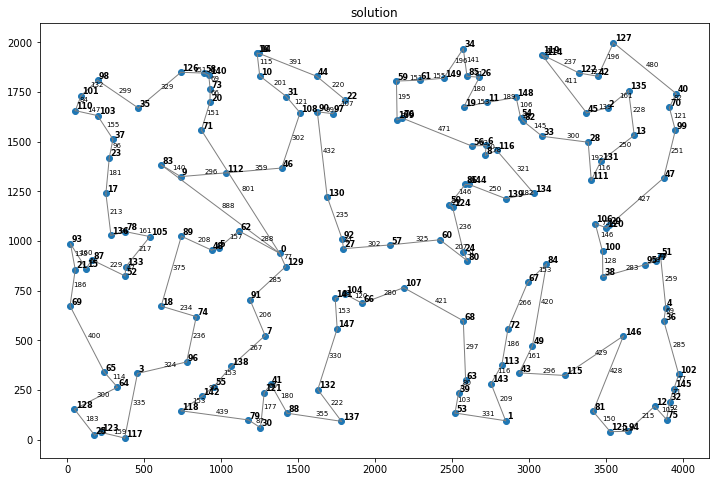

In [54]:
show_route(best_chromosome)

In [41]:
chromosome_length = 150
SGA(population_size=1500, crossover_probability=0.95, mutation_probability=0.35, number_of_iterations=800, cross_operator=SWP)

  0     1.07819724 221343.93117809 247495.06966247 255529.85722742 6489.26731793
  1     1.70010543 218495.61085642 239073.77215145 246287.55211734 5539.34116941
  2     2.31969643 218495.61085642 231949.62692526 238294.79851970 4393.34144393
  3     2.94434023 216955.44198421 226744.04056604 231231.63680302 3340.13243038
  4     3.56926084 216560.71657296 222543.01138849 225775.61973726 1675.35952946
  5     4.20636511 214378.90049269 220970.93882659 222224.84501605 1334.73320726
  6     4.82932401 212794.21570682 218943.83280913 220914.11552723 1451.13476005
  7     5.46530390 210558.14098685 217166.27919530 218495.61085642 1259.57640662
  8     6.09990811 210558.14098685 215486.17090488 216928.95731380 1272.09135791
  9     6.72479463 207681.43032929 213741.19845615 215111.72505518 1108.04673688
 10     7.34973526 206197.57931873 212288.85166031 213591.26273218 1136.36898489
 11     7.96066475 205336.61143926 210749.35252671 212436.82533822 1088.04127796
 12     8.58723903 204416.35

102    65.88645935 113929.68671457 115973.61442522 116295.79554845 473.16391429
103    66.51947117 113045.48641487 115249.13756262 115910.29557635 472.12235826
104    67.15394187 112697.12866718 114754.16764025 115193.82407909 343.58719120
105    67.77059913 112290.76384839 114388.17178535 114812.18684444 456.15801040
106    68.53362894 111665.05529356 113815.72192095 114440.64643148 524.68328621
107    69.15905643 111494.78881369 113211.17807961 113862.20879087 362.86528060
108    69.78477192 110132.99444289 112874.45052305 113258.44981996 330.11969245
109    70.45728302 109370.80505804 112495.14146382 113008.45356566 419.54451278
110    71.08445120 109370.80505804 112053.28326607 112678.03689370 566.09381731
111    71.70693564 109168.31280384 111421.92728483 112141.13266256 677.18740596
112    72.33207726 108845.03665000 110598.37492298 111628.00445674 644.12999401
113    72.94622111 107249.30913622 109947.27257647 110655.65411774 396.09145339
114    73.58140659 107249.30913622 10958

208   133.15393353 70662.88584803 71932.04100439 72273.79371093 309.37090858
209   133.76998162 70662.88584803 71583.23641118 71919.64454714 157.70157919
210   134.41511035 70590.27909844 71459.21525051 71583.60871591 133.52060828
211   135.04749012 70110.05174553 71336.20856928 71500.01726706 251.55609168
212   135.69068718 70110.05174553 70977.88831593 71371.43676348 273.18494949
213   136.32927394 69698.18004673 70709.01296151 71076.90968132 185.34038877
214   136.95411062 69698.18004673 70591.99293365 70662.88584803 159.86353340
215   137.75607967 69215.08147183 70290.80662948 70662.88584803 239.43655825
216   138.54228401 69215.08147183 70071.26125619 70219.77130156 140.17565834
217   139.16219711 68666.20980485 69922.18075422 70110.05174553 211.72697775
218   139.78220177 68666.20980485 69661.06945701 69891.75738662 152.14857030
219   140.41129470 68363.39754655 69533.63265128 69698.18004673 239.00667241
220   141.04753304 68047.31880127 69182.03117335 69516.79690195 208.61928471

315   201.26111317 48962.79630847 49201.93146770 49321.90534160  85.09536595
316   201.88636589 48710.11468533 49121.53964233 49133.30782458  38.09041808
317   202.53276706 48670.05693199 49034.27121367 49133.30782458  92.50041179
318   203.15810966 48487.94644687 48932.72279208 48996.69558702  76.84406913
319   203.78117251 48450.12535988 48845.70607764 48962.79630847 110.89148323
320   204.41375494 48084.88000771 48728.99363510 48837.83184081  64.54878449
321   205.03425813 48084.88000771 48685.10317321 48710.11468533  59.73624810
322   205.66519094 48084.88000771 48577.30157356 48710.11468533 106.28201081
323   206.30652142 47770.00883695 48475.41380944 48549.04241003 119.66262162
324   206.92782903 47659.51798861 48307.48336605 48487.94644687 198.31695107
325   207.57532024 47628.20110795 48075.91959246 48084.88000771  51.30118684
326   208.20785308 47080.53037682 47874.58478083 48084.88000771 162.29652220
327   209.03074145 47080.53037682 47729.11870449 47786.94275271  65.53275493

422   269.01495457 37280.53455511 37624.66231480 37809.07092504 141.77929934
423   269.64300776 37131.26959750 37491.07836363 37626.81208462  66.26191871
424   270.28298044 37131.26959750 37458.30259810 37461.09163070  18.81167708
425   270.90686250 37131.26959750 37372.09350451 37461.09163070 100.59743620
426   271.53603411 37098.27571469 37250.91147558 37345.87098233  63.56564412
427   272.16439152 36952.01688707 37196.17121573 37280.53455511  66.48292024
428   272.91686940 36725.21748936 37129.95626814 37131.26959750  16.26220097
429   273.54928112 36591.21986728 36994.97253297 37131.26959750 150.54452971
430   274.17626977 36282.34825871 36813.81377006 36952.01688707  95.02445326
431   274.80029678 36282.34825871 36731.68141580 36812.41345007  39.17765774
432   275.43377948 36282.34825871 36714.50800270 36725.21748936  53.90842105
433   276.06429911 36158.76293919 36526.72126164 36725.21748936 178.70986933
434   276.70035911 36077.08538156 36337.58802807 36591.21986728 111.52066714

529   336.54133606 30369.49732324 30463.41504524 30511.97817901  33.46305925
530   337.18044090 30185.11549144 30440.06414184 30440.44807372   7.59215033
531   337.80378437 30185.11549144 30343.98034284 30440.44807372 102.23504763
532   338.43315411 30079.32244046 30230.89574971 30369.49732324  79.73944143
533   339.04870129 30052.60943721 30184.65835317 30185.11549144   6.60388518
534   339.66454124 30052.60943721 30122.45352940 30185.11549144  52.60968740
535   340.28661323 30044.29227515 30072.06878873 30100.67320533  14.35623507
536   340.90530300 30026.70761137 30061.51800855 30079.32244046  12.64720057
537   341.53217864 30026.70761137 30052.50835360 30052.60943721   1.21164850
538   342.15795660 30026.59684043 30043.19788679 30052.60943721   9.65679884
539   342.77528858 30026.59684043 30032.61419292 30044.29227515   7.60749886
540   343.39350700 29941.04230774 30026.60967417 30026.70761137   2.71053884
541   344.01441932 29899.27677540 29978.28355625 30026.70761137  37.43990802

636   403.81057906 28010.06018987 28024.89934751 28053.90940515  20.74084865
637   404.57494450 28010.06018987 28010.06018987 28010.06018987   0.00000000
638   405.19995499 27967.72177523 28010.03196426 28010.06018987   1.09280871
639   405.82112098 27967.72177523 27982.55369687 28010.06018987  20.19098807
640   406.44874811 27967.72177523 27967.72177523 27967.72177523   0.00000000
641   407.07764626 27967.72177523 27967.72177523 27967.72177523   0.00000000
642   407.69129729 27967.72177523 27967.72177523 27967.72177523   0.00000000
643   408.33212090 27956.38694941 27967.71421868 27967.72177523   0.29256637
644   408.96122217 27956.38694941 27960.22567709 27967.72177523   5.36427809
645   409.60329795 27956.38694941 27956.38694941 27956.38694941   0.00000000
646   410.23304081 27956.38694941 27956.38694941 27956.38694941   0.00000000
647   410.86055660 27956.38694941 27956.38694941 27956.38694941   0.00000000
648   411.49008656 27956.38694941 27956.38694941 27956.38694941   0.00000000

743   471.03136992 27912.95495640 27912.95495640 27912.95495640   0.00000000
744   471.65652275 27912.95495640 27912.95495640 27912.95495640   0.00000000
745   472.27576447 27912.95495640 27912.95495640 27912.95495640   0.00000000
746   472.89088249 27912.95495640 27912.95495640 27912.95495640   0.00000000
747   473.51913452 27912.95495640 27912.95495640 27912.95495640   0.00000000
748   474.13865328 27912.95495640 27912.95495640 27912.95495640   0.00000000
749   474.75073743 27912.95495640 27912.95495640 27912.95495640   0.00000000
750   475.35641861 27912.95495640 27912.95495640 27912.95495640   0.00000000
751   475.95792079 27912.95495640 27912.95495640 27912.95495640   0.00000000
752   476.57937598 27912.95495640 27912.95495640 27912.95495640   0.00000000
753   477.18304515 27912.95495640 27912.95495640 27912.95495640   0.00000000
754   477.81078506 27912.95495640 27912.95495640 27912.95495640   0.00000000
755   478.55471516 27912.95495640 27912.95495640 27912.95495640   0.00000000

<Figure size 864x576 with 0 Axes>

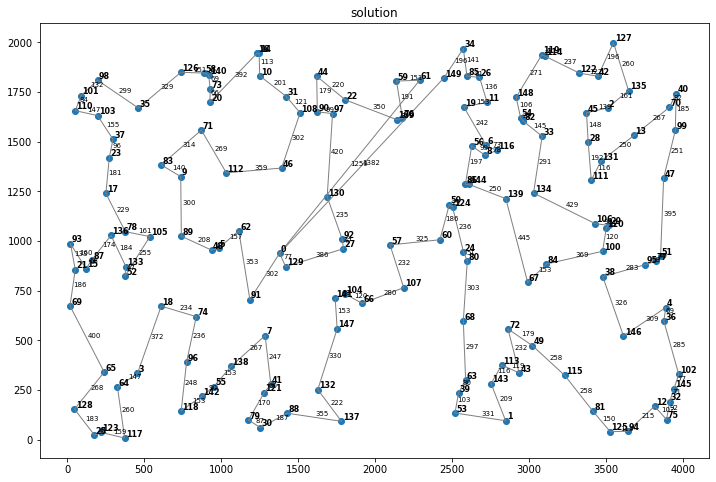

In [42]:
show_route(best_chromosome)

In [43]:
# KRO200

n = 200
print('Problem size: %d' % n)

coords = np.array([1357, 1905, 2650, 802, 1774, 107, 1307, 964, 3806, 746, 2687, 1353, 43, 1957, 3092, 1668, 185, 1542, 834, 629, 40, 462, 1183, 1391, 2048, 1628, 1097, 643, 1838, 1732, 234, 1118, 3314, 1881, 737, 1285, 779, 777, 2312, 1949, 2576, 189, 3078, 1541, 2781, 478, 705, 1812, 3409, 1917, 323, 1714, 1660, 1556, 3729, 1188, 693, 1383, 2361, 640, 2433, 1538, 554, 1825, 913, 317, 3586, 1909, 2636, 727, 1000, 457, 482, 1337, 3704, 1082, 3635, 1174, 1362, 1526, 2049, 417, 2552, 1909, 3939, 640, 219, 898, 812, 351, 901, 1552, 2513, 1572, 242, 584, 826, 1226, 3278, 799, 86, 1065, 14, 454, 1327, 1893, 2773, 1286, 2469, 1838, 3835, 963, 1031, 428, 3853, 1712, 1868, 197, 1544, 863, 457, 1607, 3174, 1064, 192, 1004, 2318, 1925, 2232, 1374, 396, 828, 2365, 1649, 2499, 658, 1410, 307, 2990, 214, 3646, 1018, 3394, 1028, 1779, 90, 1058, 372, 2933, 1459, 3099, 173, 2178, 978, 138, 1610, 2082, 1753, 2302, 1127, 805, 272, 22, 1617, 3213, 1085, 99, 536, 1533, 1780, 3564, 676, 29, 6, 3808, 1375, 2221, 291, 3499, 1885, 3124, 408, 781, 671, 1027, 1041, 3249, 378, 3297, 491, 213, 220, 721, 186, 3736, 1542, 868, 731, 960, 303, 1380, 939, 2848, 96, 3510, 1671, 457, 334, 3888, 666, 984, 965, 2721, 1482, 1286, 525, 2716, 1432, 738, 1325, 1251, 1832, 2728, 1698, 3815, 169, 3683, 1533, 1247, 1945, 123, 862, 1234, 1946, 252, 1240, 611, 673, 2576, 1676, 928, 1700, 53, 857, 1807, 1711, 274, 1420, 2574, 946, 178, 24, 2678, 1825, 1795, 962, 3384, 1498, 3520, 1079, 1256, 61, 1424, 1728, 3913, 192, 3085, 1528, 2573, 1969, 463, 1670, 3875, 598, 298, 1513, 3479, 821, 2542, 236, 3955, 1743, 1323, 280, 3447, 1830, 2936, 337, 1621, 1830, 3373, 1646, 1393, 1368, 3874, 1318, 938, 955, 3022, 474, 2482, 1183, 3854, 923, 376, 825, 2519, 135, 2945, 1622, 953, 268, 2628, 1479, 2097, 981, 890, 1846, 2139, 1806, 2421, 1007, 2290, 1810, 1115, 1052, 2588, 302, 327, 265, 241, 341, 1917, 687, 2991, 792, 2573, 599, 19, 674, 3911, 1673, 872, 1559, 2863, 558, 929, 1766, 839, 620, 3893, 102, 2178, 1619, 3822, 899, 378, 1048, 1178, 100, 2599, 901, 3416, 143, 2961, 1605, 611, 1384, 3113, 885, 2597, 1830, 2586, 1286, 161, 906, 1429, 134, 742, 1025, 1625, 1651, 1187, 706, 1787, 1009, 22, 987, 3640, 43, 3756, 882, 776, 392, 1724, 1642, 198, 1810, 3950, 1558])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)
                  
p = 26524
print('Optimal solution:\n', p)

Problem size: 200
Distance matrix:
 [[   0.         1699.54641008 1845.72289361 ...  451.50636762
  1162.88692486 2616.11505863]
 [1699.54641008    0.         1118.21330702 ... 1250.23037877
  2651.10693862 1503.84041707]
 [1845.72289361 1118.21330702    0.         ... 1535.81411636
  2320.34156968 2615.41143991]
 ...
 [ 451.50636762 1250.23037877 1535.81411636 ...    0.
  1535.21985396 2227.58434184]
 [1162.88692486 2651.10693862 2320.34156968 ... 1535.21985396
     0.         3760.45316418]
 [2616.11505863 1503.84041707 2615.41143991 ... 2227.58434184
  3760.45316418    0.        ]]
Optimal solution:
 26524


In [266]:
chromosome_length = 200
SGA(number_of_iterations=1400, crossover_probability=0.95, mutation_probability=0.50, population_size=1500)

  0     2.10295868 290767.63012058 329822.35815742 339264.13962561 7017.06576893
  1     3.95135331 287458.61346895 322317.36731831 330082.13747127 6082.61698243
  2     5.83499098 287458.61346895 316471.58277848 323689.66060634 6038.99749680
  3     7.70056629 281556.73730416 311318.39779825 318476.30594196 6086.50589695
  4     9.49665570 279614.02637307 306138.75842453 313349.65732711 6044.57013966
  5    11.34182310 276784.16420847 301377.27709569 308621.31275842 5735.65238580
  6    13.17980647 273367.70754527 297575.62292829 304207.29011013 5200.49661842
  7    15.05525875 271062.33559388 294397.31216566 300406.03246211 4907.80710553
  8    16.88147259 266891.18942922 291596.20039684 297428.82347993 4673.38940905
  9    18.80554819 264515.10714244 288979.20704647 294551.96706116 4721.09964853
 10    20.62916970 264515.10714244 286259.51629933 291818.85937422 4773.07651423
 11    22.47381186 263977.62690931 283758.20698172 289275.44132630 4849.46006600
 12    24.30235982 259774.75

102   171.63374782 154519.00465612 161797.87463618 163754.20917775 1507.73865506
103   173.11889720 152786.91153497 161036.35609662 162833.04521967 1425.02428440
104   174.63388634 152786.91153497 160271.62762545 162036.24475588 1402.14202313
105   176.10354805 152786.91153497 159474.44119163 161212.07625125 1331.37501716
106   177.60770726 152450.27502884 158762.81742476 160371.41568816 1313.03952607
107   179.07101679 151846.90214918 158071.01606025 159638.01630537 1335.62263049
108   180.57383704 150648.18884057 157462.23415489 159028.50462298 1403.90209051
109   182.10992026 150065.24103505 156796.00762959 158435.84153426 1492.55084659
110   183.66587687 149279.09413903 156118.54574118 157868.08174456 1582.68145350
111   185.33778477 149279.09413903 155206.17986493 157237.09758087 1575.25381353
112   186.83954978 148541.06823020 154361.40108548 156377.03517842 1433.99368067
113   188.32107186 146053.48881743 153498.55617264 155261.51332477 1281.44117997
114   189.78371286 146053.48

204   318.55640697 96766.55103741 99951.91884703 100788.59904124 687.63448786
205   319.94772291 96398.70721952 99488.33910963 100377.58083328 716.90776880
206   321.35349536 94625.33520336 99063.43742843 99935.19206979 701.55848768
207   322.73953819 94254.01730573 98622.72521428 99510.38374405 702.27698205
208   324.12763882 94254.01730573 98211.76275347 99098.33649088 707.38256104
209   325.53051209 94205.24555890 97769.78607117 98673.66693271 737.13585084
210   326.94041085 93153.23130829 97342.80320119 98254.30751969 765.26626941
211   328.32955790 93147.64264775 96859.35408893 97831.57382927 828.59854979
212   329.75075340 92900.82946337 96349.40581065 97398.98503537 843.46884662
213   331.13810849 92316.00504566 95842.36097752 96923.78623622 830.47729541
214   332.50557828 92316.00504566 95294.96691160 96312.02013546 807.68996469
215   333.88996458 92290.90743267 94733.30554250 95755.09493498 776.86682286
216   335.24828815 91594.22929916 94177.06344296 95159.65694063 720.177950

311   458.99364734 64552.32987949 66173.67533249 66673.90777299 331.45536835
312   460.22116041 64552.32987949 65936.09646381 66294.31430054 281.44570548
313   461.44844460 64552.32987949 65730.43200331 66073.74090539 271.35242742
314   462.70915031 64382.40632281 65523.61713383 65851.17444525 293.01150908
315   463.97670126 64151.02261037 65314.91222563 65713.61608603 286.13300758
316   465.22335887 64151.02261037 65116.04917973 65466.28721095 236.55881112
317   466.48516035 63825.25248959 64954.19629537 65245.69220510 215.36808410
318   467.76641059 63825.25248959 64822.82795771 65052.26274121 219.81483847
319   469.06146884 63253.63427660 64676.22342370 64984.40045502 233.49778242
320   470.38283849 63253.63427660 64538.63111156 64824.95251862 232.08708648
321   471.69013286 62606.39877563 64405.05738360 64698.80059587 255.62752148
322   473.01717830 62606.39877563 64255.40800291 64560.33582558 296.49332986
323   474.32304645 62292.44993762 64043.04424972 64445.31680556 356.41782542

418   594.58534408 48902.22224850 49421.74224288 49615.91190119 120.47578856
419   595.82221937 48740.85468302 49332.89868876 49466.19121255  99.64691254
420   597.06303477 48444.27604736 49262.01270212 49375.87327190 110.36548712
421   598.30645466 48444.27604736 49172.17078249 49295.10671714 123.86399320
422   599.55668354 48405.77837713 49082.13922118 49230.58665892 144.38716309
423   600.79643369 48194.84172469 48973.15507570 49165.90158873 147.30767207
424   602.07480288 48194.84172469 48873.78663882 49053.51427118 146.31514676
425   603.31700063 48173.09830267 48774.22999486 48904.09366173 167.19288291
426   604.56849718 48055.94293740 48634.11229597 48900.55059954 185.33736151
427   605.82117701 47837.05702751 48502.56762377 48740.85468302 152.51898153
428   607.06047773 47837.05702751 48388.62625855 48546.82495735 103.21278182
429   608.25539565 47837.05702751 48327.91795148 48444.27604736 114.50385849
430   609.46554780 47837.05702751 48232.60522877 48382.11226681 114.48743094

525   727.20501995 39949.23030720 40433.70290603 40540.51209588 130.48870108
526   728.42682242 39949.23030720 40314.54720945 40493.05811633 152.43840110
527   729.65351081 39916.73545114 40181.23976507 40361.50339441 110.85071546
528   730.85459828 39907.85861188 40094.31972836 40250.30828397  67.32462984
529   732.07830977 39835.65745981 40050.38236286 40099.13846301  39.67511131
530   733.35137606 39727.04925399 40023.66475248 40070.30466131  51.41338450
531   734.58029151 39716.84934208 39976.37766021 40046.76992882  49.18261238
532   735.79514551 39636.29348718 39938.78527860 39989.90214695  42.23278966
533   737.02812004 39509.11826476 39911.40403128 39951.49654358  63.70434418
534   738.25018954 39487.13016231 39849.13226774 39951.49654358  92.91824716
535   739.50293112 39352.19264364 39777.94621695 39907.85861188  92.14675136
536   740.75205970 39281.95811460 39711.69836119 39842.88833776  62.95508837
537   741.96485782 39281.95811460 39677.06140656 39720.66538994  57.78560973

632   858.61927629 34446.47531273 34807.07584284 34852.84041412  61.96160424
633   859.88911438 34446.47531273 34759.48033155 34850.45912627  66.30408125
634   861.16740632 34444.09402488 34726.04430824 34775.30062667  57.91243182
635   862.48798108 34444.09402488 34698.10905791 34740.89354166  88.86673057
636   863.71898890 34437.94672503 34598.05046147 34738.51225380 123.04111927
637   864.92678285 34406.48945245 34491.65003319 34582.96304187  53.54823129
638   866.11717558 34374.08349458 34446.73453936 34481.33300783   4.99935676
639   867.31350183 34358.31056857 34445.77730871 34446.47531273   5.02174479
640   868.53235769 34285.91875041 34425.96316053 34446.47531273  32.95046286
641   869.74149752 34248.31417798 34391.15916014 34444.09402488  41.75806427
642   870.92620611 34173.94300931 34355.45071240 34406.48945245  32.46601482
643   872.12349558 34117.00861484 34333.18444456 34371.70220673  36.47905102
644   873.31860542 34071.21101881 34299.69834744 34358.31056857  28.01641865

739   988.34279966 32013.53048570 32013.53048570 32013.53048570   0.00000000
740   989.55844402 32013.53048570 32013.53048570 32013.53048570   0.00000000
741   990.74210787 32013.53048570 32013.53048570 32013.53048570   0.00000000
742   991.94278955 32013.53048570 32013.53048570 32013.53048570   0.00000000
743   993.13429379 32013.53048570 32013.53048570 32013.53048570   0.00000000
744   994.33820224 32013.53048570 32013.53048570 32013.53048570   0.00000000
745   995.52668548 32013.53048570 32013.53048570 32013.53048570   0.00000000
746   996.72776318 32013.53048570 32013.53048570 32013.53048570   0.00000000
747   997.91600084 32009.69788450 32013.52793063 32013.53048570   0.09892435
748   999.12416196 31978.05039054 32011.53176515 32013.53048570   2.10094875
749  1000.31875777 31978.05039054 32009.50466360 32009.69788450   2.44719055
750  1001.50001049 31973.04649062 31993.57091857 32009.69788450  15.78533990
751  1002.71841097 31973.04649062 31978.03704681 31978.05039054   0.25805552

846  1116.27321148 31290.75813644 31290.75813644 31290.75813644   0.00000000
847  1117.46762323 31290.75813644 31290.75813644 31290.75813644   0.00000000
848  1118.64989877 31290.75813644 31290.75813644 31290.75813644   0.00000000
849  1119.83681583 31290.75813644 31290.75813644 31290.75813644   0.00000000
850  1121.04783273 31290.75813644 31290.75813644 31290.75813644   0.00000000
851  1122.23857331 31290.75813644 31290.75813644 31290.75813644   0.00000000
852  1123.43278551 31290.75813644 31290.75813644 31290.75813644   0.00000000
853  1124.62776804 31290.75813644 31290.75813644 31290.75813644   0.00000000
854  1125.83391833 31290.75813644 31290.75813644 31290.75813644   0.00000000
855  1127.02091765 31290.75813644 31290.75813644 31290.75813644   0.00000000
856  1128.22437549 31290.75813644 31290.75813644 31290.75813644   0.00000000
857  1129.41413093 31290.75813644 31290.75813644 31290.75813644   0.00000000
858  1130.62810755 31290.75813644 31290.75813644 31290.75813644   0.00000000

953  1244.38350296 31273.16098310 31273.16098310 31273.16098310   0.00000000
954  1245.57265139 31273.16098310 31273.16098310 31273.16098310   0.00000000
955  1246.76889873 31273.16098310 31273.16098310 31273.16098310   0.00000000
956  1247.96616411 31273.16098310 31273.16098310 31273.16098310   0.00000000
957  1249.12887359 31273.16098310 31273.16098310 31273.16098310   0.00000000
958  1250.39620829 31273.16098310 31273.16098310 31273.16098310   0.00000000
959  1251.59702969 31273.16098310 31273.16098310 31273.16098310   0.00000000
960  1252.81127548 31273.16098310 31273.16098310 31273.16098310   0.00000000
961  1253.99202681 31273.16098310 31273.16098310 31273.16098310   0.00000000
962  1255.17818975 31273.16098310 31273.16098310 31273.16098310   0.00000000
963  1256.37396431 31273.16098310 31273.16098310 31273.16098310   0.00000000
964  1257.53237891 31273.16098310 31273.16098310 31273.16098310   0.00000000
965  1258.73223186 31273.16098310 31273.16098310 31273.16098310   0.00000000

1059  1371.78688693 31273.16098310 31273.16098310 31273.16098310   0.00000000
1060  1372.96530819 31273.16098310 31273.16098310 31273.16098310   0.00000000
1061  1374.16131663 31273.16098310 31273.16098310 31273.16098310   0.00000000
1062  1375.36702180 31273.16098310 31273.16098310 31273.16098310   0.00000000
1063  1376.56587887 31273.16098310 31273.16098310 31273.16098310   0.00000000
1064  1377.78113222 31273.16098310 31273.16098310 31273.16098310   0.00000000
1065  1378.98856091 31273.16098310 31273.16098310 31273.16098310   0.00000000
1066  1380.19364953 31273.16098310 31273.16098310 31273.16098310   0.00000000
1067  1381.40311193 31273.16098310 31273.16098310 31273.16098310   0.00000000
1068  1382.61670136 31273.16098310 31273.16098310 31273.16098310   0.00000000
1069  1383.80414391 31273.16098310 31273.16098310 31273.16098310   0.00000000
1070  1385.01433778 31273.16098310 31273.16098310 31273.16098310   0.00000000
1071  1386.20446444 31273.16098310 31273.16098310 31273.16098310

1165  1499.58543229 31273.16098310 31273.16098310 31273.16098310   0.00000000
1166  1500.76300859 31273.16098310 31273.16098310 31273.16098310   0.00000000
1167  1501.95268512 31273.16098310 31273.16098310 31273.16098310   0.00000000
1168  1503.15909767 31273.16098310 31273.16098310 31273.16098310   0.00000000
1169  1504.37811017 31273.16098310 31273.16098310 31273.16098310   0.00000000
1170  1505.61754346 31273.16098310 31273.16098310 31273.16098310   0.00000000
1171  1506.81960773 31273.16098310 31273.16098310 31273.16098310   0.00000000
1172  1508.02676225 31273.16098310 31273.16098310 31273.16098310   0.00000000
1173  1509.25117040 31273.16098310 31273.16098310 31273.16098310   0.00000000
1174  1510.45241952 31273.16098310 31273.16098310 31273.16098310   0.00000000
1175  1511.67364001 31273.16098310 31273.16098310 31273.16098310   0.00000000
1176  1512.87358975 31273.16098310 31273.16098310 31273.16098310   0.00000000
1177  1514.08588171 31273.16098310 31273.16098310 31273.16098310

1271  1627.31313205 31273.16098310 31273.16098310 31273.16098310   0.00000000
1272  1628.52008796 31273.16098310 31273.16098310 31273.16098310   0.00000000
1273  1629.71413136 31273.16098310 31273.16098310 31273.16098310   0.00000000
1274  1630.91136956 31273.16098310 31273.16098310 31273.16098310   0.00000000
1275  1632.10528946 31273.16098310 31273.16098310 31273.16098310   0.00000000
1276  1633.30037427 31273.16098310 31273.16098310 31273.16098310   0.00000000
1277  1634.49699163 31273.16098310 31273.16098310 31273.16098310   0.00000000
1278  1635.72976923 31273.16098310 31273.16098310 31273.16098310   0.00000000
1279  1636.91731071 31273.16098310 31273.16098310 31273.16098310   0.00000000
1280  1638.10824323 31273.16098310 31273.16098310 31273.16098310   0.00000000
1281  1639.26781631 31273.16098310 31273.16098310 31273.16098310   0.00000000
1282  1640.47398663 31273.16098310 31273.16098310 31273.16098310   0.00000000
1283  1641.66425514 31273.16098310 31273.16098310 31273.16098310

1377  1755.70150185 31273.16098310 31273.16098310 31273.16098310   0.00000000
1378  1756.87515759 31273.16098310 31273.16098310 31273.16098310   0.00000000
1379  1758.06667233 31273.16098310 31273.16098310 31273.16098310   0.00000000
1380  1759.26996493 31273.16098310 31273.16098310 31273.16098310   0.00000000
1381  1760.48683453 31273.16098310 31273.16098310 31273.16098310   0.00000000
1382  1761.68835735 31273.16098310 31273.16098310 31273.16098310   0.00000000
1383  1762.89510870 31273.16098310 31273.16098310 31273.16098310   0.00000000
1384  1764.10284424 31273.16098310 31273.16098310 31273.16098310   0.00000000
1385  1765.32230377 31273.16098310 31273.16098310 31273.16098310   0.00000000
1386  1766.53311443 31273.16098310 31273.16098310 31273.16098310   0.00000000
1387  1767.76129389 31273.16098310 31273.16098310 31273.16098310   0.00000000
1388  1768.97074175 31273.16098310 31273.16098310 31273.16098310   0.00000000
1389  1770.17575216 31273.16098310 31273.16098310 31273.16098310

<Figure size 864x576 with 0 Axes>

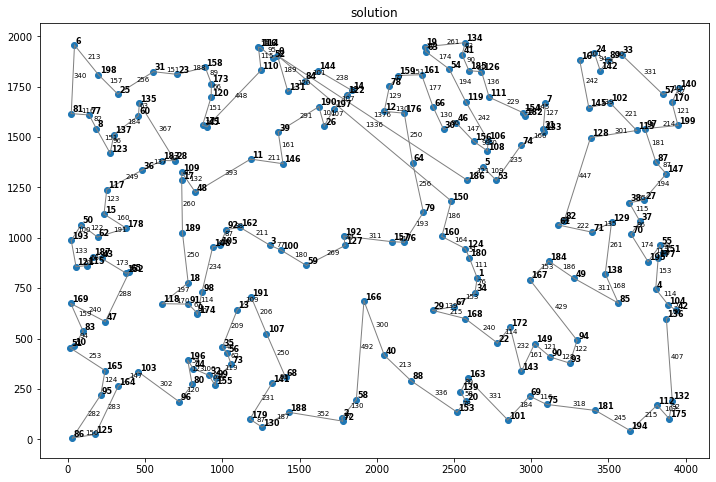

In [267]:
show_route(best_chromosome)

In [328]:
chromosome_length = 200
SGA(number_of_iterations=1400, crossover_probability=0.90, mutation_probability=0.35, population_size=1500, cross_operator=OX)

  0     1.47882199 299781.98395345 329678.15899059 339288.80782657 7215.87680225
  1     2.77061152 296049.58705168 321316.44928855 329354.64830143 6314.01005535
  2     4.03742170 288582.29972874 314281.42571534 321597.49422134 5660.02329748
  3     5.33910012 281864.62483098 308469.15779078 315035.10879697 5246.80251421
  4     6.65979576 277516.67938938 303431.18892733 309505.43950226 4979.94208491
  5     7.96967030 274766.30862391 298751.50778928 304565.41414087 4678.21959638
  6     9.26631474 268692.94833701 294406.36254540 299968.19738154 4592.96741445
  7    10.60163283 268692.94833701 290156.16221548 295762.36809265 4750.93300444
  8    11.89394832 262557.47298925 285842.29056553 291688.48629941 4816.61122736
  9    13.18963099 261216.73633534 281553.23034565 287147.92404799 4427.57505870
 10    14.46154666 257160.85657527 277687.79454890 282935.50828134 4385.04591263
 11    15.77586365 257160.85657527 274040.42423371 279288.37125251 4211.40691467
 12    17.05001163 251410.35

102   134.32890725 141464.46774378 148727.69145814 150675.51875001 1603.42358443
103   135.67598629 141464.46774378 148050.87768618 149913.04886883 1569.49363874
104   136.95923615 141464.46774378 147315.27017357 149158.87226107 1570.77784471
105   138.27307200 140520.22129628 146674.48173600 148573.87695634 1574.49559466
106   139.58249688 139154.90089795 145985.53360748 147899.90793821 1568.78351421
107   140.88625479 139154.90089795 145335.56219839 147193.55512162 1494.44321115
108   142.18315744 139154.90089795 144658.81094739 146467.70530811 1411.27007136
109   143.46162415 138494.14052288 144099.73610025 145775.92181043 1299.79409073
110   144.72380090 137897.48207126 143557.26451823 145219.06880622 1233.02406389
111   146.03598619 137897.48207126 143130.20618914 144663.66133884 1160.86484717
112   147.34034634 135413.33260186 142636.93113139 144108.39610494 1145.35731698
113   148.65309691 135413.33260186 142212.28587388 143599.75125876 1128.70354863
114   149.93318343 135413.33

204   266.23167896 102461.47351321 105964.46785010 106693.19332108 603.64728705
205   267.51501942 102280.04980941 105735.05652582 106422.52760445 630.21375817
206   268.82657123 102280.04980941 105479.19465676 106067.07136518 714.01220973
207   270.11347938 100984.96916238 105145.66696803 106052.91223029 803.06429222
208   271.39952588 100984.96916238 104828.60316097 105796.52791282 784.59705851
209   272.72289109 100262.73828562 104523.98503737 105469.22772874 758.01475205
210   274.01210356 100262.73828562 104269.21112245 105211.47242376 743.96114385
211   275.30458355 99904.17187371 103989.94111410 104957.38924253 730.87958190
212   276.60056829 99904.17187371 103714.50450071 104606.74109959 739.83006997
213   277.91697359 99904.17187371 103462.93938466 104265.25492538 763.36617722
214   279.22396636 99185.93100128 103163.36546419 104146.64855117 816.70885938
215   280.53012347 99185.93100128 102864.20922640 103796.03294080 837.47409465
216   281.82706046 98343.50302835 102561.2234

310   403.25649333 76731.13093184 78453.97004003 79089.52140580 440.35197307
311   404.55642605 76632.14040571 78215.07986483 78786.64196670 413.84448673
312   405.84606123 76380.22017169 78007.33866718 78502.26836359 404.57788645
313   407.14304996 76075.67129451 77791.00556867 78266.05612326 417.05343715
314   408.45596313 75387.32015448 77560.85592332 78154.94991756 444.41160976
315   409.72572970 75387.32015448 77322.80106007 77870.48332963 453.71493495
316   411.03668118 74885.94865406 77063.18626903 77619.73673174 471.57973683
317   412.35231471 74885.94865406 76806.74631214 77378.34534708 474.01324925
318   413.63498974 74226.11454078 76510.49162416 77118.87604618 484.76852969
319   414.88950968 73966.58399315 76204.02645392 76809.55513288 478.74037097
320   416.18468523 73966.58399315 75924.05831595 76539.46635067 447.08560578
321   417.47194242 73873.21596566 75644.36170579 76246.22572680 399.20922761
322   418.79713106 73862.62564868 75394.45944089 75911.75879091 359.71383537

417   541.19066978 57309.02637650 58178.84056656 58559.19725752 271.79651954
418   542.54102707 56802.38046657 58006.21077003 58303.45808367 290.70859883
419   543.87236762 56503.27086004 57783.04638585 58199.81104652 297.00210764
420   545.13936067 55953.10994881 57552.07646737 57930.64085272 225.44061784
421   546.41646886 55953.10994881 57416.96782707 57638.33041748 217.84987271
422   547.74675989 55953.10994881 57243.70709806 57532.89848062 234.05119830
423   549.03498220 55904.58194305 57088.12842975 57378.63766857 255.82349933
424   550.31496453 55809.52322287 56903.26746691 57234.49879175 282.07577194
425   551.64022875 55604.68431324 56730.76967405 57073.47087027 275.08957753
426   552.92931342 55426.21302864 56576.29281780 56943.95792400 283.44295658
427   554.22206879 55422.27911331 56438.62063596 56802.38046657 271.43227006
428   555.53423762 55295.16010537 56294.78107086 56647.15306296 258.44310101
429   556.83008289 54912.31484119 56165.09449243 56481.10848460 254.55157971

524   679.70532298 42793.42996827 43263.87122709 43556.75361092 122.25833355
525   681.02655196 42453.98111419 43181.35375452 43327.44918453  99.27420282
526   682.31432199 42453.98111419 43110.03821170 43235.62285666 122.38161079
527   683.61774445 42342.59757150 43002.06698864 43158.80488519 150.83564767
528   684.93584967 42284.97128368 42857.10116144 43066.61302615 149.37989453
529   686.24174762 42283.23811430 42730.97622621 42917.93265668 138.90316005
530   687.54279542 42111.51629309 42620.02022790 42793.42996827 138.05760069
531   688.80722761 42111.51629309 42499.36369714 42674.82742194 129.75124435
532   690.07820725 42053.89000527 42383.46112754 42523.72026481  81.44160694
533   691.36695290 42053.89000527 42315.06540907 42414.06989149  46.60311270
534   692.70233107 41865.67460391 42281.62792278 42342.59757150  45.58442005
535   693.99863696 41865.67460391 42250.75224084 42284.97128368  66.47456033
536   695.28578663 41628.30922735 42166.33860261 42284.97128368 103.64851209

631   818.01117182 36084.49304063 36219.92024457 36255.74718703  30.56862610
632   819.33166051 35986.62474975 36195.91301370 36207.55284256  34.19326510
633   820.62518334 35986.62474975 36123.02521720 36207.55284256  57.96299528
634   821.90193939 35936.04494020 36078.69872471 36084.49304063  20.96208020
635   823.19391203 35904.39175055 36026.97997200 36084.49304063  47.05545066
636   824.50671029 35883.43011111 35981.14858248 35986.62474975  14.61716629
637   825.86121225 35833.58998643 35952.91569058 35986.62474975  27.92651363
638   827.15520430 35833.58998643 35926.05784157 35957.00657964  23.46509160
639   828.43573260 35783.01017688 35904.50897973 35934.00992066  25.16179140
640   829.73329234 35759.78507767 35880.38601293 35904.39175055  22.07596329
641   831.17554212 35697.23564007 35860.16579573 35883.43011111  29.71610114
642   832.47594404 35697.23564007 35824.13797313 35860.07393731  29.97977853
643   833.76809788 35697.23564007 35795.81314555 35833.58998643  28.97257772

738   956.65535855 33101.10522931 33101.10522931 33101.10522931   0.00000000
739   957.94886255 33101.10522931 33101.10522931 33101.10522931   0.00000000
740   959.25828218 33094.79328158 33101.10102134 33101.10522931   0.16291946
741   960.55816984 33094.79328158 33097.11187038 33101.10522931   3.04285348
742   961.85542488 33077.91471418 33094.78202920 33094.79328158   0.43565744
743   963.14702916 33077.91471418 33083.61966996 33094.79328158   7.98404410
744   964.43807244 32993.24217962 33077.85826582 33077.91471418   2.18550657
745   965.75154305 32993.24217962 33022.57197250 33077.91471418  40.26496110
746   967.05095243 32993.24217962 32993.24217962 32993.24217962   0.00000000
747   968.36174631 32990.75572801 32993.24052199 32993.24217962   0.06417850
748   969.64244366 32990.75572801 32991.60775210 32993.24217962   1.18007271
749   970.92619681 32900.62272239 32990.69563934 32990.75572801   2.32644833
750   972.20551682 32900.62272239 32931.00929534 32990.75572801  42.59509875

845  1094.88881302 31999.96097655 31999.96097655 31999.96097655   0.00000000
846  1096.20036602 31999.96097655 31999.96097655 31999.96097655   0.00000000
847  1097.49326706 31999.96097655 31999.96097655 31999.96097655   0.00000000
848  1098.79848289 31999.96097655 31999.96097655 31999.96097655   0.00000000
849  1100.06888700 31999.96097655 31999.96097655 31999.96097655   0.00000000
850  1101.36476779 31999.96097655 31999.96097655 31999.96097655   0.00000000
851  1102.66339493 31999.96097655 31999.96097655 31999.96097655   0.00000000
852  1103.94849277 31999.96097655 31999.96097655 31999.96097655   0.00000000
853  1105.20712519 31999.96097655 31999.96097655 31999.96097655   0.00000000
854  1106.53941059 31999.96097655 31999.96097655 31999.96097655   0.00000000
855  1107.85996962 31999.96097655 31999.96097655 31999.96097655   0.00000000
856  1109.14562273 31999.96097655 31999.96097655 31999.96097655   0.00000000
857  1110.41536927 31999.96097655 31999.96097655 31999.96097655   0.00000000

952  1233.49644995 31788.77633664 31788.77633664 31788.77633664   0.00000000
953  1234.78315663 31788.77633664 31788.77633664 31788.77633664   0.00000000
954  1236.07712364 31788.77633664 31788.77633664 31788.77633664   0.00000000
955  1237.35719037 31788.77633664 31788.77633664 31788.77633664   0.00000000
956  1238.63032198 31788.77633664 31788.77633664 31788.77633664   0.00000000
957  1239.90825510 31788.77633664 31788.77633664 31788.77633664   0.00000000
958  1241.17842221 31788.77633664 31788.77633664 31788.77633664   0.00000000
959  1242.47468090 31788.77633664 31788.77633664 31788.77633664   0.00000000
960  1243.76642323 31788.77633664 31788.77633664 31788.77633664   0.00000000
961  1245.07452917 31788.77633664 31788.77633664 31788.77633664   0.00000000
962  1246.35900760 31788.77633664 31788.77633664 31788.77633664   0.00000000
963  1247.66902637 31788.77633664 31788.77633664 31788.77633664   0.00000000
964  1248.95411253 31788.77633664 31788.77633664 31788.77633664   0.00000000

1058  1370.39871216 31788.77633664 31788.77633664 31788.77633664   0.00000000
1059  1371.69729948 31788.77633664 31788.77633664 31788.77633664   0.00000000
1060  1372.98844337 31788.77633664 31788.77633664 31788.77633664   0.00000000
1061  1374.31059933 31788.77633664 31788.77633664 31788.77633664   0.00000000
1062  1375.60146284 31788.77633664 31788.77633664 31788.77633664   0.00000000
1063  1376.89383054 31788.77633664 31788.77633664 31788.77633664   0.00000000
1064  1378.20493126 31788.77633664 31788.77633664 31788.77633664   0.00000000
1065  1379.47776270 31788.77633664 31788.77633664 31788.77633664   0.00000000
1066  1380.76524663 31788.77633664 31788.77633664 31788.77633664   0.00000000
1067  1382.02488184 31788.77633664 31788.77633664 31788.77633664   0.00000000
1068  1383.29750347 31788.77633664 31788.77633664 31788.77633664   0.00000000
1069  1384.60666537 31788.77633664 31788.77633664 31788.77633664   0.00000000
1070  1385.90078449 31788.77633664 31788.77633664 31788.77633664

1164  1507.90419030 31788.77633664 31788.77633664 31788.77633664   0.00000000
1165  1509.16860509 31788.77633664 31788.77633664 31788.77633664   0.00000000
1166  1510.46231461 31788.77633664 31788.77633664 31788.77633664   0.00000000
1167  1511.77689934 31788.77633664 31788.77633664 31788.77633664   0.00000000
1168  1513.07744956 31788.77633664 31788.77633664 31788.77633664   0.00000000
1169  1514.38573098 31788.77633664 31788.77633664 31788.77633664   0.00000000
1170  1515.75606799 31788.77633664 31788.77633664 31788.77633664   0.00000000
1171  1517.04840851 31788.77633664 31788.77633664 31788.77633664   0.00000000
1172  1518.34179831 31788.77633664 31788.77633664 31788.77633664   0.00000000
1173  1519.60739326 31788.77633664 31788.77633664 31788.77633664   0.00000000
1174  1520.90009356 31788.77633664 31788.77633664 31788.77633664   0.00000000
1175  1522.19383717 31788.77633664 31788.77633664 31788.77633664   0.00000000
1176  1523.50960398 31788.77633664 31788.77633664 31788.77633664

1270  1645.11826801 31788.77633664 31788.77633664 31788.77633664   0.00000000
1271  1646.41745281 31788.77633664 31788.77633664 31788.77633664   0.00000000
1272  1647.72287107 31788.77633664 31788.77633664 31788.77633664   0.00000000
1273  1648.99516678 31788.77633664 31788.77633664 31788.77633664   0.00000000
1274  1650.28478241 31788.77633664 31788.77633664 31788.77633664   0.00000000
1275  1651.60887480 31788.77633664 31788.77633664 31788.77633664   0.00000000
1276  1652.90682530 31788.77633664 31788.77633664 31788.77633664   0.00000000
1277  1654.19154048 31788.77633664 31788.77633664 31788.77633664   0.00000000
1278  1655.50262499 31788.77633664 31788.77633664 31788.77633664   0.00000000
1279  1656.85636401 31788.77633664 31788.77633664 31788.77633664   0.00000000
1280  1658.16174293 31788.77633664 31788.77633664 31788.77633664   0.00000000
1281  1659.46075797 31788.77633664 31788.77633664 31788.77633664   0.00000000
1282  1660.73785877 31788.77633664 31788.77633664 31788.77633664

1376  1782.46462631 31788.77633664 31788.77633664 31788.77633664   0.00000000
1377  1783.75118375 31788.77633664 31788.77633664 31788.77633664   0.00000000
1378  1785.04239893 31788.77633664 31788.77633664 31788.77633664   0.00000000
1379  1786.42533159 31788.77633664 31788.77633664 31788.77633664   0.00000000
1380  1787.72056794 31788.77633664 31788.77633664 31788.77633664   0.00000000
1381  1788.99947548 31788.77633664 31788.77633664 31788.77633664   0.00000000
1382  1790.29833555 31788.77633664 31788.77633664 31788.77633664   0.00000000
1383  1791.59039474 31788.77633664 31788.77633664 31788.77633664   0.00000000
1384  1792.87231326 31788.77633664 31788.77633664 31788.77633664   0.00000000
1385  1794.18710446 31788.77633664 31788.77633664 31788.77633664   0.00000000
1386  1795.47546339 31788.77633664 31788.77633664 31788.77633664   0.00000000
1387  1796.74505830 31788.77633664 31788.77633664 31788.77633664   0.00000000
1388  1798.03166175 31788.77633664 31788.77633664 31788.77633664

<Figure size 864x576 with 0 Axes>

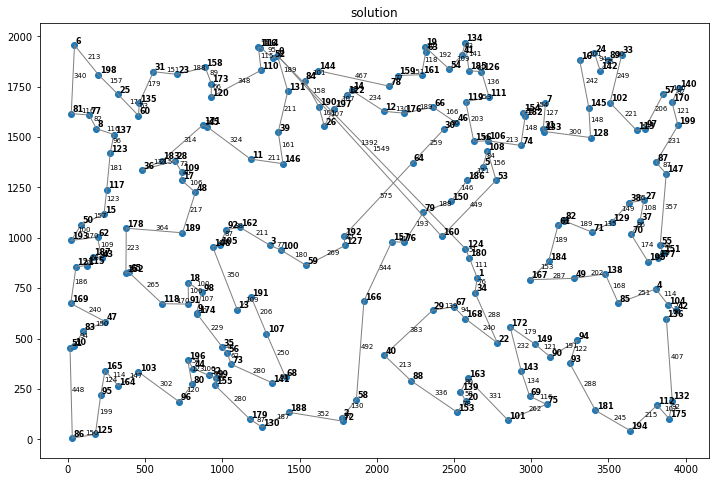

In [326]:
show_route(best_chromosome)

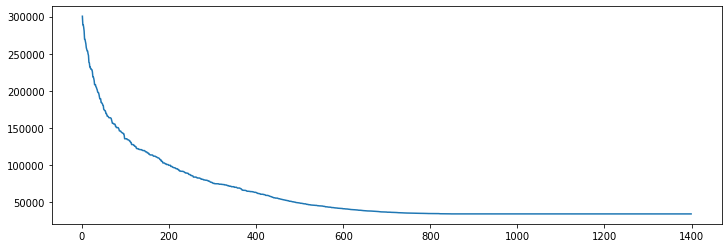

In [323]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [350]:
chromosome_length = 200
SGA(number_of_iterations=1400, crossover_probability=0.90, mutation_probability=0.4, population_size=1500, cross_operator=CX)

  0     1.65297985 288068.96196509 330025.54707171 339091.62222109 7183.77784583
  1     3.13011622 277637.84624220 322396.62185114 330659.38570390 7250.16094052
  2     4.64982533 277637.84624220 315488.75470573 323816.67030076 7271.65963195
  3     6.06490183 277637.84624220 308861.49201921 317299.05302483 7651.98773937
  4     7.33588505 276187.37497300 301961.24399224 310933.91747564 7778.81668364
  5     8.37811685 275116.34588595 294177.82287255 303598.86937331 7333.11493931
  6     9.08014965 272739.05082939 286190.99065062 295046.09569310 6182.38948259
  7     9.59416747 270400.47702005 278973.76653326 284032.12837839 2116.12765284
  8    10.00469184 269673.34293277 277102.26243491 278567.58999739 1409.72693568
  9    10.40393305 267074.29696634 275353.66023461 277128.79746283 1677.82307028
 10    10.82610106 264763.72694472 273103.04875036 275500.33329222 1921.39180271
 11    11.28836727 263445.01658304 270727.58301812 272739.05082939 1822.02551165
 12    11.73524857 260042.21

102    48.08306456 167806.95073072 171148.38953307 171675.77519024 577.27959889
103    48.44797397 167806.95073072 170403.20144593 171104.52263978 565.72094195
104    48.81719828 167530.92220591 169791.87874608 170217.21846830 542.95532030
105    49.18512630 166016.06849695 169058.53828400 169893.91062816 720.76615930
106    49.55468535 165771.54700703 168232.53143887 169022.75663855 489.02796596
107    49.98480940 165682.09613975 167737.51655139 168148.65488105 377.25383658
108    50.36862898 164683.16866198 167340.14635686 167806.95073072 586.99413962
109    50.73776436 163428.53179283 166536.33857986 167333.21754018 478.10024829
110    51.10638022 163428.53179283 166091.78762760 166558.27028254 463.74755429
111    51.47880864 161676.51870796 165526.80669966 166138.50441018 591.62260294
112    51.84421158 161243.62382965 164779.02086087 165682.09613975 732.18523858
113    52.21859336 160774.13931165 163949.38541570 164812.62611246 748.15505232
114    52.58609509 160420.47713004 16310

205    87.86391950 116109.95320634 117725.05494704 118024.09496993 173.10987147
206    88.24087334 115808.36673241 117595.10278635 117679.35018124 215.39978898
207    88.62087512 115242.18153800 117163.06479870 117679.35018124 446.90246516
208    89.00005174 115242.18153800 116707.63281329 117260.48418427 449.01990212
209    89.37374711 114500.11077176 116222.38282000 116825.44382764 315.46719205
210    89.74269104 114175.30392109 115958.35275815 116109.95320634 250.14840787
211    90.12159157 113017.55317201 115580.70750631 116028.91084809 350.51597197
212    90.49286914 113017.55317201 115221.25660009 115711.06884379 381.55540529
213    90.86114001 113017.55317201 114880.84774624 115242.18153800 457.86891045
214    91.23172879 112405.35905765 114276.03843366 114718.67620658 445.78800320
215    91.59658098 111973.44982523 113767.89917075 114500.11077176 572.89179827
216    91.96831346 111526.65910453 113181.39337876 113870.12049218 315.48698745
217    92.34519053 111478.87312776 11295

310   128.26560426 85097.12847288 85674.58031883 85988.67287681 148.19325283
311   128.63547683 84933.05103055 85564.13627294 85730.10375098 139.61089738
312   129.00736189 84391.34693993 85423.69784764 85606.82437643  90.05832204
313   129.37478328 84391.34693993 85373.66468717 85439.55654514 128.44367320
314   129.73876190 84391.34693993 85165.95053507 85416.22607639 194.27870071
315   130.11252046 83744.44157727 84985.04539767 85189.65239305 197.73958963
316   130.47313380 83744.44157727 84788.15829009 85066.18275327 251.52196952
317   130.83738375 83715.70485741 84527.92276178 84879.75802472 235.84845337
318   131.20911479 83439.21245226 84321.68594878 84391.34693993 190.35563798
319   131.57679939 83219.29558293 83944.08873673 84391.34693993 277.78529876
320   131.94462180 83219.29558293 83729.53025943 83744.44157727  58.89275849
321   132.33105826 82824.55738098 83570.03060307 83744.44157727 159.37231781
322   132.70619845 82736.65205279 83407.65287486 83581.38482578 100.96914288

417   169.20191526 65581.98578295 66081.25660183 66157.68476172  82.88381155
418   169.57838225 65375.12611146 66009.38691369 66140.84740056 103.75612460
419   169.96362281 65006.18207258 65924.18270223 66013.00290874 130.93263001
420   170.33721709 65006.18207258 65777.41150510 65981.46851265 194.19217170
421   170.70732665 65006.18207258 65576.77738323 65771.87476611 121.50564398
422   171.07860708 64937.06428406 65490.38281768 65581.98578295 166.46581184
423   171.45293593 64398.84076458 65241.55695903 65581.98578295 198.43197941
424   171.81728530 64398.84076458 65069.47542403 65250.04703002 116.76772191
425   172.19626617 64398.84076458 64982.37454911 65006.18207258  88.50642027
426   172.55704260 64023.31469869 64768.10995362 65006.18207258 202.96245092
427   172.91870666 64023.31469869 64566.01617106 64729.35475658  99.97013214
428   173.28882146 63768.14336865 64479.87536313 64575.57420560  92.98562902
429   173.65295100 63635.24073076 64382.41570687 64493.26719502 126.84999615

524   210.07659006 52944.52991186 53178.48987307 53260.30712951  38.96924327
525   210.44818568 52799.33573245 53143.61174126 53205.77242177  20.78965675
526   210.81786728 52799.33573245 53138.46693338 53146.26227199  33.08494130
527   211.18248844 52537.77147089 53045.99415764 53146.26227199 104.27158766
528   211.55012965 52328.31653664 52932.95849760 53065.09765546 100.51354658
529   211.91632915 52328.31653664 52841.76528139 52957.71015975  96.03201055
530   212.29491925 52194.61879868 52760.39916062 52799.33573245  97.28596300
531   212.66425109 52194.61879868 52593.21914260 52799.33573245 150.64655578
532   213.03802514 52092.04517857 52472.06365294 52553.80732556 106.29480996
533   213.39752889 51813.71142781 52336.95949454 52537.77147089  92.79964034
534   213.76152372 51813.71142781 52284.14186033 52328.31653664  71.41376636
535   214.14013433 51782.48166510 52184.03447992 52328.31653664  87.96195255
536   214.50384116 51719.95010446 52129.90856760 52194.61879868 122.58395351

631   250.82684898 43462.15072927 43751.74703556 43807.98655979  39.01970375
632   251.19764948 43149.37743366 43719.86329921 43775.59249675  56.77593769
633   251.55931902 43149.37743366 43659.58621820 43743.38744971  78.54693375
634   251.92456436 43141.70556059 43595.03641278 43688.63909154 130.19556026
635   252.29769158 43141.70556059 43430.80510432 43659.38275769 124.81205341
636   252.65978193 42721.36505875 43348.69835990 43462.15072927 148.67594567
637   253.02330208 42721.36505875 43158.84192958 43427.13203523  55.48633501
638   253.39967918 42721.36505875 43141.92835601 43149.37743366  49.84534900
639   253.78323174 42595.18582175 42930.06993197 43149.37743366 186.20396252
640   254.15220594 42569.54652400 42754.42810266 42795.41944424  37.37671750
641   254.51404381 42524.98691686 42720.49840924 42721.36505875  10.58745454
642   254.87947416 42351.50609978 42640.37141483 42721.36505875  72.65764317
643   255.25714350 42296.36510808 42569.06608774 42619.03799537  31.99968802

738   291.66336751 35910.30636244 35976.95331303 36156.44490387  38.76801493
739   292.03619123 35898.34683959 35968.22207772 35968.56120214   4.14798804
740   292.40730071 35744.59632741 35937.88229506 35968.56120214  30.15444150
741   292.77657723 35744.59632741 35906.34845047 35941.64073506  14.61922527
742   293.16927600 35744.59632741 35899.27928837 35910.30636244  21.27960321
743   293.53275466 35677.23229083 35872.48428133 35901.19716557  55.22580237
744   293.90181684 35031.98157022 35791.36036524 35898.34683959  66.42168362
745   294.27451634 35031.98157022 35740.54124181 35744.59632741  49.02552127
746   294.63698268 34964.61753365 35377.60451096 35744.59632741 345.95480825
747   295.06405497 34964.61753365 35031.73519932 35031.98157022   3.97241962
748   295.75554490 34843.66819107 34992.13970914 35031.98157022  32.51873521
749   296.15877318 34843.66819107 34964.44521873 34964.61753365   4.43378210
750   296.59585261 34750.60520588 34895.49074371 34964.61753365  59.21525751

845   332.42510462 32161.82586056 32204.88367632 32271.94821317  53.71807254
846   332.78937912 32161.82586056 32161.82586056 32161.82586056   0.00000000
847   333.16171336 32154.57583692 32161.82102721 32161.82586056   0.18713240
848   333.53018570 31979.22776357 32157.22844724 32161.82586056   5.79142720
849   333.89427781 31979.22776357 32151.99336815 32154.57583692  21.08216580
850   334.26873350 31979.22776357 32045.49990717 32154.57583692  84.73448471
851   334.63494492 31963.18221739 31979.21706653 31979.22776357   0.41415610
852   335.00843430 31963.18221739 31969.15116057 31979.22776357   7.75542847
853   335.37293410 31963.18221739 31963.18221739 31963.18221739   0.00000000
854   335.74624658 31939.32513661 31963.14040194 31963.18221739   0.95252935
855   336.12314749 31939.32513661 31949.76911658 31963.18221739  11.04650403
856   336.48741531 31939.32513661 31939.57878125 31948.17320533   1.47645846
857   336.85216284 31935.61826933 31939.32266537 31939.32513661   0.09567899

952   372.83977628 30977.86979092 30977.86979092 30977.86979092   0.00000000
953   373.21189094 30977.86979092 30977.86979092 30977.86979092   0.00000000
954   373.60079622 30977.86979092 30977.86979092 30977.86979092   0.00000000
955   373.97523117 30914.46744378 30977.82752268 30977.86979092   1.63649579
956   374.35850859 30914.46744378 30939.47878067 30977.86979092  30.97871867
957   374.72363544 30914.46744378 30914.46744378 30914.46744378   0.00000000
958   375.12170553 30914.46744378 30914.46744378 30914.46744378   0.00000000
959   375.81617260 30914.46744378 30914.46744378 30914.46744378   0.00000000
960   376.28830814 30914.46744378 30914.46744378 30914.46744378   0.00000000
961   376.65578866 30914.46744378 30914.46744378 30914.46744378   0.00000000
962   377.02047157 30846.80609394 30914.42233621 30914.46744378   1.74642611
963   377.38305736 30846.80609394 30873.56988934 30914.46744378  33.06416573
964   377.75053287 30846.80609394 30846.80609394 30846.80609394   0.00000000

1058   415.08230329 30846.80609394 30846.80609394 30846.80609394   0.00000000
1059   415.45170140 30846.80609394 30846.80609394 30846.80609394   0.00000000
1060   415.81546140 30846.80609394 30846.80609394 30846.80609394   0.00000000
1061   416.18969989 30846.80609394 30846.80609394 30846.80609394   0.00000000
1062   416.55521703 30846.80609394 30846.80609394 30846.80609394   0.00000000
1063   416.92320085 30846.80609394 30846.80609394 30846.80609394   0.00000000
1064   417.29157805 30846.80609394 30846.80609394 30846.80609394   0.00000000
1065   417.65486264 30846.80609394 30846.80609394 30846.80609394   0.00000000
1066   418.02117753 30846.80609394 30846.80609394 30846.80609394   0.00000000
1067   418.38987875 30846.80609394 30846.80609394 30846.80609394   0.00000000
1068   418.75867987 30846.80609394 30846.80609394 30846.80609394   0.00000000
1069   419.12495708 30846.80609394 30846.80609394 30846.80609394   0.00000000
1070   419.49072289 30846.80609394 30846.80609394 30846.80609394

1164   454.60572577 30846.80609394 30846.80609394 30846.80609394   0.00000000
1165   454.98529458 30846.80609394 30846.80609394 30846.80609394   0.00000000
1166   455.35679626 30846.80609394 30846.80609394 30846.80609394   0.00000000
1167   455.72005296 30846.80609394 30846.80609394 30846.80609394   0.00000000
1168   456.08651161 30846.80609394 30846.80609394 30846.80609394   0.00000000
1169   456.44956565 30846.80609394 30846.80609394 30846.80609394   0.00000000
1170   456.81565619 30846.80609394 30846.80609394 30846.80609394   0.00000000
1171   457.19117165 30846.80609394 30846.80609394 30846.80609394   0.00000000
1172   457.55847216 30846.80609394 30846.80609394 30846.80609394   0.00000000
1173   457.92349553 30846.80609394 30846.80609394 30846.80609394   0.00000000
1174   458.29491282 30846.80609394 30846.80609394 30846.80609394   0.00000000
1175   458.66063666 30846.80609394 30846.80609394 30846.80609394   0.00000000
1176   459.03183460 30846.80609394 30846.80609394 30846.80609394

1270   495.59758997 30846.80609394 30846.80609394 30846.80609394   0.00000000
1271   495.97282314 30846.80609394 30846.80609394 30846.80609394   0.00000000
1272   496.33472967 30846.80609394 30846.80609394 30846.80609394   0.00000000
1273   496.70252156 30846.80609394 30846.80609394 30846.80609394   0.00000000
1274   497.08493280 30846.80609394 30846.80609394 30846.80609394   0.00000000
1275   497.44813061 30846.80609394 30846.80609394 30846.80609394   0.00000000
1276   497.80846047 30846.80609394 30846.80609394 30846.80609394   0.00000000
1277   498.17653227 30846.80609394 30846.80609394 30846.80609394   0.00000000
1278   498.54235291 30846.80609394 30846.80609394 30846.80609394   0.00000000
1279   498.91403127 30846.80609394 30846.80609394 30846.80609394   0.00000000
1280   499.28467822 30846.80609394 30846.80609394 30846.80609394   0.00000000
1281   499.64330149 30846.80609394 30846.80609394 30846.80609394   0.00000000
1282   500.01060629 30846.80609394 30846.80609394 30846.80609394

1376   535.13796544 30846.80609394 30846.80609394 30846.80609394   0.00000000
1377   535.49973106 30846.80609394 30846.80609394 30846.80609394   0.00000000
1378   535.86149454 30846.80609394 30846.80609394 30846.80609394   0.00000000
1379   536.23081231 30846.80609394 30846.80609394 30846.80609394   0.00000000
1380   536.59347248 30846.80609394 30846.80609394 30846.80609394   0.00000000
1381   536.96129966 30846.80609394 30846.80609394 30846.80609394   0.00000000
1382   537.33048987 30846.80609394 30846.80609394 30846.80609394   0.00000000
1383   537.85251284 30846.80609394 30846.80609394 30846.80609394   0.00000000
1384   538.21966243 30846.80609394 30846.80609394 30846.80609394   0.00000000
1385   538.57874012 30846.80609394 30846.80609394 30846.80609394   0.00000000
1386   538.93901277 30846.80609394 30846.80609394 30846.80609394   0.00000000
1387   539.61626220 30846.80609394 30846.80609394 30846.80609394   0.00000000
1388   540.06207013 30846.80609394 30846.80609394 30846.80609394

<Figure size 864x576 with 0 Axes>

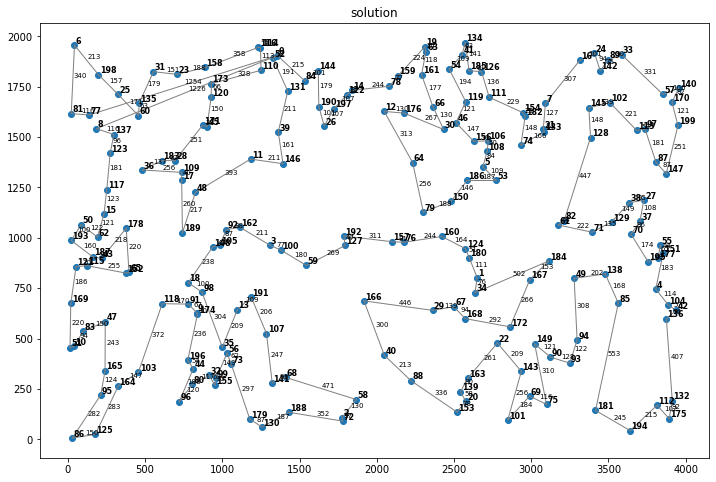

In [348]:
show_route(best_chromosome)

In [44]:
chromosome_length = 200
SGA(number_of_iterations=1400, crossover_probability=0.95, mutation_probability=0.35, population_size=1500, cross_operator=SWP)

  0     1.13072300 304489.95437796 328954.75829477 338376.47970675 6861.48289321
  1     1.96027970 304035.15245643 320574.62590414 327207.78821549 5098.27194043
  2     2.79716992 302321.93569417 313967.96166731 319659.92862650 4150.85573081
  3     3.63255382 301619.51831147 308671.01073654 312971.37101418 2586.04586664
  4     4.47537112 298546.86406117 305774.72841539 307843.11383230 1498.23951944
  5     5.31844091 298546.86406117 303979.80295180 305304.22656149 1065.26946016
  6     6.14451122 296396.11445828 302512.97274524 304035.15245643 1267.73293753
  7     7.00213337 294838.56380476 300816.26805563 302155.15032605 1159.26213234
  8     7.84329486 291197.97615055 299144.03319518 300613.24381982 1191.45480460
  9     8.68493366 287757.73745683 297556.43377268 298873.56453407 1294.12723191
 10     9.50157905 287071.04092441 295704.43964849 297487.20690636 1561.71145732
 11    10.34613824 283406.68953276 293664.75863783 295692.75978991 2007.94699139
 12    11.18672466 283406.68

102    87.19027162 180231.77592651 182447.53419335 183142.63224332 486.73283043
103    88.01780200 178698.14875353 181923.41634834 182511.54613681 414.13409334
104    88.85208225 178698.14875353 181512.14689048 181846.21478578 467.93017204
105    89.69867110 178156.73995086 180788.93422847 181381.80755712 690.40863531
106    90.51861858 176283.01797218 179815.61612341 180842.95665305 702.05494468
107    91.35319495 175800.99929345 179034.06969920 179743.69745674 508.95706193
108    92.21428466 175800.99929345 178464.52354723 178881.91368834 534.70131900
109    93.06344032 174076.86660600 177705.01656045 178698.14875353 879.64780352
110    93.88366890 173532.65042961 176631.58652531 177761.72980873 682.18404389
111    94.69319725 171716.03452320 175964.38539646 176283.01797218 455.39702620
112    95.52381563 171561.75919271 175268.62074746 175889.54313412 745.33776622
113    96.35732889 170634.72580102 174215.74352258 175254.37305288 821.23842493
114    97.19922996 170394.29039800 17327

205   174.15978646 120110.47173572 122389.12943196 122509.93539655 227.68919769
206   174.97341967 119340.79814783 121986.45593879 122417.53665652 365.81823791
207   175.79937792 118281.76441173 121560.17999987 122069.66045935 512.73566546
208   176.60953283 118281.76441173 120968.15723410 121703.18435360 667.02745135
209   177.44796610 118259.54089338 120175.92297548 121042.76936361 579.05141742
210   178.30421305 117452.99376813 119631.04093248 120110.47173572 608.10259385
211   179.13505459 117452.99376813 118800.45493704 119518.52752321 499.73594759
212   179.95869064 117039.06995013 118288.46390494 118455.54860061 143.79136555
213   180.78553700 116496.59704791 118144.80568010 118281.76441173 278.82064744
214   181.62700129 116496.59704791 117632.41451234 118230.26358158 329.66278548
215   182.44360209 115743.44220732 117328.48070914 117587.17314329 243.55510451
216   183.27266383 115743.44220732 117067.87775091 117452.99376813 303.00955655
217   184.12398195 114821.52620132 11674

309   261.35905147 91789.90208494 92679.15459761 92878.90509901 200.26280378
310   262.20480204 91114.54046760 92459.09041827 92722.57511208 265.08809161
311   263.03968287 91032.96967500 92162.07442642 92592.65564446 279.02548458
312   263.86339092 91032.96967500 91906.58371703 91986.53213457 103.00669030
313   264.69153881 90217.58331900 91794.63650132 91926.69839785 260.71843407
314   265.53544211 90063.59166288 91348.23053631 91870.63455913 311.91162361
315   266.37477469 90063.59166288 91060.40924547 91270.27443094 161.25768859
316   267.20889449 89916.19704674 90925.02236004 91114.54046760 292.75583849
317   268.12741923 89656.29006821 90524.19766224 91032.96967500 378.37437058
318   268.93300343 89644.37238586 90168.71614196 90217.58331900  85.13515102
319   269.76851392 89218.00351289 90029.62303210 90203.56978502 113.88587183
320   270.58230591 89199.41570765 89938.38460650 90063.59166288 160.18807878
321   271.41567707 88761.85571429 89732.06384347 89916.19704674 142.92555468

416   351.14762950 67562.51545428 68101.35974922 68339.52566695 202.84016043
417   351.97356033 67134.11734928 67904.48248719 68145.32565356 207.69884706
418   352.81646442 67134.11734928 67681.97738127 67702.43510420  55.97622968
419   353.66240859 66695.83326856 67558.22906953 67702.43510420 133.29448340
420   354.50932288 66695.83326856 67447.13264160 67562.51545428 177.77223718
421   355.34488869 66695.83326856 67182.69893919 67489.93449091 139.79755756
422   356.19426942 66634.31663681 67085.55719495 67134.11734928 131.91852855
423   357.03272772 66257.50387426 66808.58322733 67134.11734928 176.17525157
424   357.86821532 66257.50387426 66692.49851735 66736.07408092  34.67677493
425   358.70905399 65808.30074997 66666.65471533 66695.83326856  89.78901193
426   359.53598642 65689.18611933 66469.26787117 66695.83326856 188.33664853
427   360.37048078 65512.34222227 66274.44965969 66483.62303714 149.28990627
428   361.20584202 65512.34222227 66144.64481284 66257.50387426 171.54417616

523   440.43739748 52175.33804679 52492.84837398 52610.85594669  89.79221361
524   441.26650596 52175.33804679 52401.48000773 52509.79330209  40.12200214
525   442.09361362 52145.89138323 52373.15015828 52386.59560769  31.28492341
526   442.90744376 52126.87065748 52316.04739757 52386.59560769  63.91818002
527   443.73292994 52026.39136299 52252.78928120 52333.68450486  76.62102080
528   444.54818773 51621.35888095 52171.08325335 52175.33804679  22.10964368
529   445.38135052 51616.71998375 52088.67419569 52175.33804679 135.94309392
530   446.20438957 51178.59685747 51903.01306623 52145.89138323 205.50145184
531   447.14726520 51178.59685747 51686.18074470 51945.08493869 132.99172553
532   447.96033525 51178.59685747 51613.50383692 51621.35888095  54.21951227
533   449.04151678 50878.50756909 51352.08544008 51621.35888095 199.79430744
534   449.85711670 50878.50756909 51178.13526352 51178.59685747  11.09028592
535   450.68291879 50412.01255672 50999.41349857 51178.59685747 144.93291088

630   529.63347220 42301.84492118 42611.13830391 42627.45392585  23.26574035
631   530.47060418 42301.84492118 42583.80306188 42599.45301705  46.66693543
632   531.29981995 42212.79808031 42482.30269845 42594.51514465 103.93900823
633   532.14830422 42212.79808031 42381.67124147 42431.84320551  59.91595074
634   532.97558546 42183.42518335 42306.13240172 42413.81880394  25.84648919
635   533.78894377 42183.42518335 42299.10325958 42301.84492118  14.82333058
636   534.60767221 42176.51837350 42245.21771127 42301.84492118  42.36546676
637   535.42242932 42176.51837350 42208.41953301 42212.79808031  10.15247805
638   536.25209498 41983.72074632 42190.13735433 42212.79808031  13.59370607
639   537.06720400 41886.01085092 42181.11088078 42183.71256350  20.41920778
640   537.88716769 41871.30752266 42072.69264131 42183.42518335 101.94551139
641   538.72029305 41687.76221863 41966.75593019 41983.72074632  35.17091101
642   539.53212738 41687.76221863 41904.74574083 41983.72074632  43.88447285

737   619.29080653 36828.53321707 36863.26327453 36865.43399397   8.10887893
738   620.13100386 36743.52297516 36841.93918156 36865.43399397  15.62430396
739   620.95752001 36743.52297516 36830.10567193 36834.29094395   8.86036956
740   621.77985811 36734.76890048 36815.30114814 36828.53321707  30.67141297
741   622.61926794 36691.16440797 36760.21894438 36828.53321707  33.36424223
742   623.46033049 36640.06958156 36743.43408630 36744.17765977   3.63519229
743   624.27100468 36640.06958156 36731.22412266 36743.52297516  27.80554535
744   625.10351110 36514.42366288 36683.97699619 36743.52297516  38.25294651
745   625.92814994 36514.42366288 36651.94484453 36691.16440797  24.26088941
746   626.75778127 36514.42366288 36637.08708342 36640.06958156  18.36907675
747   627.58785582 36445.67025328 36559.39220283 36640.06958156  58.59675577
748   628.43495893 36396.00392506 36514.04726346 36514.42366288   5.19658894
749   629.30224085 36396.00392506 36467.64130634 36514.42366288  41.97137148

844   708.62852550 33975.70945953 33990.44092221 34020.08133507  20.89609140
845   709.43894172 33975.70945953 33975.70945953 33975.70945953   0.00000000
846   710.27802467 33900.10566405 33975.61609604 33975.70945953   2.56327383
847   711.12500811 33827.83302420 33928.76870585 33975.70945953  33.62976365
848   711.94834232 33827.83302420 33902.52297211 33911.26801057   6.43634543
849   712.80017066 33827.83302420 33898.41031393 33900.10566405  10.86940060
850   713.74436069 33827.83302420 33851.82455100 33900.10566405  33.77154811
851   714.56224632 33628.36149136 33827.70004318 33827.83302420   5.14861577
852   715.40719724 33618.48093721 33694.13190778 33827.83302420  93.74915848
853   716.23730993 33575.24639597 33628.27229736 33628.36149136   1.70913962
854   717.06981277 33575.24639597 33607.53892562 33628.36149136  21.88512542
855   717.87905860 33457.33340954 33581.86256795 33594.22119122   9.61685443
856   718.70880890 33457.33340954 33574.22448342 33575.24639597  10.92943069

951   797.52591157 32782.34309407 32782.34309407 32782.34309407   0.00000000
952   798.35549355 32782.34309407 32782.34309407 32782.34309407   0.00000000
953   799.19326425 32782.34309407 32782.34309407 32782.34309407   0.00000000
954   800.04259992 32782.34309407 32782.34309407 32782.34309407   0.00000000
955   800.84165454 32782.34309407 32782.34309407 32782.34309407   0.00000000
956   801.68127441 32782.34309407 32782.34309407 32782.34309407   0.00000000
957   802.59230876 32782.34309407 32782.34309407 32782.34309407   0.00000000
958   803.42385554 32782.34309407 32782.34309407 32782.34309407   0.00000000
959   804.27099299 32782.34309407 32782.34309407 32782.34309407   0.00000000
960   805.10610127 32782.34309407 32782.34309407 32782.34309407   0.00000000
961   805.94044566 32782.34309407 32782.34309407 32782.34309407   0.00000000
962   806.77137804 32782.34309407 32782.34309407 32782.34309407   0.00000000
963   807.59864807 32782.34309407 32782.34309407 32782.34309407   0.00000000

1057   885.74872518 32357.90669146 32403.12067226 32403.15083502   1.16780930
1058   886.58656502 32357.90669146 32374.26178584 32403.15083502  21.71109041
1059   887.42517090 32357.90669146 32357.90669146 32357.90669146   0.00000000
1060   888.27577090 32357.90669146 32357.90669146 32357.90669146   0.00000000
1061   889.10144305 32357.90669146 32357.90669146 32357.90669146   0.00000000
1062   889.93701005 32357.90669146 32357.90669146 32357.90669146   0.00000000
1063   890.77463603 32357.90669146 32357.90669146 32357.90669146   0.00000000
1064   891.59514952 32357.90669146 32357.90669146 32357.90669146   0.00000000
1065   892.43840361 32357.90669146 32357.90669146 32357.90669146   0.00000000
1066   893.26359415 32357.90669146 32357.90669146 32357.90669146   0.00000000
1067   894.09402108 32357.90669146 32357.90669146 32357.90669146   0.00000000
1068   894.92691517 32355.50555877 32357.90509070 32357.90669146   0.06197631
1069   895.76217484 32355.50555877 32356.37797032 32357.90669146

1163   973.72556424 32239.90426756 32239.90426756 32239.90426756   0.00000000
1164   974.55918646 32239.90426756 32239.90426756 32239.90426756   0.00000000
1165   975.39323115 32239.90426756 32239.90426756 32239.90426756   0.00000000
1166   976.22966242 32239.90426756 32239.90426756 32239.90426756   0.00000000
1167   977.07007957 32239.90426756 32239.90426756 32239.90426756   0.00000000
1168   977.89607000 32239.90426756 32239.90426756 32239.90426756   0.00000000
1169   978.72165418 32239.90426756 32239.90426756 32239.90426756   0.00000000
1170   979.55703759 32239.90426756 32239.90426756 32239.90426756   0.00000000
1171   980.39463234 32239.90426756 32239.90426756 32239.90426756   0.00000000
1172   981.21752310 32239.90426756 32239.90426756 32239.90426756   0.00000000
1173   982.03859711 32239.90426756 32239.90426756 32239.90426756   0.00000000
1174   982.86443830 32239.90426756 32239.90426756 32239.90426756   0.00000000
1175   983.70346713 32239.90426756 32239.90426756 32239.90426756

1269  1061.48855138 32239.90426756 32239.90426756 32239.90426756   0.00000000
1270  1062.33366299 32239.90426756 32239.90426756 32239.90426756   0.00000000
1271  1063.16432667 32239.90426756 32239.90426756 32239.90426756   0.00000000
1272  1063.98977709 32239.90426756 32239.90426756 32239.90426756   0.00000000
1273  1064.80256510 32239.90426756 32239.90426756 32239.90426756   0.00000000
1274  1065.62444091 32239.90426756 32239.90426756 32239.90426756   0.00000000
1275  1066.45957875 32239.90426756 32239.90426756 32239.90426756   0.00000000
1276  1067.29445124 32239.90426756 32239.90426756 32239.90426756   0.00000000
1277  1068.12532330 32239.90426756 32239.90426756 32239.90426756   0.00000000
1278  1068.93647766 32239.90426756 32239.90426756 32239.90426756   0.00000000
1279  1069.76935792 32239.90426756 32239.90426756 32239.90426756   0.00000000
1280  1070.59921479 32239.90426756 32239.90426756 32239.90426756   0.00000000
1281  1071.41657186 32239.90426756 32239.90426756 32239.90426756

1375  1149.77174854 32239.90426756 32239.90426756 32239.90426756   0.00000000
1376  1150.60695362 32239.90426756 32239.90426756 32239.90426756   0.00000000
1377  1151.44183421 32239.90426756 32239.90426756 32239.90426756   0.00000000
1378  1152.26870298 32239.90426756 32239.90426756 32239.90426756   0.00000000
1379  1153.08639002 32239.90426756 32239.90426756 32239.90426756   0.00000000
1380  1153.91658854 32239.90426756 32239.90426756 32239.90426756   0.00000000
1381  1154.75392103 32239.90426756 32239.90426756 32239.90426756   0.00000000
1382  1155.59577036 32239.90426756 32239.90426756 32239.90426756   0.00000000
1383  1156.43342495 32239.90426756 32239.90426756 32239.90426756   0.00000000
1384  1157.28696227 32239.90426756 32239.90426756 32239.90426756   0.00000000
1385  1158.11815119 32239.90426756 32239.90426756 32239.90426756   0.00000000
1386  1158.95859003 32239.90426756 32239.90426756 32239.90426756   0.00000000
1387  1159.79281855 32239.90426756 32239.90426756 32239.90426756

<Figure size 864x576 with 0 Axes>

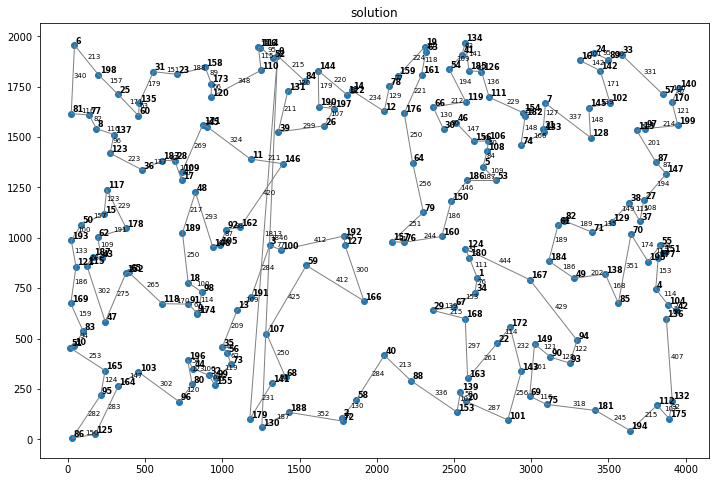

In [45]:
show_route(best_chromosome)

In [10]:
def OX(ind1, ind2):

    cut1 = np.random.choice(range(0, len(ind1)))
    cut2 = cut1
    while cut2 == cut1:
        cut2 = np.random.choice(range(0, len(ind1)))
    if cut1 > cut2:
        cut1 ^= cut2
        cut2 ^= cut1
        cut1 ^= cut2
    
    off1 = np.zeros(len(ind1)) - 1
    off2 = np.zeros(len(ind2)) - 1
    off1[cut1:cut2] = ind1[cut1:cut2]
    off2[cut1:cut2] = ind2[cut1:cut2]
    

    
    pos1, pos2 = cut2, cut2
    for i in chain(range(cut2, len(ind2)), range(0, cut2)):   
        if ind2[i] not in off1:
            off1[pos1] = ind2[i]
            pos1 += 1
        if ind1[i] not in off2:
            off2[pos2] = ind1[i]
            pos2 += 1
        if pos1 == len(ind2):
            pos1 = 0
        if pos2 == len(ind1):
            pos2 = 0
    return off1, off2

In [11]:
def CX(ind1, ind2):

    def create_offspring(p1, p2):
        off = np.zeros(len(ind1)) - 1
        i = 0
        while True:
            if p1[i] in off:
                break
            off[i] = p1[i]
            i = np.where(p2 == off[i])
        for i, v in enumerate(p2):
            if off[i] == -1:
                off[i] = v
        return off
    return create_offspring(ind1, ind2), create_offspring(ind1, ind2)

In [12]:
def SWP(ind1, ind2):
    mask = np.random.rand(len(ind1))
    off1 = np.zeros(len(ind1)) - 1
    off2 = np.zeros(len(ind2)) - 1
    for i, val in enumerate(mask):
        if val < 0.5:
            if ind2[i] in off1:
                off1[i] = ind2[i]
                off2[i] = ind1[i]
            else:
                off1[i] = ind1[i]
                off2[i] = ind2[i]
        else:
            if ind1[i] in off1:
                off1[i] = ind1[i]
                off2[i] = ind2[i]
            else:
                off1[i] = ind2[i]
                off2[i] = ind1[i]
    return ind1, ind2

In [13]:
SWP(np.array([1,2,3,4,5]), np.array([6,7,8,9,10]))

(array([1, 2, 3, 4, 5]), array([ 6,  7,  8,  9, 10]))

In [113]:
K = 2
def local_search(vector, objective_fun):
    best_val, best_vec = objective_fun(vector), vector.copy()
    for perm in permutations(range(len(vector)), K):
        sort = sorted(perm)
        new = vector.copy()
        for i, v in zip(sort, perm):
            new[i] = vector[v]
            
        val = objective_fun(new)
        
        if val < best_val:
            best_val = val
            best_vec = new
            
    return best_vec, best_val

def iterated_local_search(vector, objective_fun):
    best_val, best_vec = objective_fun(vector), vector.copy()
    while True:
        new_vec, new_val = local_search(best_vec, objective_fun)
        if new_val >= best_val:
            return best_vec, best_val
        best_val = new_val
        best_vec = new_vec
            

In [182]:
chromosome_length = n
hist = None
best_chromosome = None

def SGA_local(obj_fun=tsp_objective_function, population_size=500, crossover_probability=0.95, mutation_probability=0.30, number_of_iterations=250, mutation_function=reverse_sequence_mutation, cross_operator=PMX, local_search_prop=0.0005, local_alg=local_search):
    time0 = time.time()
    number_of_offspring = population_size
    global hist
    hist = np.zeros(number_of_iterations)
    global best_chromosome
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = obj_fun(current_population[i, :])

    

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = cross_operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation_function(children_population[i, :])

        for i in range(number_of_offspring):
            if np.random.random() < local_search_prop:
                current_population[i, :], _ = local_alg(current_population[i, :], obj_fun)
        
        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = obj_fun(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        hist[t] = best_objective_value

        # recording some statistics
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))

In [170]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)
tsp_objective_function(p)

Problem size: 52
Distance matrix:
 [[   0.          666.10809934  281.11385594 ...  217.08293346
   789.38267019 1220.46097848]
 [ 666.10809934    0.          649.32657423 ...  596.25917184
  1421.55724471 1716.04924172]
 [ 281.11385594  649.32657423    0.         ...  463.24939288
   995.3140208  1483.59361012]
 ...
 [ 217.08293346  596.25917184  463.24939288 ...    0.
   829.60834133 1150.76061803]
 [ 789.38267019 1421.55724471  995.3140208  ...  829.60834133
     0.          624.81997407]
 [1220.46097848 1716.04924172 1483.59361012 ... 1150.76061803
   624.81997407    0.        ]]
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


7544.365901904086

In [173]:
chromosome_length = n
SGA_local(population_size=4000, crossover_probability=0.95, mutation_probability=0.4, local_search_prop=0.001, local_alg=local_search)

  0     2.23555732 22298.64185003 28462.50146055 29807.56850182 1026.79744416
  1     3.89753294 22298.64185003 27385.04388843 28531.40074922 927.66580123
  2     5.64089727 21780.07360507 26501.80620641 27586.98056818 886.04260155
  3     7.22257924 21780.07360507 25762.05072409 26783.29575404 836.50541762
  4     9.01671934 21712.65565174 25121.53618495 26086.30648993 797.43879632
  5    10.90597606 20997.29408884 24553.04280676 25509.36448614 784.57717275
  6    12.38452888 20419.63076246 24024.48779701 24955.31088742 756.98274353
  7    14.22124410 19946.40786775 23556.66220841 24453.85208867 732.13416651
  8    15.89537287 19236.71271482 23124.24596857 23986.21060079 687.90931454
  9    17.88099551 19236.71271482 22769.23782209 23579.94999636 653.09868169
 10    19.45601678 19053.81008295 22399.13252974 23203.11131136 647.51061246
 11    20.85155392 18707.85112846 22060.02288592 22816.71108827 628.89310333
 12    22.66900873 18124.56160779 21722.65374775 22471.91468017 646.5849778

108   168.35072732 8195.54552195 8207.43330837 8212.10618855   2.81316102
109   169.59961200 8187.72052098 8205.71787980 8206.58079512   2.24221500
110   170.93095303 8187.72052098 8201.96661117 8206.58079512   3.78770384
111   172.01145363 8181.62735272 8198.68124808 8201.07091539   3.00899547
112   172.97890234 8181.62735272 8195.16801604 8198.75579415   2.81708382
113   174.30826807 8181.62735272 8193.05220334 8195.54552195   3.31065114
114   175.47466779 8181.62735272 8189.14678509 8193.24591442   2.41920925
115   176.88168168 8181.62735272 8187.71483994 8187.72052098   0.16775577
116   178.23856020 8159.65272713 8185.12158065 8187.72052098   3.09876207
117   179.37987614 8050.21855765 8181.40129658 8181.62735272   4.47608344
118   181.20305037 8050.21855765 8150.24501278 8181.62735272  53.79450634
119   182.44679713 8049.92224830 8081.80147873 8181.62735272  52.86967677
120   183.75743437 8049.92224830 8050.21766872 8050.21855765   0.01620517
121   184.88718057 8049.92224830 8050.

219   311.74239659 8049.92224830 8049.92224830 8049.92224830   0.00000000
220   312.88496828 8049.92224830 8049.92224830 8049.92224830   0.00000000
221   314.30606890 8049.92224830 8049.92224830 8049.92224830   0.00000000
222   315.58766627 8049.92224830 8049.92224830 8049.92224830   0.00000000
223   317.02637839 8049.92224830 8049.92224830 8049.92224830   0.00000000
224   318.32140040 8049.92224830 8049.92224830 8049.92224830   0.00000000
225   319.37921739 8049.92224830 8049.92224830 8049.92224830   0.00000000
226   320.67750859 8049.92224830 8049.92224830 8049.92224830   0.00000000
227   322.06658101 8049.92224830 8049.92224830 8049.92224830   0.00000000
228   323.46802640 8049.92224830 8049.92224830 8049.92224830   0.00000000
229   324.74270582 8049.92224830 8049.92224830 8049.92224830   0.00000000
230   326.28387976 8049.92224830 8049.92224830 8049.92224830   0.00000000
231   327.58191872 8049.92224830 8049.92224830 8049.92224830   0.00000000
232   328.91607022 8049.92224830 8049.

<Figure size 864x576 with 0 Axes>

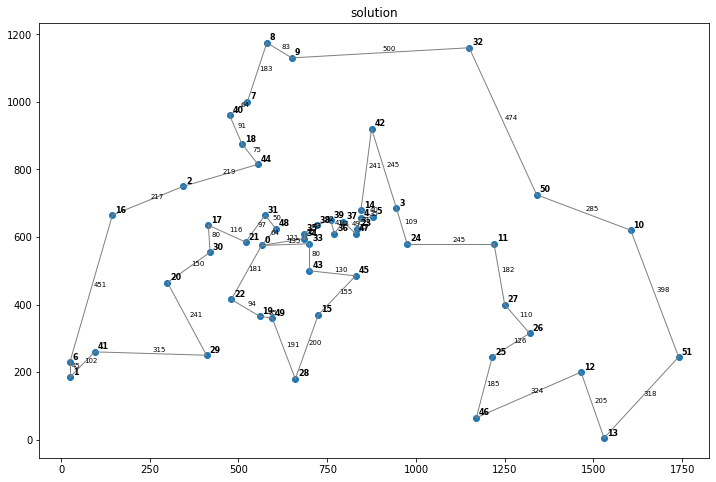

In [174]:
show_route(best_chromosome)

In [107]:
# BAYS29

n = 29
print('Problem size: %d' % n)

coords = np.array([1150.0, 1760.0, 630.0, 1660.0, 40.0, 2090.0, 750.0, 1100.0, 750.0, 2030.0, 1030.0, 2070.0, 1650.0, 650.0, 1490.0, 1630.0, 790.0, 2260.0, 840.0, 550.0, 1170.0, 2300.0, 970.0, 1340.0, 510.0, 700.0, 750.0, 900.0, 1280.0, 1200.0, 230.0, 590.0, 460.0, 860.0, 1040.0, 950.0, 590.0, 1390.0, 830.0, 1770.0, 490.0, 500.0, 1840.0, 1240.0, 1260.0, 1500.0, 1260.0, 1500.0, 1280.0, 790.0, 490.0, 2130.0, 1460.0, 1420.0, 1260.0, 1910.0, 360.0, 1980.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
x ="0 107 241 190 124  80 316  76 152 157 283 133 113 297 228 129 348 276 188 150  65 341 184  67 221 169 108  45 167-\
 107   0 148 137  88 127 336 183 134  95 254 180 101 234 175 176 265 199 182  67  42 278 271 146 251 105 191 139  79-\
 241 148   0 374 171 259 509 317 217 232 491 312 280 391 412 349 422 356 355 204 182 435 417 292 424 116 337 273  77-\
 190 137 374   0 202 234 222 192 248  42 117 287  79 107  38 121 152  86  68  70 137 151 239 135 137 242 165 228 205-\
 124  88 171 202   0  61 392 202  46 160 319 112 163 322 240 232 314 287 238 155  65 366 300 175 307  57 220 121  97-\
  80 127 259 234  61   0 386 141  72 167 351  55 157 331 272 226 362 296 232 164  85 375 249 147 301 118 188  60 185-\
 316 336 509 222 392 386   0 233 438 254 202 439 235 254 210 187 313 266 154 282 321 298 168 249  95 437 190 314 435-\
  76 183 317 192 202 141 233   0 213 188 272 193 131 302 233  98 344 289 177 216 141 346 108  57 190 245  43  81 243-\
 152 134 217 248  46  72 438 213   0 206 365  89 209 368 286 278 360 333 284 201 111 412 321 221 353  72 266 132 111-\
 157  95 232  42 160 167 254 188 206   0 159 220  57 149  80 132 193 127 100  28  95 193 241 131 169 200 161 189 163-\
 283 254 491 117 319 351 202 272 365 159   0 404 176 106  79 161 165 141  95 187 254 103 279 215 117 359 216 308 322-\
 133 180 312 287 112  55 439 193  89 220 404   0 210 384 325 279 415 349 285 217 138 428 310 200 354 169 241 112 238-\
 113 101 280  79 163 157 235 131 209  57 176 210   0 186 117  75 231 165  81  85  92 230 184  74 150 208 104 158 206-\
 297 234 391 107 322 331 254 302 368 149 106 384 186   0  69 191  59  35 125 167 255  44 309 245 169 327 246 335 288-\
 228 175 412  38 240 272 210 233 286  80  79 325 117  69   0 122 122  56  56 108 175 113 240 176 125 280 177 266 243-\
 129 176 349 121 232 226 187  98 278 132 161 279  75 191 122   0 244 178  66 160 161 235 118  62  92 277  55 155 275-\
 348 265 422 152 314 362 313 344 360 193 165 415 231  59 122 244   0  66 178 198 286  77 362 287 228 358 299 380 319-\
 276 199 356  86 287 296 266 289 333 127 141 349 165  35  56 178  66   0 112 132 220  79 296 232 181 292 233 314 253-\
 188 182 355  68 238 232 154 177 284 100  95 285  81 125  56  66 178 112   0 128 167 169 179 120  69 283 121 213 281-\
 150  67 204  70 155 164 282 216 201  28 187 217  85 167 108 160 198 132 128   0  88 211 269 159 197 172 189 182 135-\
  65  42 182 137  65  85 321 141 111  95 254 138  92 255 175 161 286 220 167  88   0 299 229 104 236 110 149  97 108-\
 341 278 435 151 366 375 298 346 412 193 103 428 230  44 113 235  77  79 169 211 299   0 353 289 213 371 290 379 332-\
 184 271 417 239 300 249 168 108 321 241 279 310 184 309 240 118 362 296 179 269 229 353   0 121 162 345  80 189 342-\
  67 146 292 135 175 147 249  57 221 131 215 200  74 245 176  62 287 232 120 159 104 289 121   0 154 220  41  93 218-\
 221 251 424 137 307 301  95 190 353 169 117 354 150 169 125  92 228 181  69 197 236 213 162 154   0 352 147 247 350-\
 169 105 116 242  57 118 437 245  72 200 359 169 208 327 280 277 358 292 283 172 110 371 345 220 352   0 265 178  39-\
 108 191 337 165 220 188 190  43 266 161 216 241 104 246 177  55 299 233 121 189 149 290  80  41 147 265   0 124 263-\
  45 139 273 228 121  60 314  81 132 189 308 112 158 335 266 155 380 314 213 182  97 379 189  93 247 178 124   0 199-\
 167  79  77 205  97 185 435 243 111 163 322 238 206 288 243 275 319 253 281 135 108 332 342 218 350  39 263 199   0"

for j, row in enumerate(x.split('-')):
    i = 0
    for c in row.strip().split(' '):
        if c != '':
            A[j][i] = int(c)
            i += 1
            if i == 29:
                i = 0
                j += 1

print('Distance matrix:\n', A)

p = [x-1 for x in [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13, 21]]
print('Optimal solution:\n', p, tsp_objective_function(p))

Problem size: 29
Distance matrix:
 [[  0. 107. 241. 190. 124.  80. 316.  76. 152. 157. 283. 133. 113. 297.
  228. 129. 348. 276. 188. 150.  65. 341. 184.  67. 221. 169. 108.  45.
  167.]
 [107.   0. 148. 137.  88. 127. 336. 183. 134.  95. 254. 180. 101. 234.
  175. 176. 265. 199. 182.  67.  42. 278. 271. 146. 251. 105. 191. 139.
   79.]
 [241. 148.   0. 374. 171. 259. 509. 317. 217. 232. 491. 312. 280. 391.
  412. 349. 422. 356. 355. 204. 182. 435. 417. 292. 424. 116. 337. 273.
   77.]
 [190. 137. 374.   0. 202. 234. 222. 192. 248.  42. 117. 287.  79. 107.
   38. 121. 152.  86.  68.  70. 137. 151. 239. 135. 137. 242. 165. 228.
  205.]
 [124.  88. 171. 202.   0.  61. 392. 202.  46. 160. 319. 112. 163. 322.
  240. 232. 314. 287. 238. 155.  65. 366. 300. 175. 307.  57. 220. 121.
   97.]
 [ 80. 127. 259. 234.  61.   0. 386. 141.  72. 167. 351.  55. 157. 331.
  272. 226. 362. 296. 232. 164.  85. 375. 249. 147. 301. 118. 188.  60.
  185.]
 [316. 336. 509. 222. 392. 386.   0. 233. 438. 254. 2

In [100]:
chromosome_length = n
SGA_local(number_of_iterations=100, population_size=250, crossover_probability=0.95, mutation_probability=0.35, local_search_prop=0.01, local_alg=local_search)

  0    21.93424463 4770.00000000 5559.15200000 5931.00000000 257.34021236
  1    43.63133478 4517.00000000 5313.87600000 5575.00000000 217.22063582
  2    66.01043582 3946.00000000 5080.95600000 5359.00000000 231.99695270
  3    87.67903161 3946.00000000 4869.20000000 5123.00000000 194.52829100
  4    98.87349677 3946.00000000 4724.54800000 4939.00000000 170.38096049
  5   109.71638179 3863.00000000 4599.44400000 4819.00000000 185.89162129
  6   153.60454154 3863.00000000 4451.61600000 4682.00000000 182.57495048
  7   186.18173933 3743.00000000 4308.29200000 4520.00000000 176.86299425
  8   208.45467925 3308.00000000 4206.06000000 4429.00000000 177.59209554
  9   219.50075030 3308.00000000 4094.71200000 4314.00000000 162.54719024
 10   276.15649891 3261.00000000 3996.89200000 4194.00000000 170.45844167
 11   331.48985314 3261.00000000 3905.84000000 4100.00000000 186.86071390
 12   331.54010987 3217.00000000 3757.68400000 3994.00000000 215.88999084
 13   375.33455038 3052.00000000 3588.

In [117]:
chromosome_length = n
SGA_local(number_of_iterations=100, population_size=2000, crossover_probability=0.95, mutation_probability=0.40, local_search_prop=0.001, local_alg=iterated_local_search)

  0     0.90697479 4233.00000000 5577.40900000 5938.00000000 278.84464800
  1     1.95001984 2862.00000000 5282.93650000 5600.00000000 257.42827636
  2     3.36108518 2434.00000000 5054.48650000 5353.00000000 260.00432846
  3     5.40582538 2434.00000000 4835.19800000 5133.00000000 312.18938771
  4     6.54142237 2434.00000000 4568.47300000 4940.00000000 407.50480767
  5     7.48444724 2434.00000000 4189.73000000 4679.00000000 491.93421623
  6     8.66730237 2434.00000000 3675.74500000 4274.00000000 480.41713331
  7     9.96106029 2397.00000000 3203.89650000 3720.00000000 356.39270445
  8    10.54476690 2397.00000000 2878.74500000 3238.00000000 228.97646380
  9    10.90114498 2376.00000000 2668.86500000 2887.00000000 139.76594998
 10    11.36529016 2373.00000000 2541.16900000 2677.00000000  79.07475855
 11    11.68708658 2290.00000000 2472.04700000 2542.00000000  33.92657942
 12    12.05869532 2290.00000000 2446.43050000 2469.00000000  19.72549542
 13    12.36740208 2290.00000000 2429.

In [152]:
# BAYG29

n = 29
print('Problem size: %d' % n)

coords = np.array([1150.0, 1760.0, 630.0, 1660.0, 40.0, 2090.0, 750.0, 1100.0, 750.0, 2030.0, 1030.0, 2070.0, 1650.0, 650.0, 1490.0, 1630.0, 790.0, 2260.0, 840.0, 550.0, 1170.0, 2300.0, 970.0, 1340.0, 510.0, 700.0, 750.0, 900.0, 1280.0, 1200.0, 230.0, 590.0, 460.0, 860.0, 1040.0, 950.0, 590.0, 1390.0, 830.0, 1770.0, 490.0, 500.0, 1840.0, 1240.0, 1260.0, 1500.0, 1260.0, 1500.0, 1280.0, 790.0, 490.0, 2130.0, 1460.0, 1420.0, 1260.0, 1910.0, 360.0, 1980.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
X =["97 205 139  86  60 220  65 111 115 227  95  82 225 168 103 266 205 149 120  58 257 152  52 180 136  82  34 145",
"129 103  71 105 258 154 112  65 204 150  87 176 137 142 204 148 148  49  41 211 226 116 197  89 153 124  74",
"219 125 175 386 269 134 184 313 201 215 267 248 271 274 236 272 160 151 300 350 239 322  78 276 220  60",
"167 182 180 162 208  39 102 227  60  86  34  96 129  69  58  60 120 119 192 114 110 192 136 173 173",
"51 296 150  42 131 268  88 131 245 201 175 275 218 202 119  50 281 238 131 244  51 166  95  69",
"279 114  56 150 278  46 133 266 214 162 302 242 203 146  67 300 205 111 238  98 139  52 120",
"178 328 206 147 308 172 203 165 121 251 216 122 231 249 209 111 169  72 338 144 237 331",
"169 151 227 133 104 242 182  84 290 230 146 165 121 270  91  48 158 200  39  64 210",
"172 309  68 169 286 242 208 315 259 240 160  90 322 260 160 281  57 192 107  90",
"140 195  51 117  72 104 153  93  88  25  85 152 200 104 139 154 134 149 135",
"320 146  64  68 143 106  88  81 159 219  63 216 187  88 293 191 258 272",
"174 311 258 196 347 288 243 192 113 345 222 144 274 124 165  71 153",
"144  86  57 189 128  71  71  82 176 150  56 114 168  83 115 160",
"61 165  51  32 105 127 201  36 254 196 136 260 212 258 234",
"106 110  56  49  91 153  91 197 136  94 225 151 201 205",
"215 159  64 126 128 190  98  53  78 218  48 127 214",
"61 155 157 235  47 305 243 186 282 261 300 252",
"105 100 176  66 253 183 146 231 203 239 204",
"113 152 127 150 106  52 235 112 179 221",
"79 163 220 119 164 135 152 153 114",
"236 201  90 195  90 127  84  91",
"273 226 148 296 238 291 269",
"112 130 286  74 155 291",
"130 178  38  75 180",
"281 120 205 270",
"213 145  36",
"94 217",
"162"]

X = [[int(k) for k in x.split(' ') if k] for x in X]
for i, l in enumerate(X):
    print(l)
    for j, v in enumerate(l):
        if v != 0:
            A[i, j + i + 1] = v
            A[j + i + 1, i] = v


print('Distance matrix:\n', A)

p = [x-1 for x in [1, 28, 6, 12, 9, 5, 26, 29, 3, 2, 20, 10, 4, 15, 18, 17, 14, 22, 11, 19, 25, 7, 23, 27, 8, 24, 16, 13, 24]]
print('Optimal solution:\n', p)
print(tsp_objective_function(p))

Problem size: 29
[97, 205, 139, 86, 60, 220, 65, 111, 115, 227, 95, 82, 225, 168, 103, 266, 205, 149, 120, 58, 257, 152, 52, 180, 136, 82, 34, 145]
[129, 103, 71, 105, 258, 154, 112, 65, 204, 150, 87, 176, 137, 142, 204, 148, 148, 49, 41, 211, 226, 116, 197, 89, 153, 124, 74]
[219, 125, 175, 386, 269, 134, 184, 313, 201, 215, 267, 248, 271, 274, 236, 272, 160, 151, 300, 350, 239, 322, 78, 276, 220, 60]
[167, 182, 180, 162, 208, 39, 102, 227, 60, 86, 34, 96, 129, 69, 58, 60, 120, 119, 192, 114, 110, 192, 136, 173, 173]
[51, 296, 150, 42, 131, 268, 88, 131, 245, 201, 175, 275, 218, 202, 119, 50, 281, 238, 131, 244, 51, 166, 95, 69]
[279, 114, 56, 150, 278, 46, 133, 266, 214, 162, 302, 242, 203, 146, 67, 300, 205, 111, 238, 98, 139, 52, 120]
[178, 328, 206, 147, 308, 172, 203, 165, 121, 251, 216, 122, 231, 249, 209, 111, 169, 72, 338, 144, 237, 331]
[169, 151, 227, 133, 104, 242, 182, 84, 290, 230, 146, 165, 121, 270, 91, 48, 158, 200, 39, 64, 210]
[172, 309, 68, 169, 286, 242, 208, 315, 

In [158]:
chromosome_length = n
SGA_local(number_of_iterations=100, population_size=2000, crossover_probability=0.95, mutation_probability=0.40, local_search_prop=0.01, local_alg=local_search)

  0     0.92056656 3427.00000000 4418.29300000 4700.00000000 215.77374759
  1     1.73425961 3400.00000000 4200.81500000 4438.00000000 185.85583600
  2     2.46776795 3292.00000000 4035.59200000 4252.00000000 172.79845930
  3     3.16181397 3202.00000000 3896.72550000 4102.00000000 163.20036811
  4     3.84145999 3084.00000000 3780.32900000 3971.00000000 149.81215491
  5     4.45749569 2988.00000000 3682.23100000 3860.00000000 142.73276652
  6     5.17356372 2927.00000000 3599.05150000 3768.00000000 136.32394085
  7     5.90152788 2765.00000000 3522.29950000 3683.00000000 134.84009715
  8     6.68533134 2758.00000000 3449.62000000 3612.00000000 136.09507559
  9     7.41396308 2757.00000000 3372.90250000 3536.00000000 137.73430580
 10     8.05513525 2631.00000000 3303.26550000 3464.00000000 136.28399029
 11     8.83823156 2630.00000000 3241.01300000 3401.00000000 133.96172898
 12     9.64913201 2621.00000000 3175.06000000 3336.00000000 132.59733557
 13    10.29933095 2618.00000000 3110.

In [157]:
chromosome_length = n
SGA_local(number_of_iterations=100, population_size=2000, crossover_probability=0.95, mutation_probability=0.40, local_search_prop=0.005, local_alg=iterated_local_search)

  0     3.38884377 3367.00000000 4422.50100000 4706.00000000 217.49847126
  1     6.24496794 2422.00000000 4194.46000000 4442.00000000 198.92869677
  2     9.77202415 2416.00000000 4019.69850000 4241.00000000 196.61428890
  3    12.80932188 2098.00000000 3846.40350000 4079.00000000 228.41137819
  4    16.33830094 2098.00000000 3657.01750000 3924.00000000 281.27044138
  5    20.13186121 1969.00000000 3417.08250000 3750.00000000 318.06988335
  6    22.24641442 1806.00000000 3144.63500000 3513.00000000 309.58912735
  7    24.16587043 1806.00000000 2920.53600000 3254.00000000 263.14624775
  8    27.04145765 1618.00000000 2742.20050000 3027.00000000 224.10060531
  9    29.32294440 1618.00000000 2602.75800000 2858.00000000 195.92590803
 10    31.85932755 1618.00000000 2481.04800000 2704.00000000 178.10871314
 11    34.68833137 1618.00000000 2370.29250000 2578.00000000 173.77726245
 12    36.28347421 1618.00000000 2247.86000000 2455.00000000 167.69818842
 13    38.15923500 1618.00000000 2118.

## QAP

In [176]:
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'
def read_data(URL):
    qap_instance_file = urllib.request.urlopen(URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return n, A, B
n, A, B = read_data(QAP_INSTANCE_URL)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

In [177]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [178]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


In [186]:
chromosome_length = n
SGA_local2(number_of_iterations=50, obj_fun=qap_objective_function, population_size=4000, crossover_probability=0.95, mutation_probability=0.5, local_alg=iterated_local_search, local_search_prop=0.001)

  0     1.01859283 634.00000000 769.09200000 808.00000000  28.98543662
  1     1.77023315 634.00000000 746.14150000 778.00000000  25.21061240
  2     2.99348044 602.00000000 730.58250000 760.00000000  23.71863600
  3     3.92223215 602.00000000 718.54100000 746.00000000  22.12770478
  4     4.68737602 598.00000000 707.82100000 734.00000000  21.47300536
  5     5.46573830 592.00000000 698.80600000 724.00000000  20.67700085
  6     6.25870872 592.00000000 690.68050000 716.00000000  19.94978495
  7     7.04112601 592.00000000 683.44250000 708.00000000  19.33541294
  8     7.81996107 582.00000000 676.80450000 700.00000000  18.84048247
  9     8.56685758 582.00000000 670.02050000 692.00000000  18.46511792
 10     9.33529854 582.00000000 663.98100000 686.00000000  18.01315183
 11    10.08356977 582.00000000 658.38500000 680.00000000  17.47958166
 12    10.86291885 582.00000000 653.37250000 674.00000000  17.09699517
 13    11.80703163 582.00000000 648.34850000 670.00000000  16.73928158
 14   

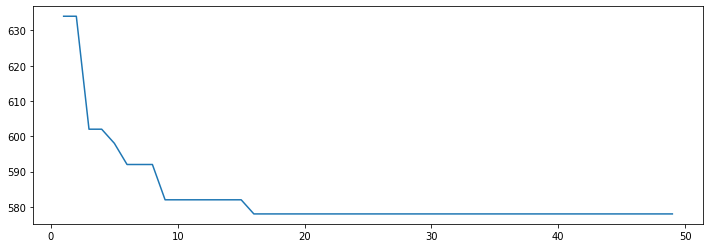

In [188]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [189]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug14.dat')

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

In [190]:
p = [8, 7, 12, 1, 0, 10, 6, 13, 2, 3, 11, 4, 5, 9]
print(qap_objective_function(p), p)

1014.0 [8, 7, 12, 1, 0, 10, 6, 13, 2, 3, 11, 4, 5, 9]


In [192]:
chromosome_length = n
SGA_local2(number_of_iterations=50, obj_fun=qap_objective_function, population_size=4000, crossover_probability=0.95, mutation_probability=0.4, local_alg=iterated_local_search, local_search_prop=0.001)

  0     1.49650192 1154.00000000 1307.97500000 1360.00000000  37.54846701
  1     2.44339037 1102.00000000 1275.79050000 1318.00000000  32.50481672
  2     3.38629937 1068.00000000 1251.68800000 1290.00000000  30.08189914
  3     4.52026653 1068.00000000 1233.51150000 1268.00000000  27.94624067
  4     5.72279692 1068.00000000 1218.59150000 1250.00000000  26.22344615
  5     6.90913248 1066.00000000 1205.54650000 1236.00000000  25.23064283
  6     8.12287068 1066.00000000 1193.98400000 1224.00000000  24.95799960
  7     9.02523637 1032.00000000 1183.00450000 1212.00000000  24.53320158
  8    10.06461930 1032.00000000 1172.58700000 1202.00000000  24.54350079
  9    10.86508584 1032.00000000 1162.74400000 1192.00000000  24.34005883
 10    11.98073316 1032.00000000 1153.65800000 1182.00000000  24.19572351
 11    12.93552232 1032.00000000 1144.27250000 1172.00000000  24.00197375
 12    14.02332425 1032.00000000 1134.98550000 1164.00000000  23.61024756
 13    14.84005928 1026.00000000 1125.

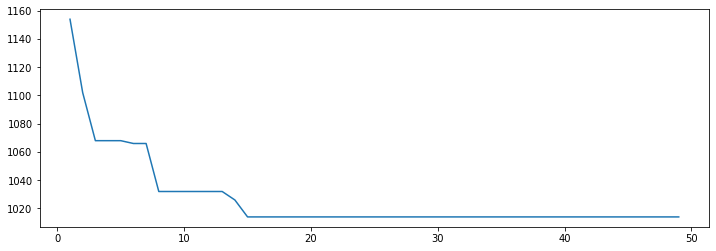

In [193]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [194]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug15.dat')

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

In [195]:
p = [0, 1, 12, 7, 8, 3, 2, 13, 6, 10, 9, 14, 5, 4, 11]
print(qap_objective_function(p), p)

1150.0 [0, 1, 12, 7, 8, 3, 2, 13, 6, 10, 9, 14, 5, 4, 11]


In [198]:
chromosome_length = n
SGA_local2(number_of_iterations=50, obj_fun=qap_objective_function, population_size=5000, crossover_probability=0.95, mutation_probability=0.4, local_alg=iterated_local_search, local_search_prop=0.001)

  0     2.30619574 1312.00000000 1520.40400000 1578.00000000  44.00579944
  1     4.51225996 1300.00000000 1483.85160000 1532.00000000  38.48236450
  2     5.93070364 1276.00000000 1457.66560000 1502.00000000  35.79032518
  3     7.43617868 1210.00000000 1435.99320000 1478.00000000  34.74184730
  4     8.53198552 1204.00000000 1417.56520000 1458.00000000  33.92755442
  5     9.94037724 1204.00000000 1400.46760000 1440.00000000  33.66046569
  6    11.52192950 1202.00000000 1385.07480000 1426.00000000  33.73552438
  7    13.11282969 1166.00000000 1371.36280000 1410.00000000  33.48056714
  8    14.65146637 1166.00000000 1357.65840000 1396.00000000  33.89730534
  9    16.15743780 1166.00000000 1343.54680000 1384.00000000  34.91377106
 10    17.45106244 1166.00000000 1329.75280000 1370.00000000  35.66416257
 11    18.92316198 1166.00000000 1314.27040000 1358.00000000  36.72789245
 12    20.12354565 1166.00000000 1297.49360000 1342.00000000  37.80723157
 13    21.65062213 1166.00000000 1275.

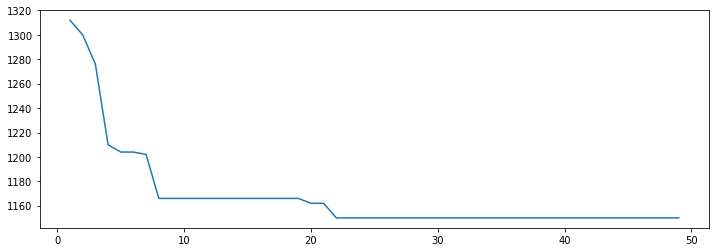

In [201]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [284]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug17.dat')

Problem size: 17
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3

In [285]:
p = [ x - 1 for x in [16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5]]
print(qap_objective_function(p), p)

1732.0 [15, 14, 1, 13, 8, 10, 7, 11, 9, 2, 3, 0, 6, 5, 12, 16, 4]


In [286]:
chromosome_length = n
SGA_local(number_of_iterations=50, obj_fun=qap_objective_function, population_size=10000, crossover_probability=0.95, mutation_probability=0.4, local_alg=iterated_local_search, local_search_prop=0.001)

  0     4.52953792 1942.00000000 2238.78520000 2314.00000000  56.65034034
  1     8.94389892 1898.00000000 2190.03020000 2252.00000000  49.28459686
  2    11.92077327 1898.00000000 2153.12460000 2210.00000000  45.99847470
  3    15.47793245 1894.00000000 2124.29020000 2178.00000000  43.73134555
  4    19.94148779 1880.00000000 2100.23240000 2152.00000000  41.98601184
  5    23.76317859 1870.00000000 2079.28120000 2130.00000000  40.31195513
  6    29.75070572 1856.00000000 2061.03160000 2108.00000000  39.16957750
  7    34.50568581 1752.00000000 2043.75420000 2090.00000000  38.07384381
  8    38.46671510 1752.00000000 2028.23500000 2074.00000000  37.29159121
  9    42.10609913 1752.00000000 2013.41380000 2058.00000000  36.88650661
 10    46.65259767 1752.00000000 1999.98300000 2044.00000000  37.03614601
 11    50.65175891 1752.00000000 1986.68040000 2030.00000000  37.08404854
 12    54.37443590 1752.00000000 1974.27080000 2016.00000000  37.33994466
 13    57.64904475 1752.00000000 1961.

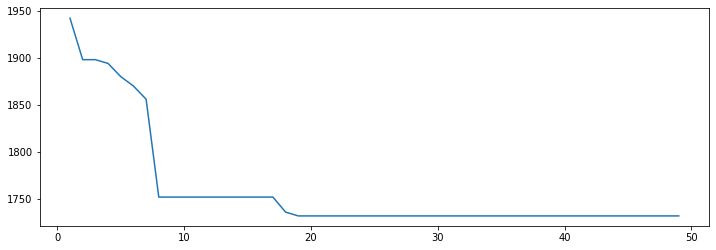

In [287]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [289]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug20.dat')

Problem size: 20
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [3. 4. 5. 6. 7. 2. 3. 4

In [290]:
p = [ x - 1 for x in [18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6]]
print(qap_objective_function(p), p)

2570.0 [17, 13, 9, 2, 8, 3, 1, 11, 10, 15, 18, 14, 19, 7, 12, 16, 4, 6, 0, 5]


In [292]:
chromosome_length = n
SGA_local(number_of_iterations=50, obj_fun=qap_objective_function, population_size=15000, crossover_probability=0.95, mutation_probability=0.4, local_alg=iterated_local_search, local_search_prop=0.001)

  0    12.25675869 2950.00000000 3304.12520000 3400.00000000  71.89409659
  1    22.31357980 2902.00000000 3240.68986667 3322.00000000  63.43045602
  2    33.79195690 2900.00000000 3193.79786667 3268.00000000  58.86849250
  3    45.18485689 2678.00000000 3156.44453333 3224.00000000  55.46117191
  4    53.80485511 2662.00000000 3123.70213333 3188.00000000  54.23715155
  5    62.41523457 2622.00000000 3096.34186667 3158.00000000  54.16553819
  6    69.92801213 2622.00000000 3070.27920000 3132.00000000  55.73077110
  7    80.92567182 2622.00000000 3045.43560000 3108.00000000  58.04381436
  8    88.42305565 2622.00000000 3020.50360000 3086.00000000  61.15920198
  9    95.55411410 2622.00000000 2995.28360000 3062.00000000  64.32732212
 10   103.81769657 2622.00000000 2969.43706667 3040.00000000  67.03940662
 11   113.29545116 2622.00000000 2942.60160000 3016.00000000  68.69982783
 12   121.89237857 2622.00000000 2913.74813333 2990.00000000  70.18054643
 13   131.92875552 2616.00000000 2883.

In [293]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug24.dat')

Problem size: 24
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6. 4. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5. 5. 4. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4. 6. 5. 4. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3. 7. 6. 5. 4. 3. 4.]
 [5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2. 8. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 7. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5

In [294]:
p = [x - 1 for x in [17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2]]
print(qap_objective_function(p), p)

3488.0 [16, 7, 10, 22, 3, 19, 14, 18, 21, 17, 2, 13, 0, 9, 6, 8, 15, 20, 23, 11, 5, 12, 4, 1]


In [295]:
chromosome_length = n
SGA_local(number_of_iterations=50, obj_fun=qap_objective_function, population_size=20000, crossover_probability=0.95, mutation_probability=0.4, local_alg=iterated_local_search, local_search_prop=0.001)

  0    29.26462698 4158.00000000 4628.18540000 4754.00000000  94.50219483
  1    51.29464960 3576.00000000 4545.65860000 4650.00000000  83.18947677
  2    80.26480269 3576.00000000 4483.32860000 4578.00000000  78.00079757
  3   101.35905433 3576.00000000 4431.39420000 4522.00000000  77.16765000
  4   122.64173579 3576.00000000 4387.18440000 4476.00000000  78.87912016
  5   141.19206023 3576.00000000 4344.64140000 4434.00000000  83.85763535
  6   166.26566815 3576.00000000 4300.50010000 4394.00000000  93.74505267
  7   188.83588195 3576.00000000 4250.61930000 4354.00000000 108.04614323
  8   214.19662714 3576.00000000 4184.61120000 4308.00000000 127.81547338
  9   235.98246694 3558.00000000 4091.14680000 4246.00000000 144.96083074
 10   259.68819928 3558.00000000 3967.22740000 4148.00000000 141.69329515
 11   275.59253049 3558.00000000 3840.78380000 4004.00000000 113.96229753
 12   294.10568786 3526.00000000 3738.19640000 3864.00000000  81.38614518
 13   301.77503967 3526.00000000 3665.

In [296]:
n, A, B = read_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/nug28.dat')

Problem size: 28
Flow matrix:
 [[ 0.  3.  2.  0.  0.  2. 10.  5.  0.  5.  2.  5.  0.  0.  2.  0.  5.  6.
   3.  0.  1. 10.  0. 10.  2.  1.  1.  1.]
 [ 3.  0.  4.  0. 10.  4.  0.  0.  2.  2.  1.  0.  5.  0.  0.  0.  0.  2.
   0.  1.  6.  1.  0.  1.  2.  2.  5.  1.]
 [ 2.  4.  0.  3.  4.  0.  5.  5.  5.  1.  4.  1.  0.  4.  0.  4.  0.  6.
   3.  2.  5.  5.  2.  1.  0.  0.  3.  1.]
 [ 0.  0.  3.  0.  0.  0.  0.  2.  2.  0.  6.  0.  2.  5.  2.  5.  1.  1.
   1.  1.  2.  2.  4.  0.  2.  0.  2.  2.]
 [ 0. 10.  4.  0.  0.  5.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  1.
   0.  0.  2.  0.  5.  1.  0.  2.  1.  0.]
 [ 2.  4.  0.  0.  5.  0.  1.  2.  2.  1.  4. 10. 10.  2.  5.  5.  0.  5.
   0.  0.  0. 10.  0.  0.  0.  4.  0. 10.]
 [10.  0.  5.  0.  2.  1.  0. 10. 10.  5. 10. 10.  6.  0.  0. 10.  2.  1.
  10.  1.  5.  5.  2.  3.  5.  0.  2.  0.]
 [ 5.  0.  5.  2.  0.  2. 10.  0.  1.  3.  5.  0.  0.  0.  2.  4.  5.  2.
  10.  6.  0.  5.  5.  2.  5.  0.  5.  5.]
 [ 0.  2.  5.  2.  0.  2. 10.  1.

In [297]:
p = [ x - 1 for x in [18,21,9,1,28,20,11,3,13,12,10,19,14,22,15,2,25,16,4,23,7,17,24,26,5,27,8,6]]
print(qap_objective_function(p), p)

5166.0 [17, 20, 8, 0, 27, 19, 10, 2, 12, 11, 9, 18, 13, 21, 14, 1, 24, 15, 3, 22, 6, 16, 23, 25, 4, 26, 7, 5]


In [298]:
chromosome_length = n
SGA_local(number_of_iterations=50, obj_fun=qap_objective_function, population_size=20000, crossover_probability=0.95, mutation_probability=0.4, local_alg=iterated_local_search, local_search_prop=0.001)

  0    62.82170081 6132.00000000 6755.85190000 6918.00000000 121.17927821
  1   108.57884049 5296.00000000 6650.92450000 6786.00000000 105.74479609
  2   162.51040173 5296.00000000 6574.35800000 6696.00000000  99.42850414
  3   211.01187825 5296.00000000 6512.15770000 6626.00000000  97.00932806
  4   257.00989008 5296.00000000 6457.83110000 6570.00000000  98.91965261
  5   298.83569908 5296.00000000 6407.69330000 6520.00000000 108.21699929
  6   346.02679396 5296.00000000 6354.98030000 6474.00000000 123.35508588
  7   388.21865153 5296.00000000 6292.29750000 6426.00000000 147.04313957
  8   429.39202642 5256.00000000 6207.16090000 6370.00000000 180.04988895
  9   466.13875985 5256.00000000 6092.67930000 6300.00000000 209.18119980
 10   512.46060753 5256.00000000 5942.80690000 6198.00000000 222.95116576
 11   536.15773058 5256.00000000 5771.86820000 6044.00000000 207.13821142
 12   560.65218449 5256.00000000 5601.20340000 5846.00000000 167.75550730
 13   576.22695613 5256.00000000 5455.

In [258]:
def read_tai_data2(URL):
    tai_instance_file = urllib.request.urlopen(URL)

    line = tai_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    #tai_instance_file.readline()
    for i in range(n):
        line = tai_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    tai_instance_file.readline()
    for i in range(n):
        line = tai_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return n, A, B

In [299]:
n, A, B = read_tai_data('http://anjos.mgi.polymtl.ca/qaplib/data.d/tai50a.dat')

Problem size: 50
Flow matrix:
 [[ 0. 21. 95. ... 11. 29. 82.]
 [21.  0. 82. ... 83. 96. 74.]
 [95. 82.  0. ... 89. 48. 14.]
 ...
 [11. 83. 89. ...  0. 94. 53.]
 [29. 96. 48. ... 94.  0.  6.]
 [82. 74. 14. ... 53.  6.  0.]]
Distance matrix:
 [[ 0. 97. 20. ... 80. 10. 78.]
 [97.  0. 55. ... 91. 45. 83.]
 [20. 55.  0. ... 19. 67. 42.]
 ...
 [80. 91. 19. ...  0. 80. 40.]
 [10. 45. 67. ... 80.  0. 20.]
 [78. 83. 42. ... 40. 20.  0.]]


In [300]:
print("best solution = 4390920")

best solution = 4390920


In [301]:
chromosome_length = n
SGA_local(number_of_iterations=200, obj_fun=qap_objective_function, population_size=30000, crossover_probability=0.95, mutation_probability=0.4, local_alg=local_search, local_search_prop=0.0001)

  0    24.06343889 5608254.00000000 5852359.72406667 5898902.00000000 35115.26236709
  1    42.70291257 5608254.00000000 5824151.43080000 5863168.00000000 31235.91569436
  2    62.14218354 5608254.00000000 5803873.80893333 5839836.00000000 29325.14890525
  3    79.93408966 5600498.00000000 5787863.91513333 5821754.00000000 27940.56053503
  4    98.98082805 5600498.00000000 5774866.98000000 5807394.00000000 27129.59210740
  5   116.42768431 5600498.00000000 5763317.60793333 5795120.00000000 26589.88882510
  6   135.58099365 5600498.00000000 5752945.82793333 5784170.00000000 26031.89740750
  7   154.15520144 5598300.00000000 5744104.33366667 5774582.00000000 25381.78895158
  8   172.07923937 5580400.00000000 5735832.73813333 5765762.00000000 24924.10592317
  9   191.21259618 5580400.00000000 5728315.02700000 5757738.00000000 24423.03044970
 10   209.73779774 5565236.00000000 5721327.56813333 5750336.00000000 24128.30108579
 11   229.02913523 5565236.00000000 5714989.72720000 5743778.0000

 97  1635.21942425 5155140.00000000 5161903.97726667 5168170.00000000 5133.30571424
 98  1648.41250515 5155140.00000000 5157697.55920000 5157702.00000000 106.57208310
 99  1663.98688245 5155140.00000000 5156171.03420000 5157702.00000000 1256.37498337
100  1678.93856263 5155140.00000000 5155140.00000000 5155140.00000000   0.00000000
101  1693.89228916 5155140.00000000 5155140.00000000 5155140.00000000   0.00000000
102  1707.56121492 5155140.00000000 5155140.00000000 5155140.00000000   0.00000000
103  1722.42323327 5155140.00000000 5155140.00000000 5155140.00000000   0.00000000
104  1736.74599981 5151488.00000000 5155139.87826667 5155140.00000000  21.08448041
105  1751.17596579 5148128.00000000 5152950.34840000 5155140.00000000 1791.39655292
106  1764.90393329 5148128.00000000 5151484.41600000 5151488.00000000 109.67859839
107  1780.89633250 5148128.00000000 5149480.84800000 5151488.00000000 1647.83845352
108  1794.20653152 5148128.00000000 5148128.00000000 5148128.00000000   0.00000000


196  3107.04657865 5125284.00000000 5125284.00000000 5125284.00000000   0.00000000
197  3120.72682166 5125284.00000000 5125284.00000000 5125284.00000000   0.00000000
198  3135.06656504 5125284.00000000 5125284.00000000 5125284.00000000   0.00000000
199  3150.05726814 5125284.00000000 5125284.00000000 5125284.00000000   0.00000000


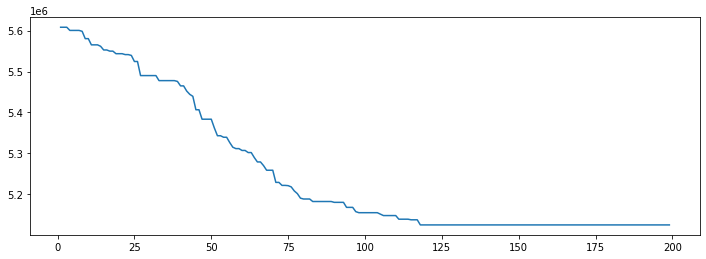

In [302]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [303]:
n, A, B = read_tai_data2('http://anjos.mgi.polymtl.ca/qaplib/data.d/tai60a.dat')

Problem size: 60
Flow matrix:
 [[ 0. 79. 71. ... 64. 87. 53.]
 [79.  0. 98. ... 69. 81. 99.]
 [71. 98.  0. ... 17. 24. 27.]
 ...
 [64. 69. 17. ...  0. 73. 78.]
 [87. 81. 24. ... 73.  0.  3.]
 [53. 99. 27. ... 78.  3.  0.]]
Distance matrix:
 [[ 0. 21. 95. ... 89. 76. 76.]
 [21.  0. 40. ... 11. 77. 32.]
 [95. 40.  0. ...  8. 38. 41.]
 ...
 [89. 11.  8. ...  0. 32. 56.]
 [76. 77. 38. ... 32.  0. 26.]
 [76. 32. 41. ... 56. 26.  0.]]


In [304]:
print("best solution =  7205962")

best solution =  7205962


In [305]:
chromosome_length = n
SGA_local(number_of_iterations=200, obj_fun=qap_objective_function, population_size=30000, crossover_probability=0.95, mutation_probability=0.4, local_alg=local_search, local_search_prop=0.0001)

  0    32.37692571 8216646.00000000 8457730.54893333 8514700.00000000 43225.95899834
  1    54.94704509 8193172.00000000 8423403.52153333 8471032.00000000 37905.81250199
  2    76.38371134 8189374.00000000 8398754.40206667 8441986.00000000 35416.50618250
  3    97.94650030 8151206.00000000 8379533.35746667 8420370.00000000 33828.93299111
  4   121.58455372 8151206.00000000 8363253.84953333 8402880.00000000 32964.85796549
  5   144.24152255 8128694.00000000 8349396.94380000 8387686.00000000 32180.80602996
  6   167.82284331 8128694.00000000 8337465.52593333 8374862.00000000 31422.01939193
  7   189.37675238 8128694.00000000 8326518.53053333 8363288.00000000 31057.39409330
  8   213.22088552 8128694.00000000 8316490.27960000 8352886.00000000 30676.46834375
  9   235.82127976 8128694.00000000 8307176.18593333 8343164.00000000 30247.37603598
 10   258.35890985 8116720.00000000 8298329.53606667 8333912.00000000 29842.27326003
 11   279.86779261 8116192.00000000 8290095.16726667 8325426.0000

 97  2075.79231167 7555742.00000000 7572062.35633333 7575038.00000000 4976.15866508
 98  2093.50183225 7555742.00000000 7565247.30246667 7575038.00000000 3862.94557897
 99  2113.33393383 7555742.00000000 7563714.30520000 7563736.00000000 400.62297112
100  2131.16813278 7547992.00000000 7559709.09333333 7563736.00000000 4115.37372778
101  2149.12674737 7547992.00000000 7555486.43820000 7556634.00000000 2553.06392219
102  2169.00745726 7547992.00000000 7551618.28626667 7556634.00000000 3910.42273444
103  2187.00209475 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
104  2208.88661933 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
105  2226.85895753 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
106  2245.65092635 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
107  2261.45788646 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
108  2282.23973680 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000

196  3935.51788092 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
197  3953.35855079 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
198  3971.09371495 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000
199  3987.79062676 7547992.00000000 7547992.00000000 7547992.00000000   0.00000000


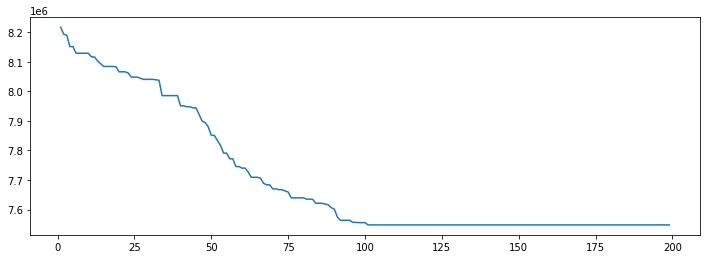

In [306]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()

In [308]:
n, A, B = read_tai_data2('http://anjos.mgi.polymtl.ca/qaplib/data.d/tai80a.dat')

Problem size: 80
Flow matrix:
 [[ 0. 64. 51. ... 66. 87. 45.]
 [64.  0. 28. ... 21. 69. 21.]
 [51. 28.  0. ... 96.  7.  4.]
 ...
 [66. 21. 96. ...  0. 73.  3.]
 [87. 69.  7. ... 73.  0. 53.]
 [45. 21.  4. ...  3. 53.  0.]]
Distance matrix:
 [[ 0. 21. 95. ... 61. 80. 58.]
 [21.  0. 21. ... 62. 46. 25.]
 [95. 21.  0. ... 33. 35. 61.]
 ...
 [61. 62. 33. ...  0. 66. 43.]
 [80. 46. 35. ... 66.  0. 82.]
 [58. 25. 61. ... 43. 82.  0.]]


In [309]:
print("best solution =  13499184")

best solution =  13499184


In [310]:
chromosome_length = n
SGA_local(number_of_iterations=200, obj_fun=qap_objective_function, population_size=50000, crossover_probability=0.95, mutation_probability=0.4, local_alg=local_search, local_search_prop=0.0001)

  0    73.17879677 15199242.00000000 15544943.12668000 15619852.00000000 56920.86159083
  1   131.21487379 15199242.00000000 15499090.94904000 15562064.00000000 50363.59878399
  2   184.48736334 15199242.00000000 15466684.88328000 15524382.00000000 46980.41982043
  4   290.17407107 15112520.00000000 15419278.09480000 15471898.00000000 43669.55016784
  5   343.79996896 15112520.00000000 15400813.39684000 15451828.00000000 42463.40405899
  6   408.83871889 15106592.00000000 15384624.43328000 15434436.00000000 41588.38736089
  7   457.39078307 15106592.00000000 15370302.95420000 15419198.00000000 40901.18346354
  8   507.90159750 15106592.00000000 15357106.82048000 15405402.00000000 40505.69328268
  9   558.60923553 15106592.00000000 15344814.19444000 15392208.00000000 40027.90732431
 10   611.59133029 15040334.00000000 15333276.44832000 15380420.00000000 39796.54256961
 11   679.30917668 15038298.00000000 15322479.85360000 15369312.00000000 39488.78843787
 12   740.02370334 15038298.0000

 95  4881.12341881 14133500.00000000 14173080.04756000 14186486.00000000 8000.45200127
 96  4933.84451556 14133500.00000000 14168281.43844000 14172558.00000000 6154.57715810
 97  4981.52269292 14133500.00000000 14162514.67000000 14171772.00000000 7845.63422310
 98  5024.31970763 14121332.00000000 14155170.04624000 14166206.00000000 3560.52831342
 99  5082.63671899 14121332.00000000 14153538.93232000 14153776.00000000 1584.77213854
100  5132.91579628 14121332.00000000 14149620.14108000 14153776.00000000 6472.93005301
101  5185.39330053 14121332.00000000 14144435.15540000 14153776.00000000 7822.79074318
102  5232.96924114 14121332.00000000 14139105.87628000 14149132.00000000 6368.96112861
103  5273.69334674 14111504.00000000 14135509.09536000 14139802.00000000 6424.38028002
104  5326.39199138 14111504.00000000 14127729.09384000 14138010.00000000 6877.40541702
105  5368.75263810 14111504.00000000 14121328.52596000 14121332.00000000 166.91228812
106  5410.98097491 14111504.00000000 1411706

191  9484.41672421 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
192  9532.01105762 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
193  9586.96238184 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
194  9631.40943694 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
195  9688.89410090 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
196  9731.30504751 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
197  9778.02202439 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
198  9815.55484772 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000
199  9855.42396712 14103616.00000000 14103616.00000000 14103616.00000000   0.00000000


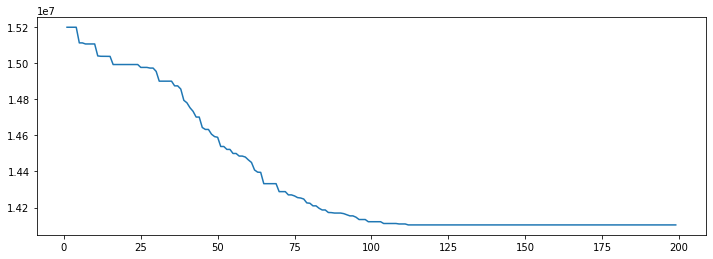

In [311]:
plt.figure(figsize=(12,4))
plt.plot(hist)
plt.show()